In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from keras.models import load_model

%matplotlib inline
%config InlineBackend.figure_format='retina'
import os
os.environ["PATH"] += os.pathsep + "C:/Graphviz/bin"

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
import scipy.io
bth = scipy.io.loadmat('Data/health_bearing/H-A-1.mat')
bth1 = scipy.io.loadmat('Data/health_bearing/H-A-2.mat')
kbth = scipy.io.loadmat('Data/inner_fault/I-A-1.mat')
data1 = bth["Channel_1"]
data2 = bth["Channel_1"]
data3 = kbth["Channel_1"]
df = data1

In [10]:
train_size = int(len(df) * 0.95)
train = df[0:train_size]
test = df[train_size:]
print(train.shape, test.shape)

(1900000, 1) (100000, 1)


In [11]:
from scipy.interpolate import interp1d

def spline_resampling(data, new_length):
    x = np.arange(len(data))
    f = interp1d(x, data, kind='cubic')
    new_x = np.linspace(0, len(data) - 1, new_length)
    return f(new_x)

In [12]:
train = spline_resampling(train.flatten(), 100000)
test = spline_resampling(test.flatten(), 100000)

In [13]:
from sklearn.preprocessing import StandardScaler

train = train.reshape(len(train),1)
test = test.reshape(len(test),1)

scaler = StandardScaler()
scaler = scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

In [14]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)        
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
TIME_STEPS = 100

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train, TIME_STEPS)
X_test, y_test = create_dataset(test, test, TIME_STEPS)

print(X_train.shape)

(99900, 100, 1)


In [11]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

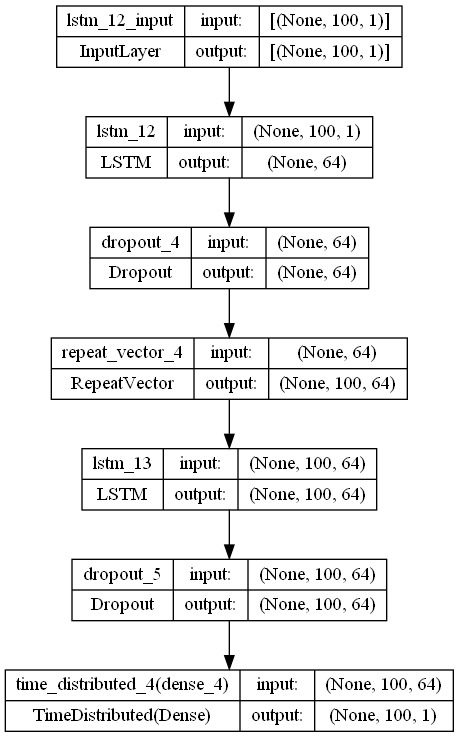

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96)

In [12]:
model.compile(optimizer='adam', loss='mae')
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
703/703 [==============================] - 27s 26ms/step - loss: 0.7236 - val_loss: 0.8939
Epoch 2/10
703/703 [==============================] - 18s 26ms/step - loss: 0.7100 - val_loss: 0.8655
Epoch 3/10
703/703 [==============================] - 21s 30ms/step - loss: 0.6782 - val_loss: 0.8662
Epoch 4/10
703/703 [==============================] - 20s 29ms/step - loss: 0.6773 - val_loss: 0.8656
Epoch 5/10
703/703 [==============================] - 18s 25ms/step - loss: 0.6768 - val_loss: 0.8654
Epoch 6/10
703/703 [==============================] - 16s 23ms/step - loss: 0.6756 - val_loss: 0.8650
Epoch 7/10
703/703 [==============================] - 16s 22ms/step - loss: 0.6748 - val_loss: 0.8647
Epoch 8/10
703/703 [==============================] - 16s 23ms/step - loss: 0.6746 - val_loss: 0.8638
Epoch 9/10
703/703 [==============================] - 16s 23ms/step - loss: 0.6737 - val_loss: 0.8632
Epoch 10/10
703/703 [==============================] - 17s 24ms/step - loss: 0.672

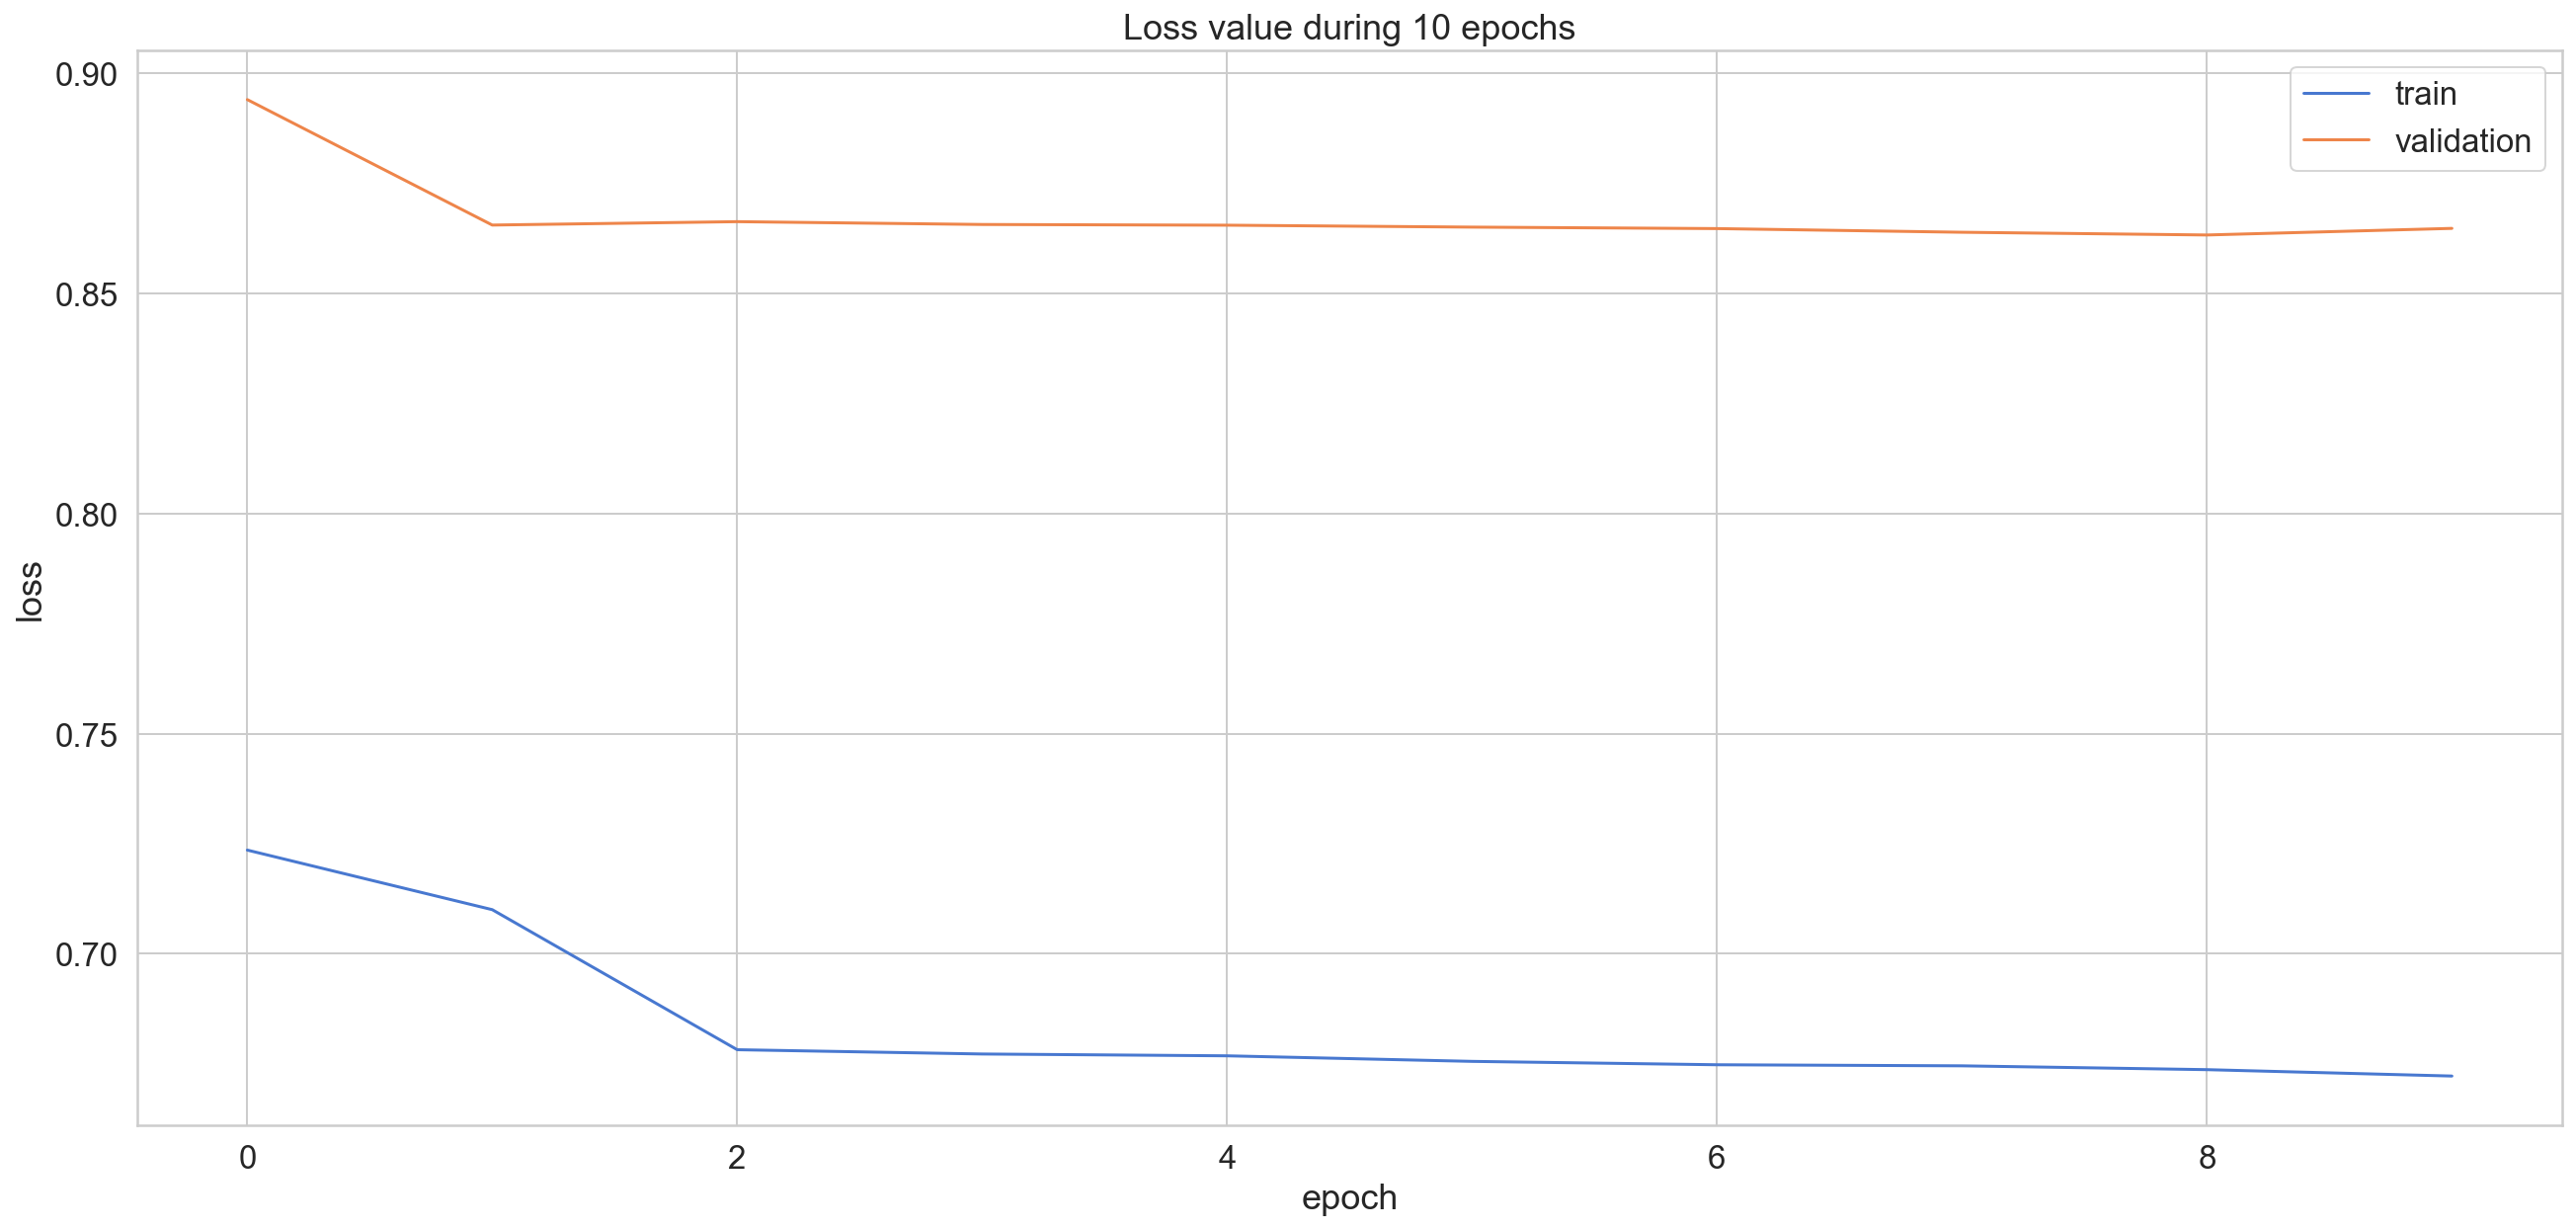

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss value during 10 epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
model = load_model("model_AE_step_100.h5")

In [20]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

3122/3122 [==============================] - 23s 7ms/step


In [17]:
X_train_pred = model.predict(X_test)

train_mae_loss = np.mean(np.abs(X_train_pred - X_test), axis=1)

3122/3122 [==============================] - 27s 7ms/step


C:\Users\PC\AppData\Local\Temp/ipykernel_19036/696894156.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=100, kde=True)


<AxesSubplot: ylabel='Density'>

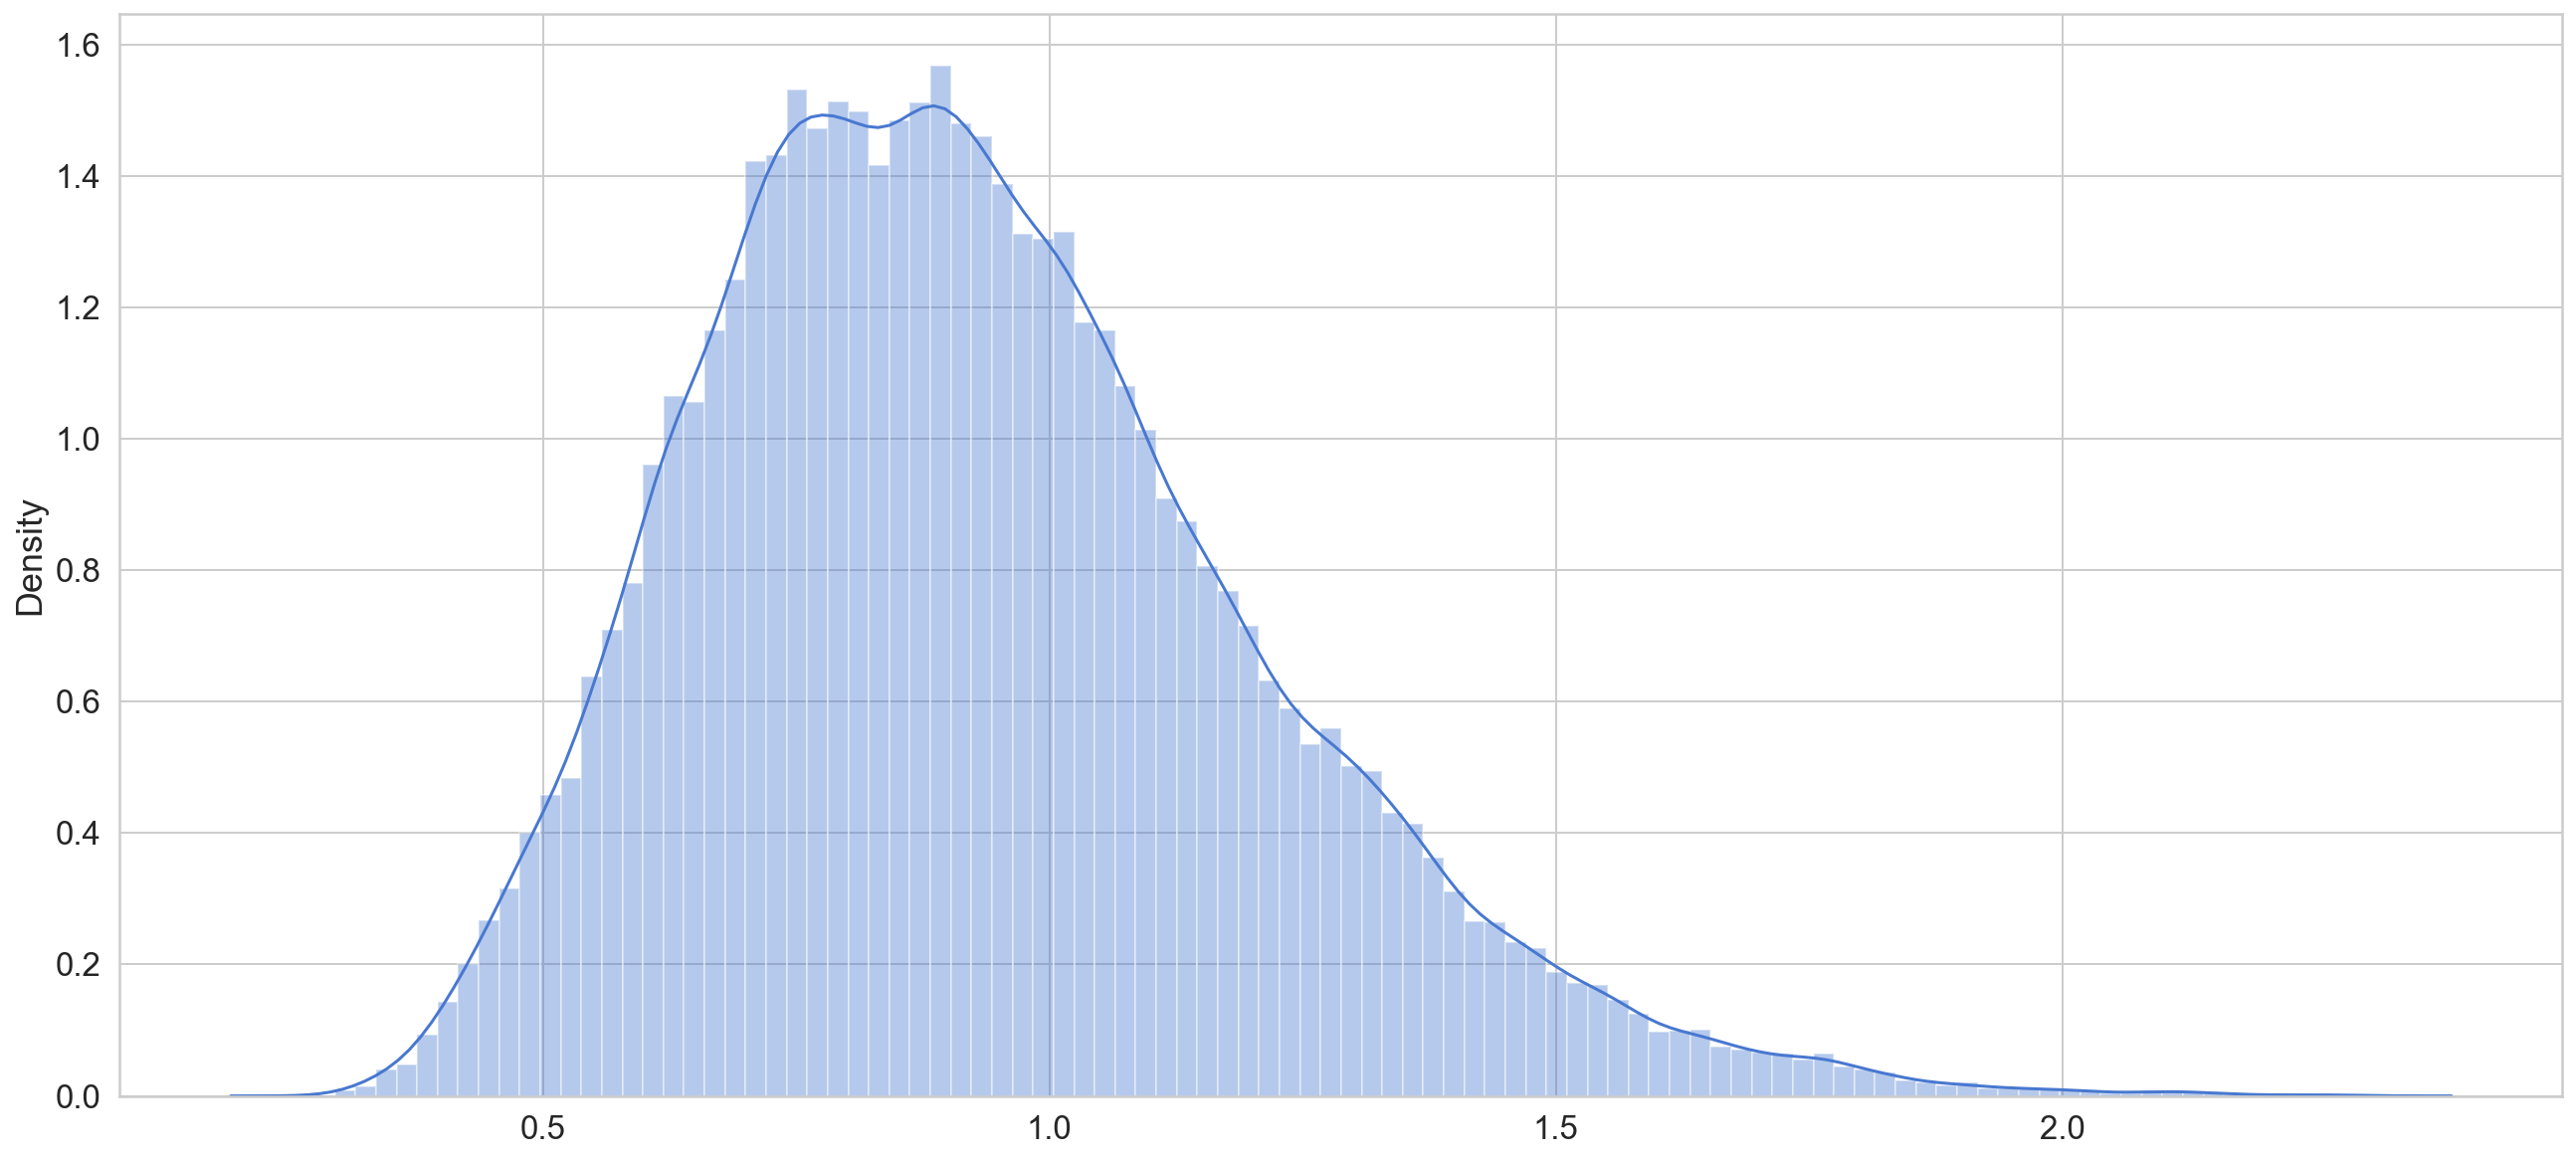

In [18]:
sns.distplot(train_mae_loss, bins=100, kde=True)

In [80]:
THRESHOLD_HIGH = np.mean(train_mae_loss) + 4.5*np.std(train_mae_loss)
THRESHOLD_LOW = np.mean(train_mae_loss) - 4.5*np.std(train_mae_loss)
print(THRESHOLD_HIGH)
print(THRESHOLD_LOW)

2.0320682749975036
-0.17048723827616719


In [20]:
model_cnn = load_model("model_bearing.h5")

In [21]:
def create_dataset_cnn(X, time_steps=1):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)        
        # ys.append(y[i + time_steps])
    return np.array(Xs)#, np.array(ys)

### Test 1: Inner fault

In [22]:
kbth = scipy.io.loadmat('Data/inner_fault/I-A-1.mat')

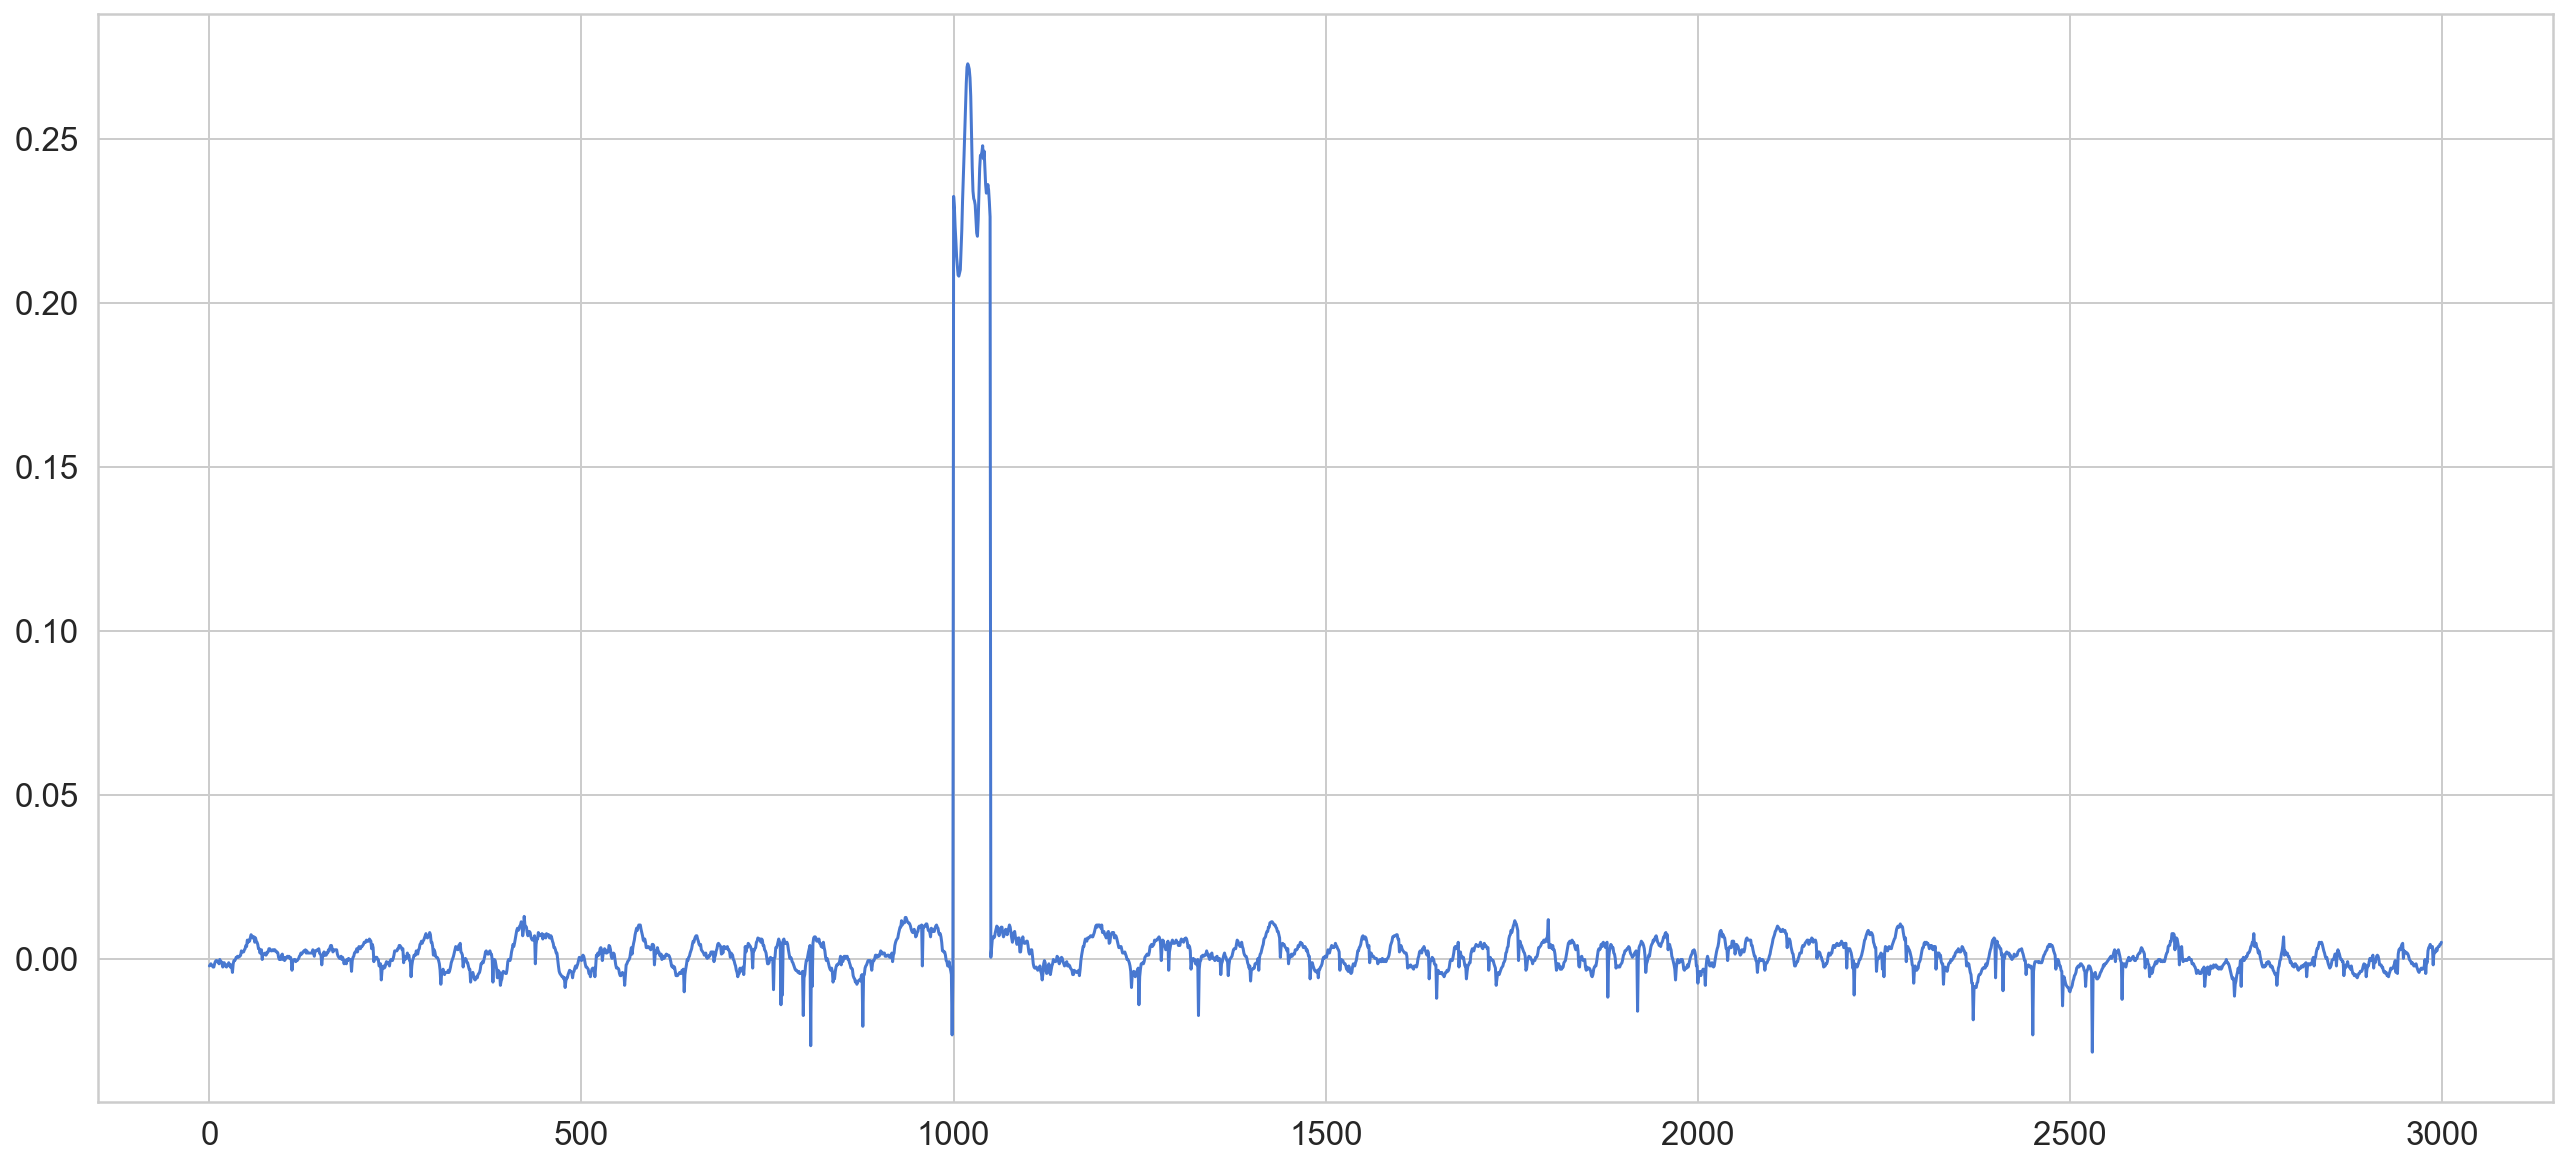

In [23]:
test = data2[:3000]
test[1000:1050] = kbth["Channel_1"][1000:1050]
plt.plot(test)

91/91 [==============================] - 4s 7ms/step
(array([ 903,  904,  905,  906,  907,  908,  909,  910,  911,  912,  913,
        914,  915,  916,  917,  918,  919,  920,  921,  922,  923,  924,
        925,  926,  927,  928,  929,  930,  931,  932,  933,  934,  935,
        936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,
        947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 104

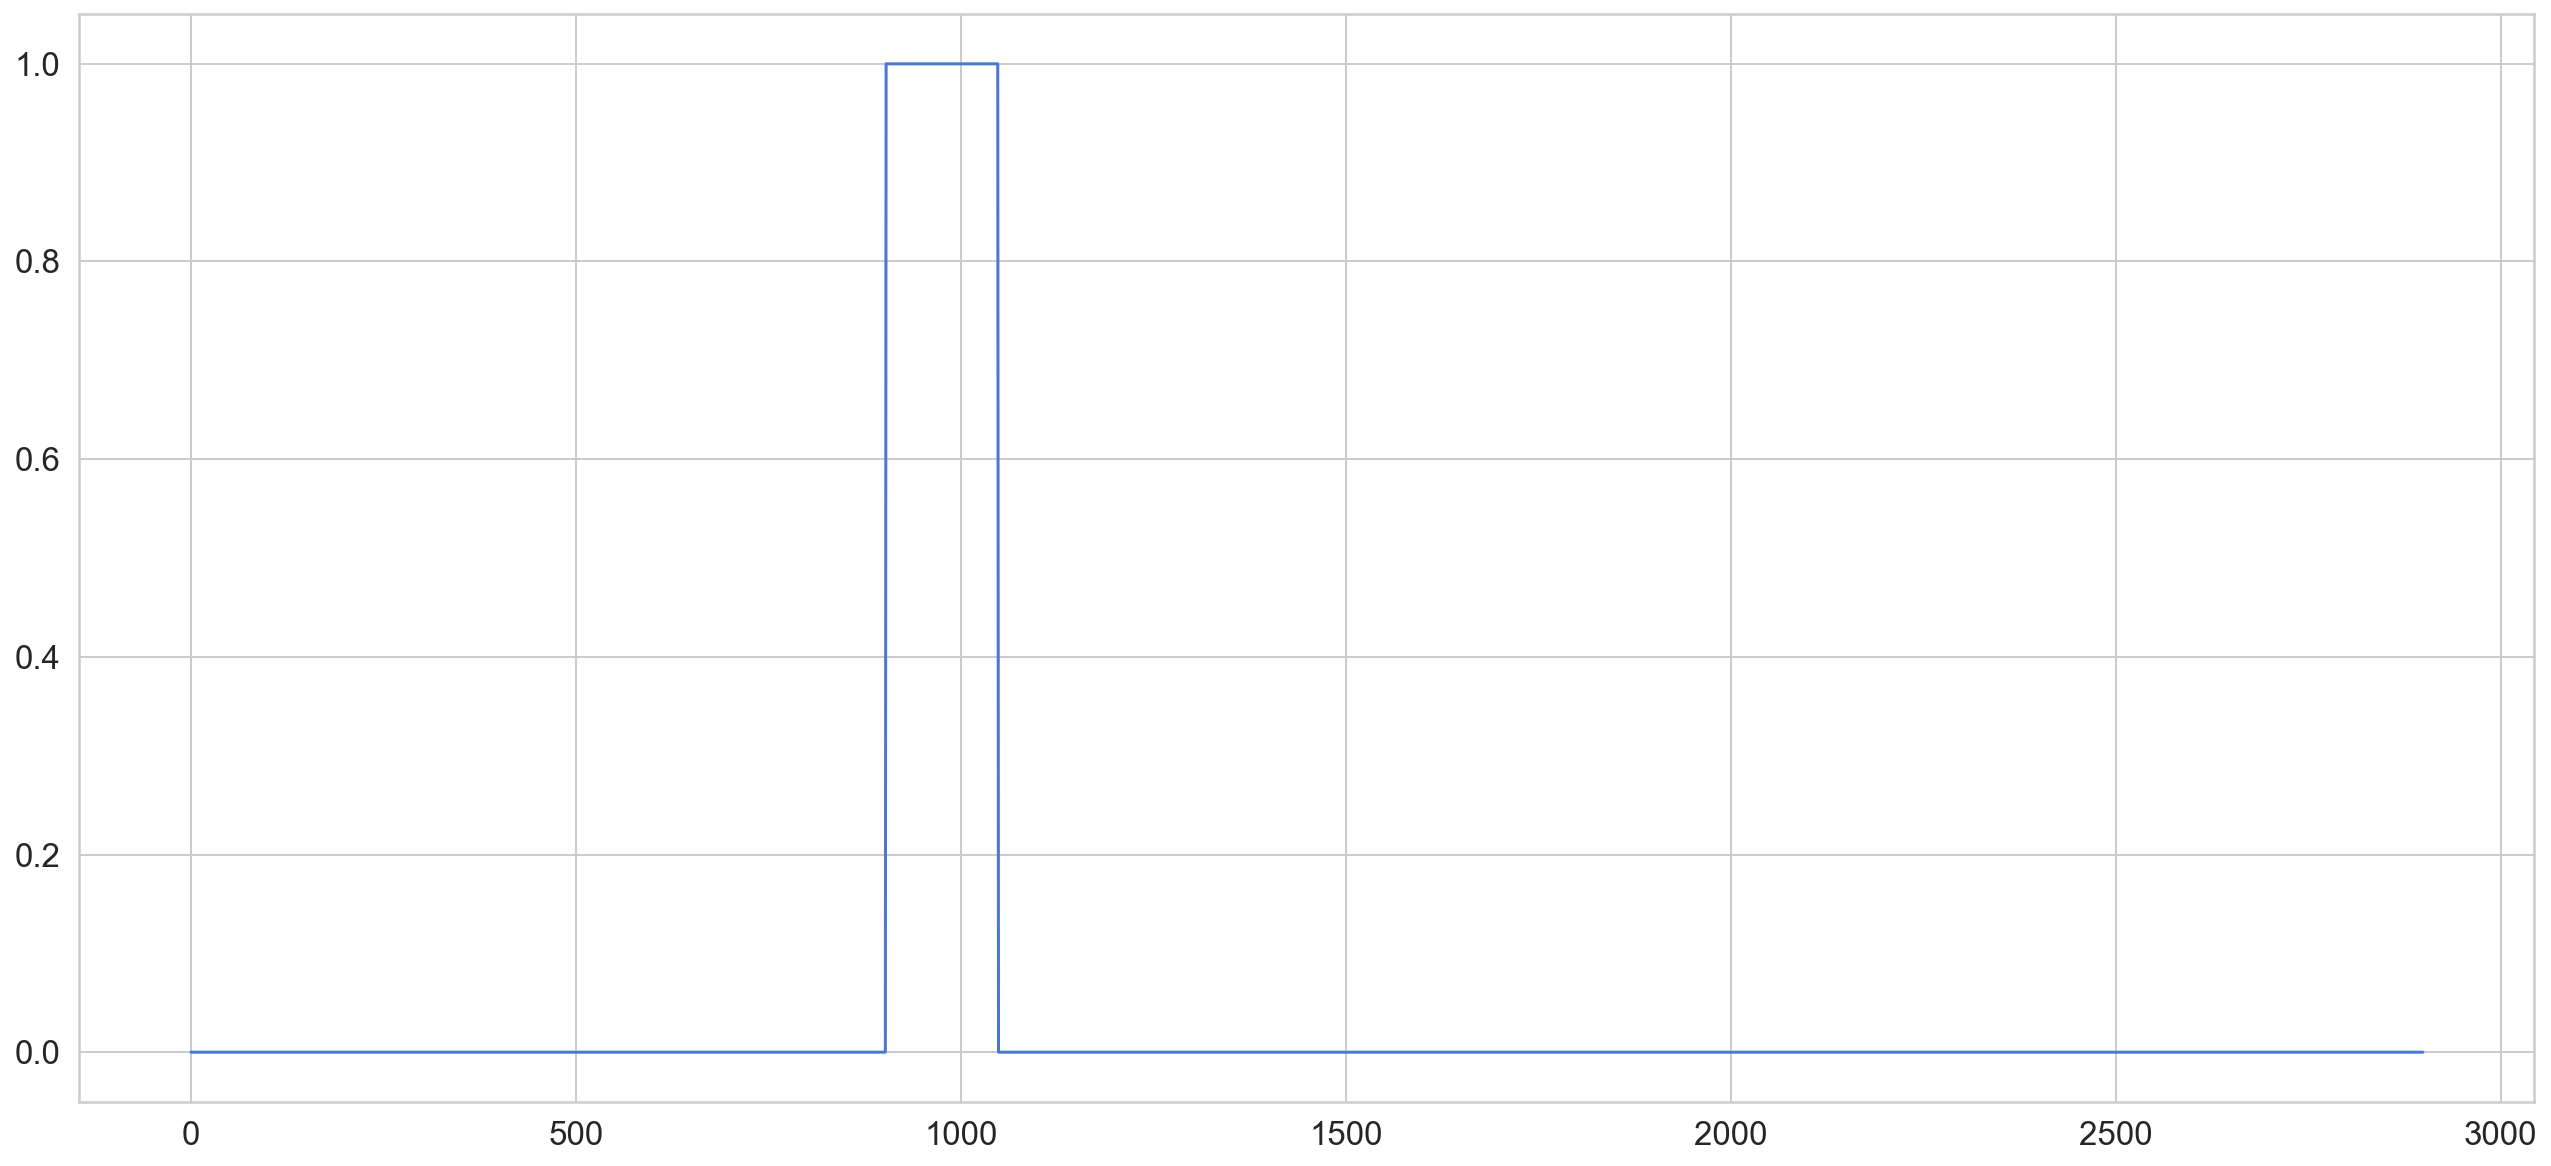

In [24]:
test_cnn = create_dataset_cnn(test,TIME_STEPS)
pre = model_cnn.predict(test_cnn)
re = pre.argmax(axis = 1)
print(np.where(re==1))
plt.plot(re)

In [25]:
test_resample = spline_resampling(test.flatten(),100000)
test_dt = scaler.transform(test_resample.reshape(len(test_resample),1))
X_test, y_test = create_dataset(test_dt, test_dt, TIME_STEPS)
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

3122/3122 [==============================] - 22s 7ms/step


In [26]:
mae_resample = spline_resampling(test_mae_loss.flatten(), 3000)

In [27]:
test = spline_resampling(test.flatten(),3000)
test_df = pd.DataFrame(index = np.arange(len(mae_resample)-TIME_STEPS))
test_df["loss"] = mae_resample[:len(test)-TIME_STEPS]
test_df["cnn_predict"] = re
test_df["higher_threshold"] = THRESHOLD_HIGH
test_df["anomaly_AE"] = np.where(
    test_df.loss > test_df.higher_threshold,
    True,
    False
)
test_df["cnn"] = np.where(
    test_df.cnn_predict == 1,
    True,
    False
)
test_df["anomaly"] = np.where(
    (test_df.loss > test_df.higher_threshold) & (test_df.cnn_predict == 1),
    True,
    False
)
test_df["signal"] = test[:len(test)-TIME_STEPS]

In [28]:
test_df

loss  cnn_predict  higher_threshold  anomaly_AE    cnn  anomaly  \
0     0.207487            0          2.169728       False  False    False   
1     0.190172            0          2.169728       False  False    False   
2     0.207101            0          2.169728       False  False    False   
3     0.249290            0          2.169728       False  False    False   
4     0.292165            0          2.169728       False  False    False   
...        ...          ...               ...         ...    ...      ...   
2895  0.198008            0          2.169728       False  False    False   
2896  0.196649            0          2.169728       False  False    False   
2897  0.200665            0          2.169728       False  False    False   
2898  0.191229            0          2.169728       False  False    False   
2899  0.375556            0          2.169728       False  False    False   

        signal  
0    -0.002199  
1    -0.001871  
2    -0.001542  
3    -0.001871  
4    -0.002199  
...        ...  
2895 -0.001542  
2896 -0.001871  
2897 -0.001871  
2898 -0.005488  
2899 -0.003186  

[2900 rows x 7 columns]

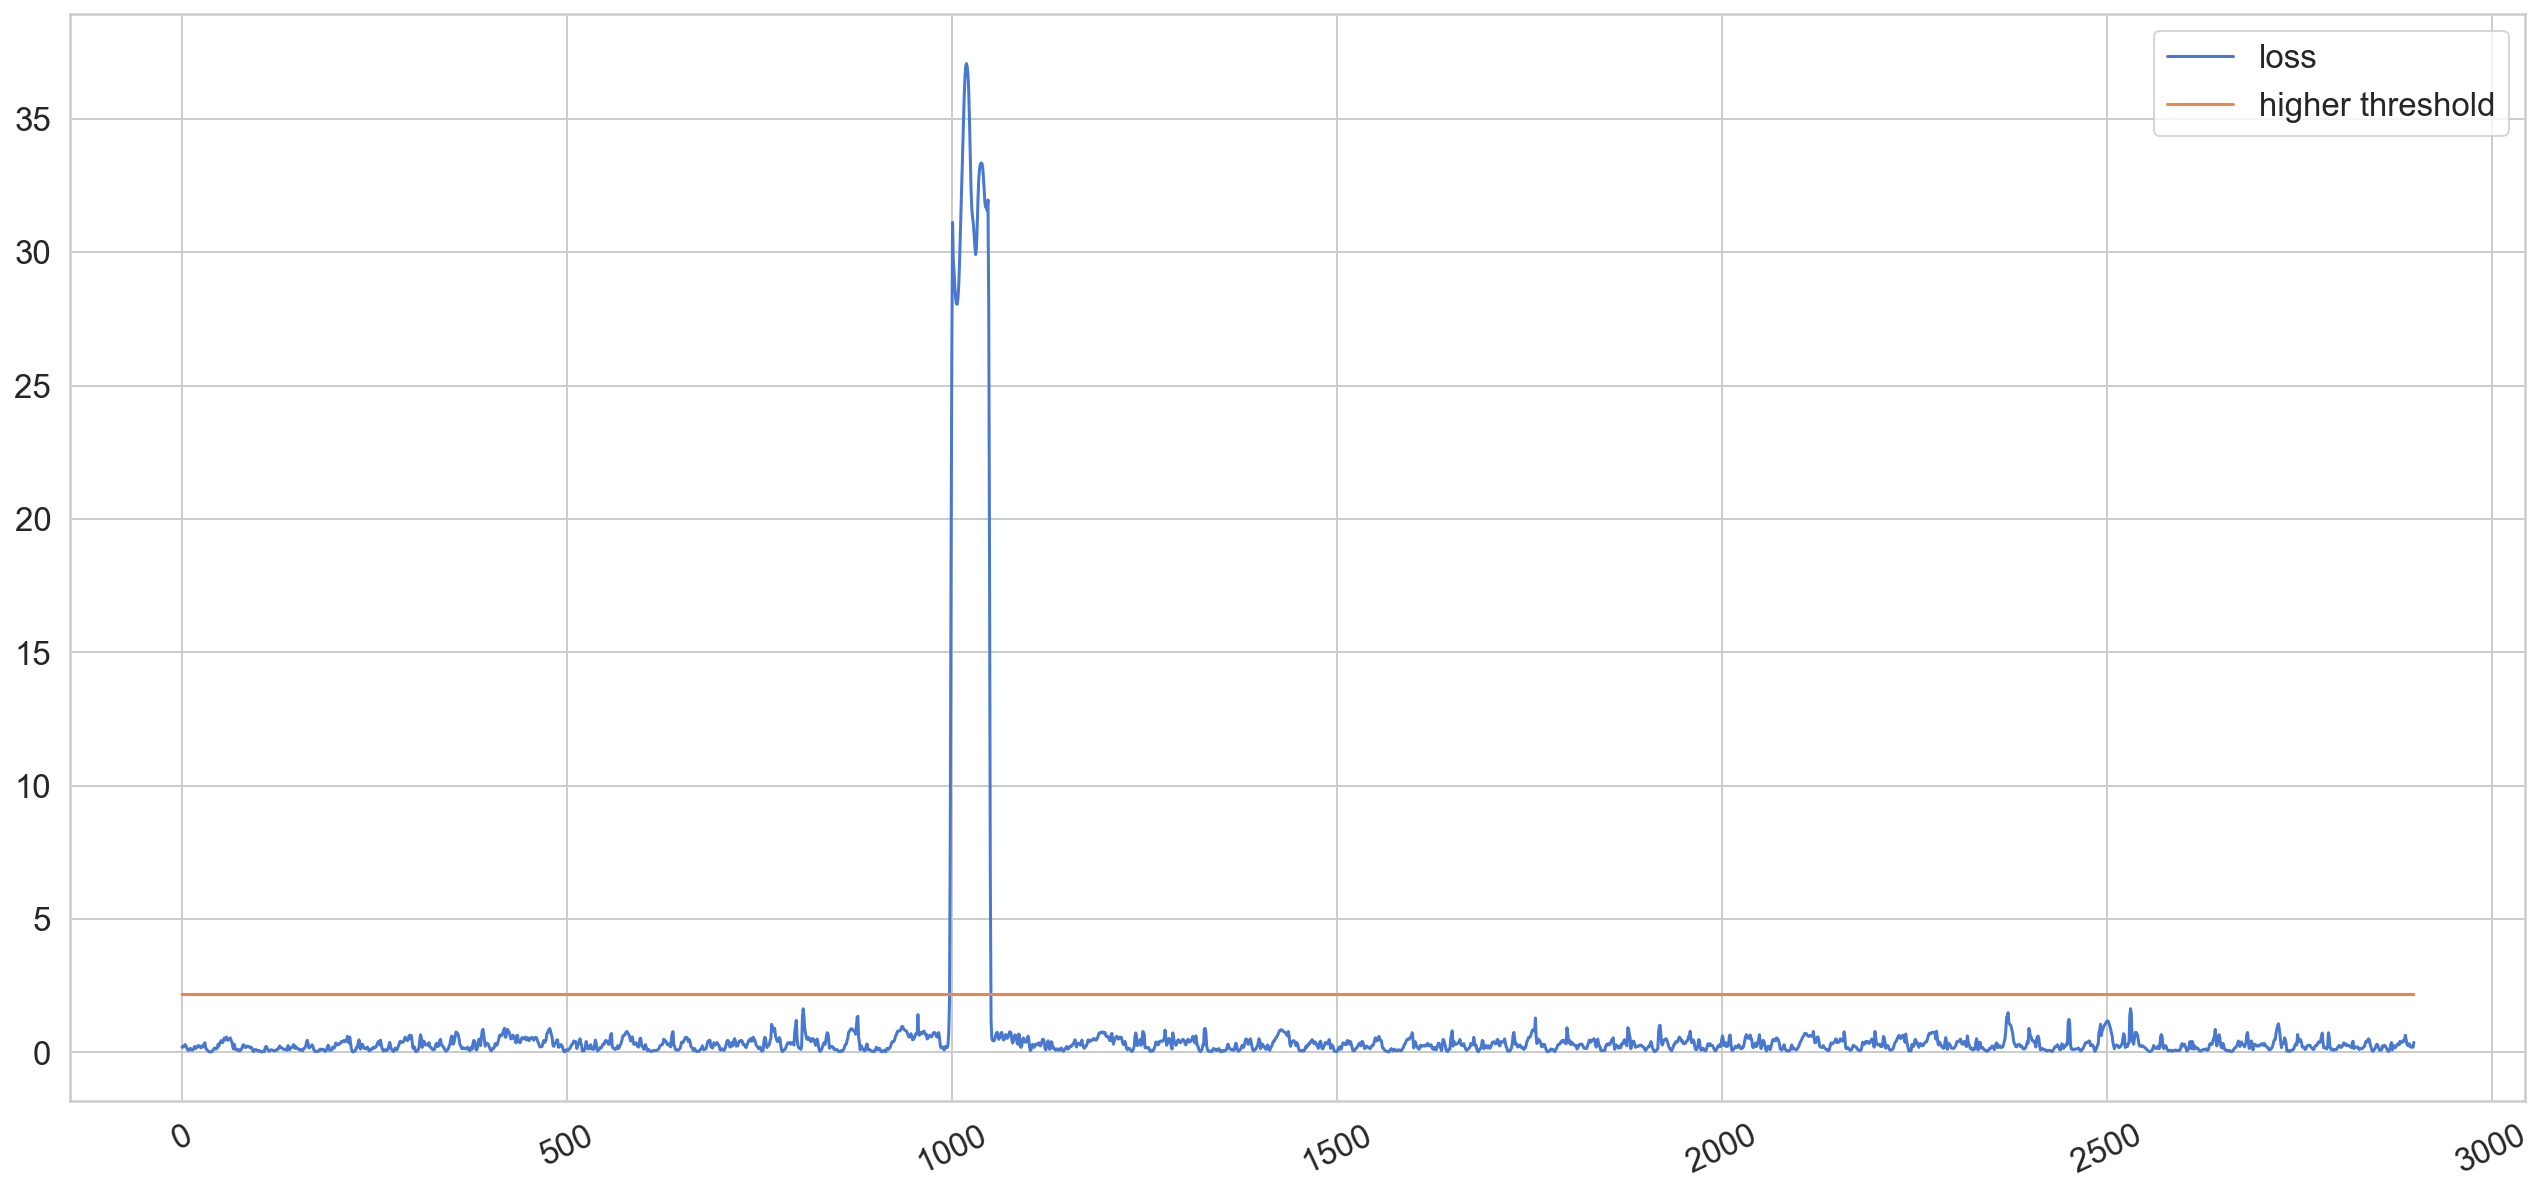

In [29]:
plt.plot(test_df.index, test_df.loss, label='loss')
plt.plot(test_df.index, test_df.higher_threshold, label='higher threshold')
# plt.plot(test_df.index, test_df.lower_threshold, label='lower threshold')
plt.xticks(rotation=25)
plt.legend()

In [30]:
anomalies = test_df[test_df.anomaly == True]
anomalies

loss  cnn_predict  higher_threshold  anomaly_AE   cnn  anomaly  \
998    7.917789            1          2.169728        True  True     True   
999   18.051136            1          2.169728        True  True     True   
1000  25.982923            1          2.169728        True  True     True   
1001  31.122488            1          2.169728        True  True     True   
1002  29.681750            1          2.169728        True  True     True   
1003  29.239999            1          2.169728        True  True     True   
1004  28.657834            1          2.169728        True  True     True   
1005  28.270657            1          2.169728        True  True     True   
1006  28.073563            1          2.169728        True  True     True   
1007  28.044381            1          2.169728        True  True     True   
1008  28.256571            1          2.169728        True  True     True   
1009  28.734500            1          2.169728        True  True     True   
1010  29.537745            1          2.169728        True  True     True   
1011  30.561340            1          2.169728        True  True     True   
1012  31.609826            1          2.169728        True  True     True   
1013  32.644447            1          2.169728        True  True     True   
1014  33.661718            1          2.169728        True  True     True   
1015  34.720948            1          2.169728        True  True     True   
1016  35.727741            1          2.169728        True  True     True   
1017  36.524570            1          2.169728        True  True     True   
1018  36.963125            1          2.169728        True  True     True   
1019  37.073220            1          2.169728        True  True     True   
1020  36.958849            1          2.169728        True  True     True   
1021  36.667864            1          2.169728        True  True     True   
1022  36.030711            1          2.169728        True  True     True   
1023  34.935337            1          2.169728        True  True     True   
1024  33.570252            1          2.169728        True  True     True   
1025  32.357706            1          2.169728        True  True     True   
1026  31.619582            1          2.169728        True  True     True   
1027  31.295330            1          2.169728        True  True     True   
1028  31.068231            1          2.169728        True  True     True   
1029  30.683518            1          2.169728        True  True     True   
1030  30.194628            1          2.169728        True  True     True   
1031  29.914407            1          2.169728        True  True     True   
1032  30.170369            1          2.169728        True  True     True   
1033  30.951789            1          2.169728        True  True     True   
1034  31.949792            1          2.169728        True  True     True   
1035  32.723464            1          2.169728        True  True     True   
1036  33.107917            1          2.169728        True  True     True   
1037  33.299128            1          2.169728        True  True     True   
1038  33.346786            1          2.169728        True  True     True   
1039  33.337350            1          2.169728        True  True     True   
1040  33.209217            1          2.169728        True  True     True   
1041  32.860123            1          2.169728        True  True     True   
1042  32.371898            1          2.169728        True  True     True   
1043  31.861443            1          2.169728        True  True     True   
1044  31.689950            1          2.169728        True  True     True   
1045  31.785928            1          2.169728        True  True     True   
1046  31.570213            1          2.169728        True  True     True   
1047  31.962322            1          2.169728        True  True     True   
1048  27.760119            1          2.169728        True  True     True   

      

In [31]:
anomalies_ae = test_df[test_df.anomaly_AE == True]
anomalies_ae

loss  cnn_predict  higher_threshold  anomaly_AE    cnn  anomaly  \
998    7.917789            1          2.169728        True   True     True   
999   18.051136            1          2.169728        True   True     True   
1000  25.982923            1          2.169728        True   True     True   
1001  31.122488            1          2.169728        True   True     True   
1002  29.681750            1          2.169728        True   True     True   
1003  29.239999            1          2.169728        True   True     True   
1004  28.657834            1          2.169728        True   True     True   
1005  28.270657            1          2.169728        True   True     True   
1006  28.073563            1          2.169728        True   True     True   
1007  28.044381            1          2.169728        True   True     True   
1008  28.256571            1          2.169728        True   True     True   
1009  28.734500            1          2.169728        True   True     True   
1010  29.537745            1          2.169728        True   True     True   
1011  30.561340            1          2.169728        True   True     True   
1012  31.609826            1          2.169728        True   True     True   
1013  32.644447            1          2.169728        True   True     True   
1014  33.661718            1          2.169728        True   True     True   
1015  34.720948            1          2.169728        True   True     True   
1016  35.727741            1          2.169728        True   True     True   
1017  36.524570            1          2.169728        True   True     True   
1018  36.963125            1          2.169728        True   True     True   
1019  37.073220            1          2.169728        True   True     True   
1020  36.958849            1          2.169728        True   True     True   
1021  36.667864            1          2.169728        True   True     True   
1022  36.030711            1          2.169728        True   True     True   
1023  34.935337            1          2.169728        True   True     True   
1024  33.570252            1          2.169728        True   True     True   
1025  32.357706            1          2.169728        True   True     True   
1026  31.619582            1          2.169728        True   True     True   
1027  31.295330            1          2.169728        True   True     True   
1028  31.068231            1          2.169728        True   True     True   
1029  30.683518            1          2.169728        True   True     True   
1030  30.194628            1          2.169728        True   True     True   
1031  29.914407            1          2.169728        True   True     True   
1032  30.170369            1          2.169728        True   True     True   
1033  30.951789            1          2.169728        True   True     True   
1034  31.949792            1          2.169728        True   True     True   
1035  32.723464            1          2.169728        True   True     True   
1036  33.107917            1          2.169728        True   True     True   
1037  33.299128            1          2.169728        True   True     True   
1038  33.346786            1          2.169728        True   True     True   
1039  33.337350            1          2.169728        True   True     True   
1040  33.209217            1          2.169728        True   True     True   
1041  32.860123            1          2.169728        True   True     True   
1042  32.371898            1          2.169728        True   True     True   
1043  31.861443            1          2.169728        True   True     True   
1044  31.689950            1          2.169728        True   True     True   
1045  31.785928            1          2.169728        True   True     True   
1046  31.570213            1          2.169728        True   True     True   
1047  31.962322            1          2.169728        True   True     True   
1048  27.760119            1     

In [32]:
anomalies_cnn = test_df[test_df.cnn == True]
anomalies_cnn

loss  cnn_predict  higher_threshold  anomaly_AE   cnn  anomaly  \
903    0.129747            1          2.169728       False  True    False   
904    0.100227            1          2.169728       False  True    False   
905    0.110846            1          2.169728       False  True    False   
906    0.156542            1          2.169728       False  True    False   
907    0.099948            1          2.169728       False  True    False   
...         ...          ...               ...         ...   ...      ...   
1044  31.689950            1          2.169728        True  True     True   
1045  31.785928            1          2.169728        True  True     True   
1046  31.570213            1          2.169728        True  True     True   
1047  31.962322            1          2.169728        True  True     True   
1048  27.760119            1          2.169728        True  True     True   

        signal  
903   0.002076  
904   0.001418  
905   0.001747  
906   0.001747  
907   0.001747  
...        ...  
1044  0.233584  
1045  0.234570  
1046  0.236215  
1047  0.234570  
1048  0.230953  

[146 rows x 7 columns]

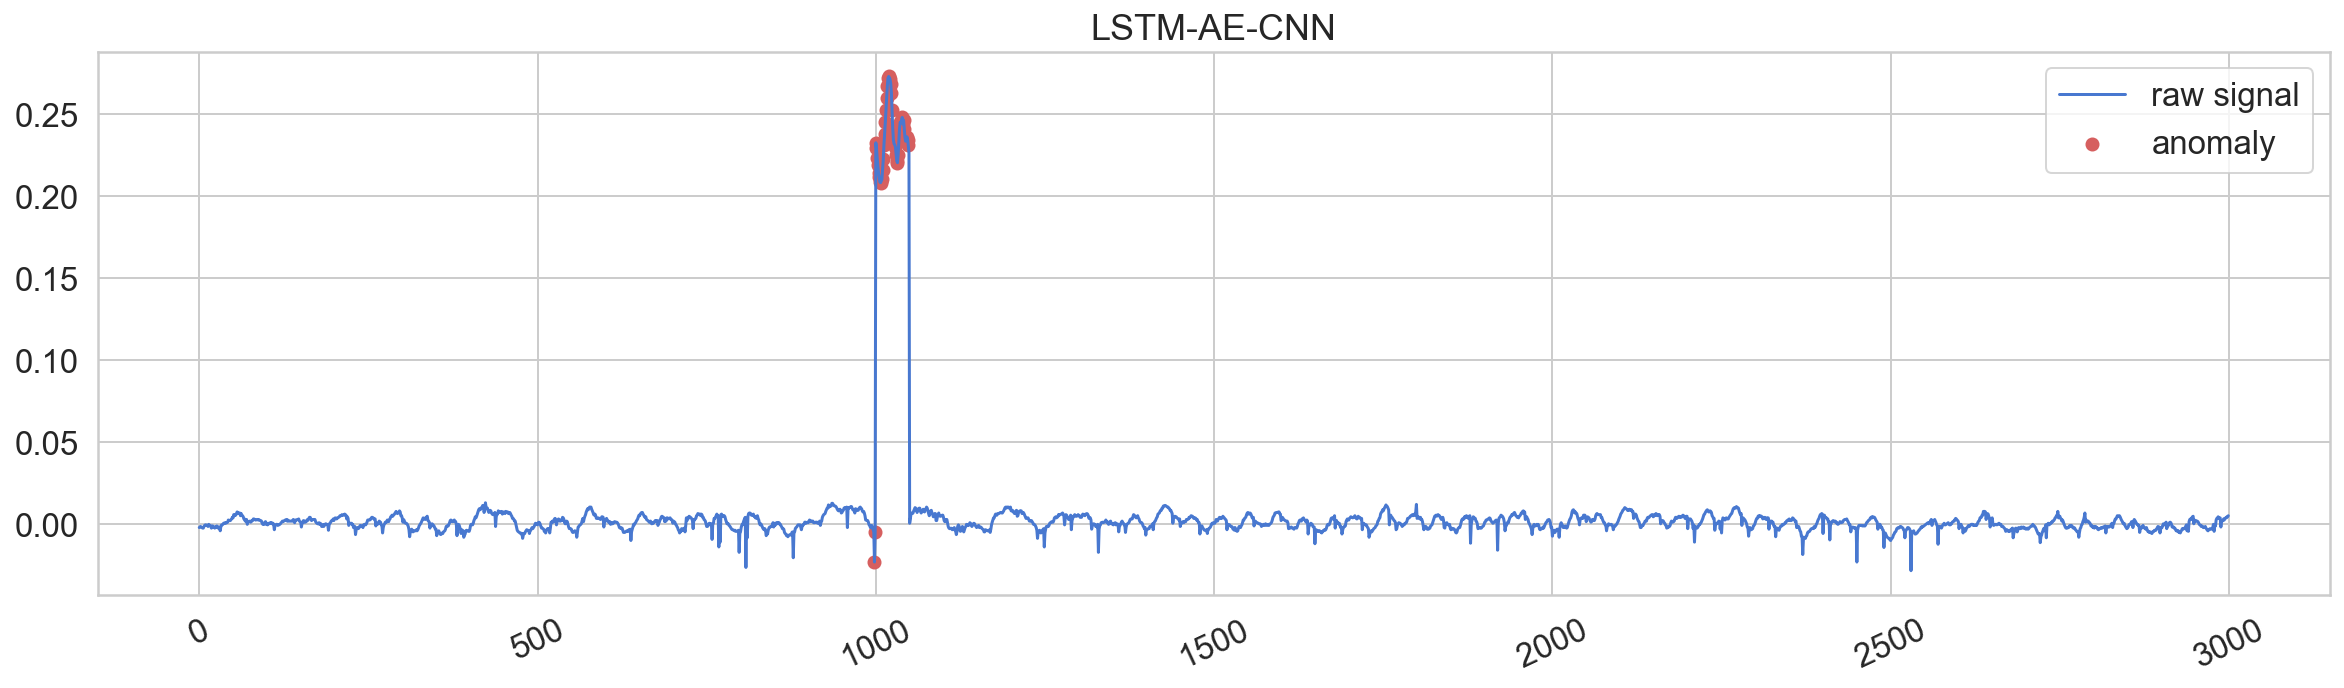

In [33]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies.index,
  np.array(anomalies.signal).reshape(len(anomalies.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("LSTM-AE-CNN")
plt.xticks(rotation=25)
plt.legend()

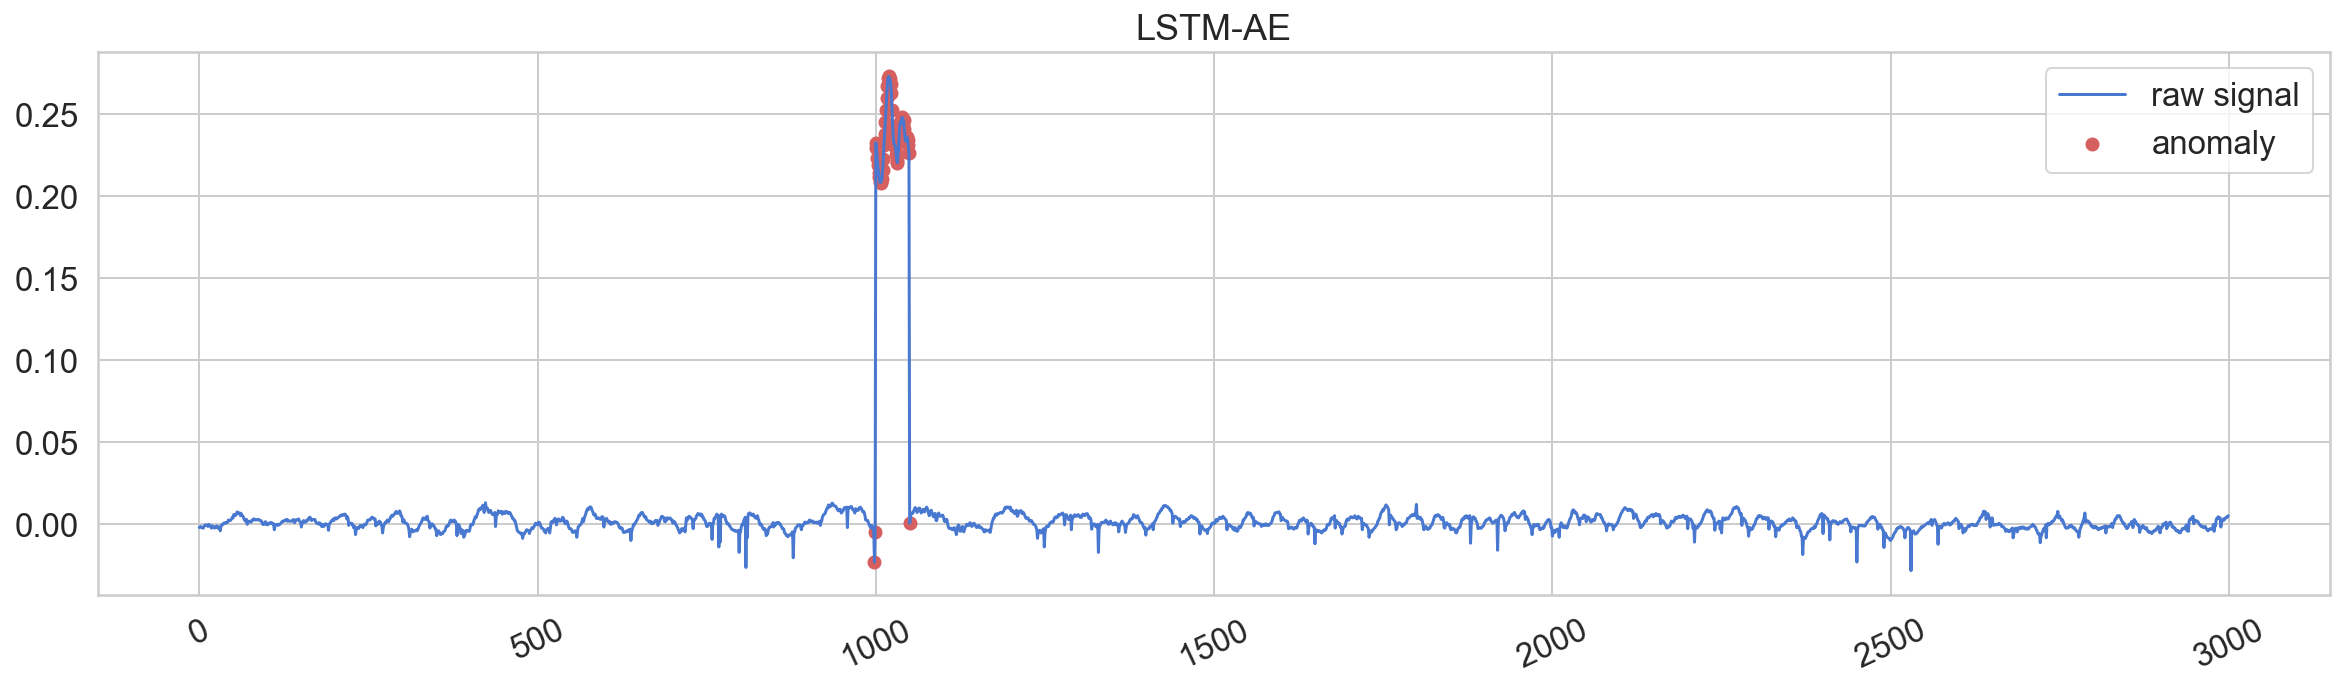

In [34]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies_ae.index,
  np.array(anomalies_ae.signal).reshape(len(anomalies_ae.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("LSTM-AE")
plt.xticks(rotation=25)
plt.legend()

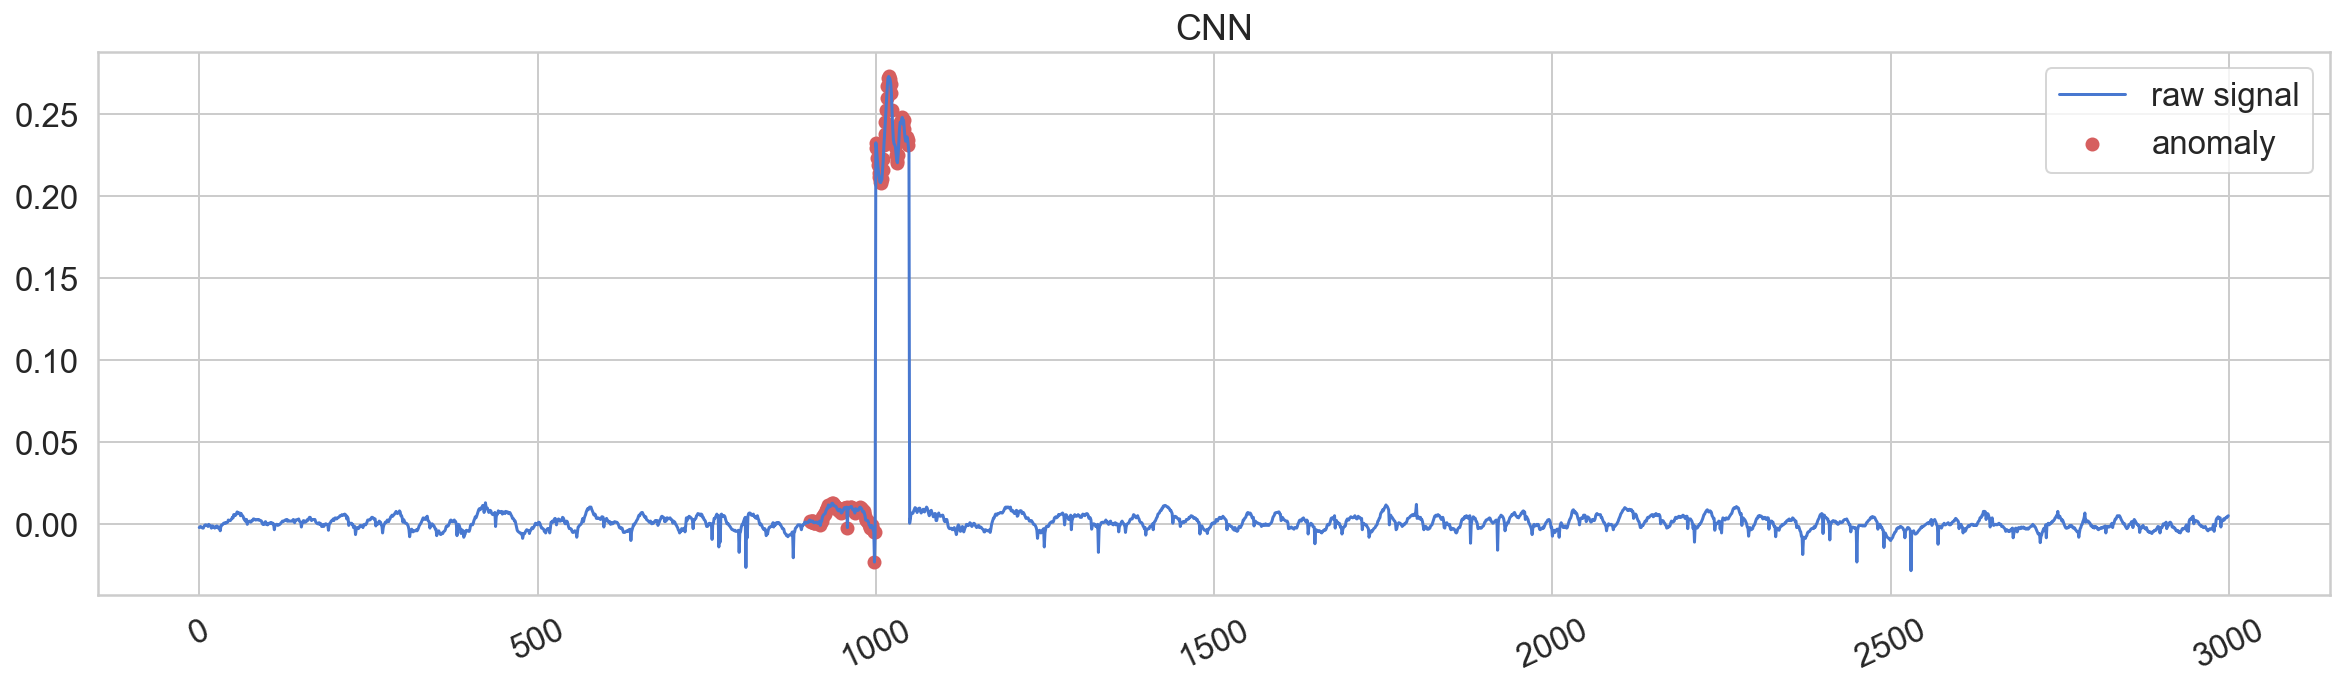

In [35]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies_cnn.index,
  np.array(anomalies_cnn.signal).reshape(len(anomalies_cnn.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("CNN")
plt.xticks(rotation=25)
plt.legend()

### Test 2: Outer fault

In [36]:
kbth = scipy.io.loadmat('Data/outer_fault/O-D-3.mat')

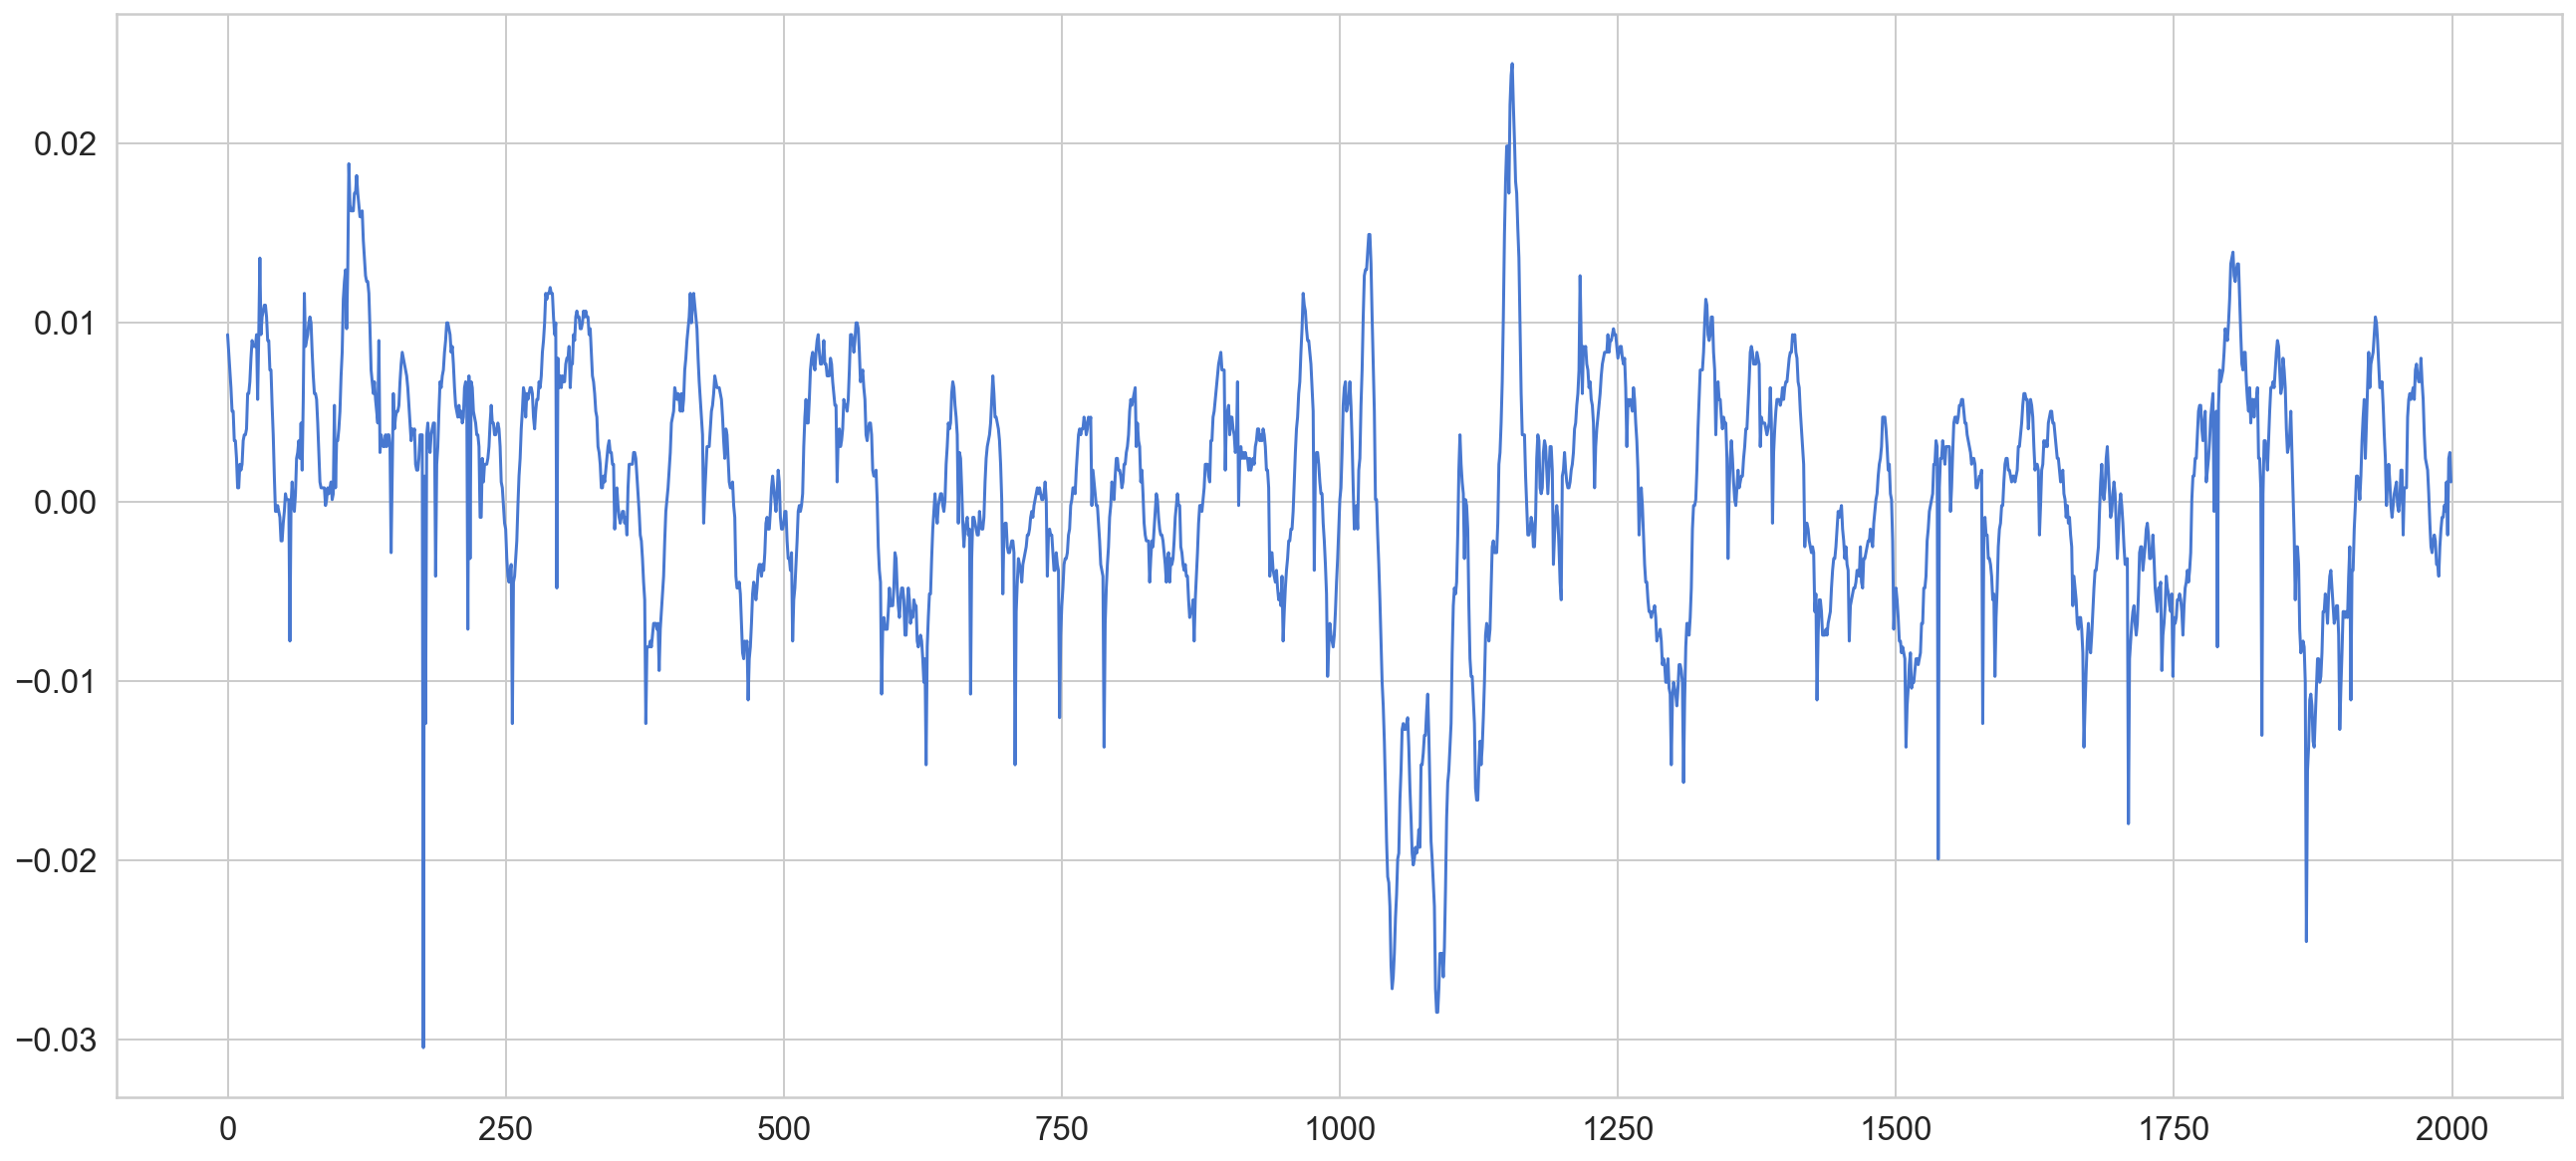

In [37]:
test = data2[178000:180000]
test[1000:1200] = kbth["Channel_1"][100000:100200]
plt.plot(test)

60/60 [==============================] - 1s 11ms/step
(array([ 929,  930,  931,  932,  933,  934,  935,  936,  937,  938,  939,
        940,  941,  942,  943,  944,  945,  946,  947,  948,  949,  950,
        951,  952,  953,  954,  955,  956,  957,  958,  959,  960,  961,
        962,  963,  964,  965,  966,  967,  968,  969,  970,  971,  972,
        973,  974,  975,  976,  977,  978,  979,  980,  981,  982,  983,
        984,  985,  986,  987,  988,  989,  990,  991,  992,  993,  994,
        995,  996,  997,  998,  999, 1000, 1001, 1002, 1003, 1004, 1005,
       1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016,
       1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027,
       1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038,
       1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049,
       1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060,
       1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 10

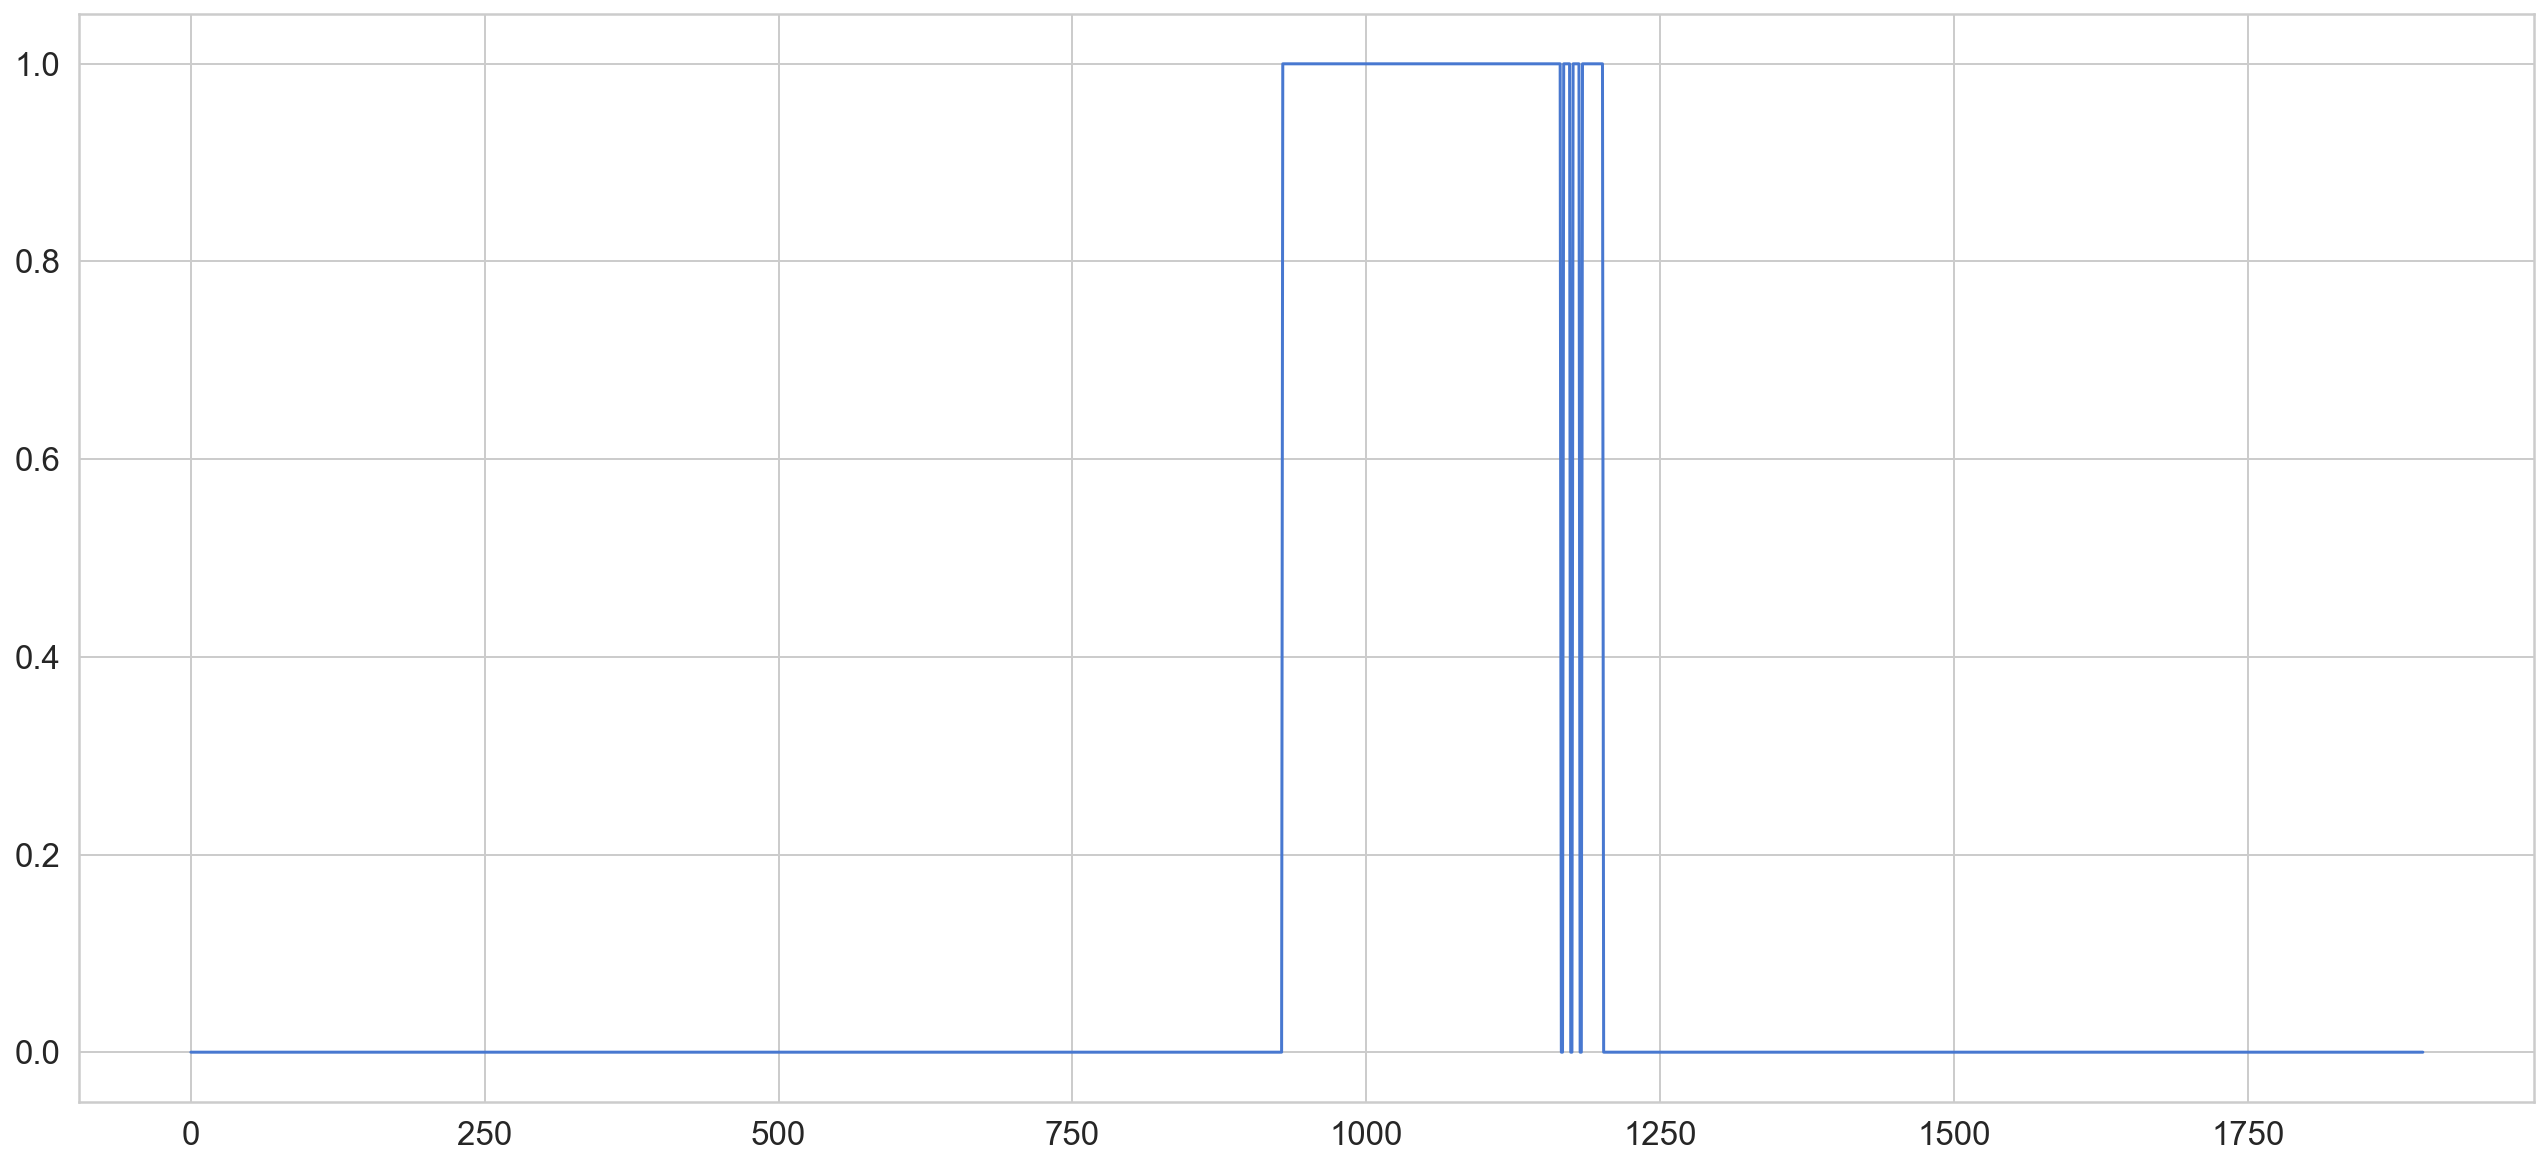

In [38]:
test_cnn = create_dataset_cnn(test,TIME_STEPS)
pre = model_cnn.predict(test_cnn)
re = pre.argmax(axis = 1)
print(np.where(re==1))
plt.plot(re)

In [39]:
test_resample = spline_resampling(test.flatten(),100000)
test_dt = scaler.transform(test_resample.reshape(len(test_resample),1))
X_test, y_test = create_dataset(test_dt, test_dt, TIME_STEPS)
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

3122/3122 [==============================] - 22s 7ms/step


In [40]:
mae_resample = spline_resampling(test_mae_loss.flatten(), 2000)

In [41]:
test = spline_resampling(test.flatten(),2000)
test_df = pd.DataFrame(index = np.arange(len(mae_resample)-TIME_STEPS))
test_df["loss"] = mae_resample[:len(test)-TIME_STEPS]
test_df["cnn_predict"] = re
test_df["higher_threshold"] = THRESHOLD_HIGH
test_df["anomaly_AE"] = np.where(
    test_df.loss > test_df.higher_threshold,
    True,
    False
)
test_df["cnn"] = np.where(
    test_df.cnn_predict == 1,
    True,
    False
)
test_df["anomaly"] = np.where(
    (test_df.loss > test_df.higher_threshold) & (test_df.cnn_predict == 1),
    True,
    False
)
test_df["signal"] = test[:len(test)-TIME_STEPS]

In [42]:
test_df

loss  cnn_predict  higher_threshold  anomaly_AE    cnn  anomaly  \
0     0.654745            0          2.169728       False  False    False   
1     0.593541            0          2.169728       False  False    False   
2     0.574959            0          2.169728       False  False    False   
3     0.457554            0          2.169728       False  False    False   
4     0.521949            0          2.169728       False  False    False   
...        ...          ...               ...         ...    ...      ...   
1895  0.795655            0          2.169728       False  False    False   
1896  0.794956            0          2.169728       False  False    False   
1897  0.736237            0          2.169728       False  False    False   
1898  0.742583            0          2.169728       False  False    False   
1899  1.013084            0          2.169728       False  False    False   

        signal  
0     0.009310  
1     0.008324  
2     0.007337  
3     0.006351  
4     0.005035  
...        ...  
1895 -0.006474  
1896 -0.005817  
1897 -0.005817  
1898 -0.007461  
1899 -0.012723  

[1900 rows x 7 columns]

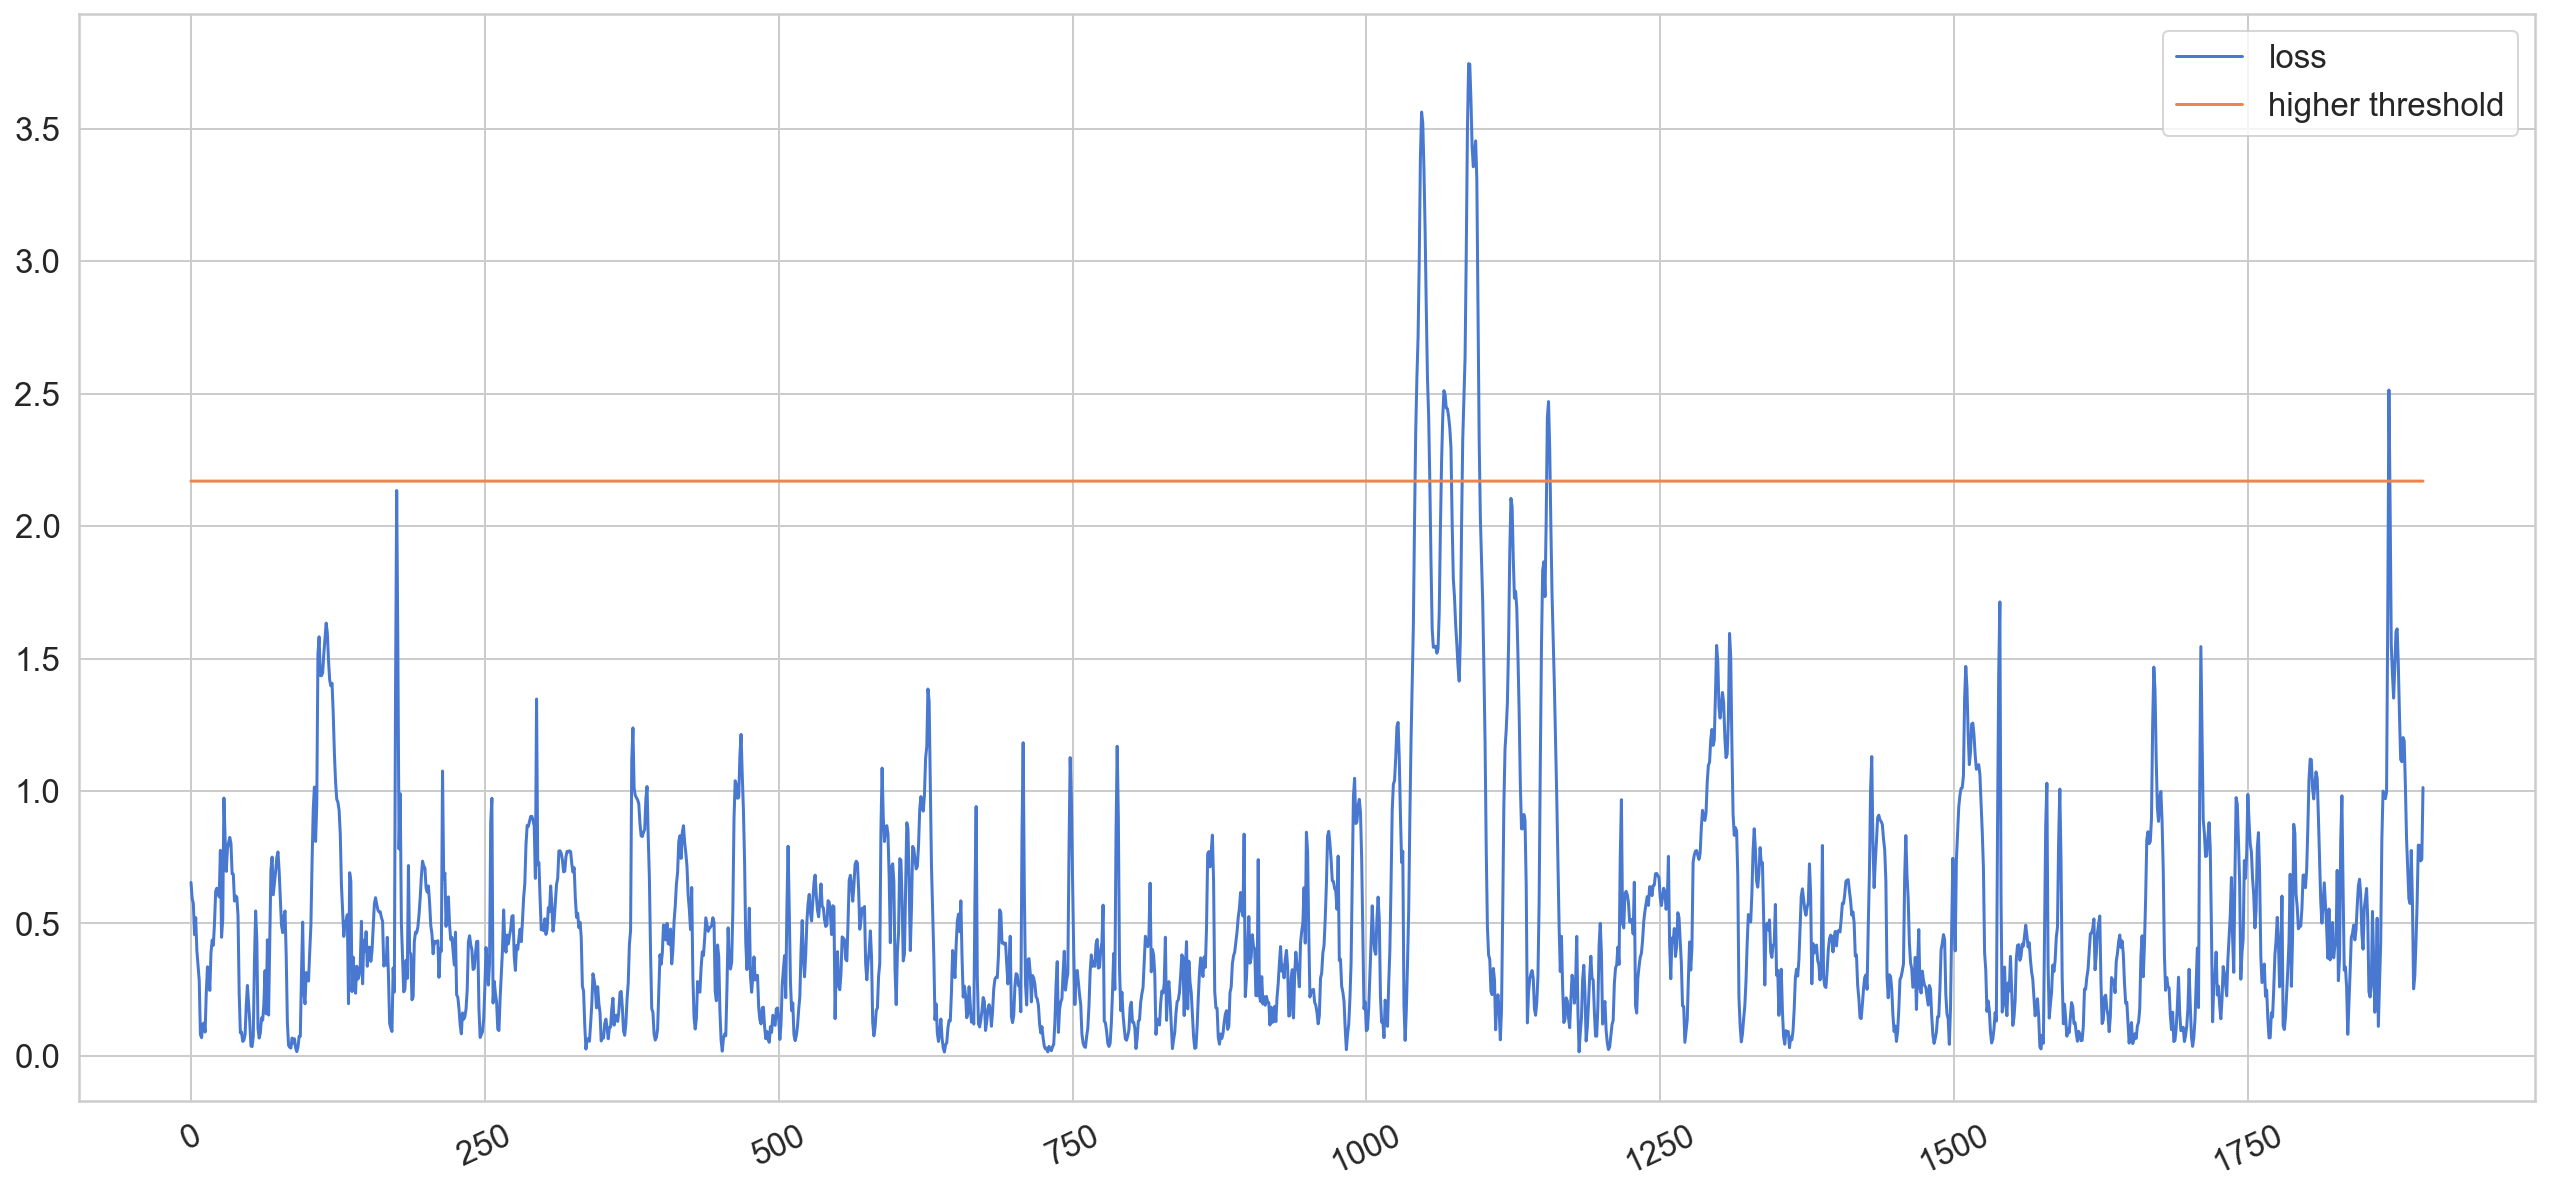

In [43]:
plt.plot(test_df.index, test_df.loss, label='loss')
plt.plot(test_df.index, test_df.higher_threshold, label='higher threshold')
# plt.plot(test_df.index, test_df.lower_threshold, label='lower threshold')
plt.xticks(rotation=25)
plt.legend()

In [44]:
anomalies = test_df[test_df.anomaly == True]
anomalies

loss  cnn_predict  higher_threshold  anomaly_AE   cnn  anomaly  \
1042  2.357791            1          2.169728        True  True     True   
1043  2.559406            1          2.169728        True  True     True   
1044  2.713384            1          2.169728        True  True     True   
1045  3.003361            1          2.169728        True  True     True   
1046  3.395760            1          2.169728        True  True     True   
1047  3.562832            1          2.169728        True  True     True   
1048  3.521042            1          2.169728        True  True     True   
1049  3.348906            1          2.169728        True  True     True   
1050  3.112743            1          2.169728        True  True     True   
1051  2.819184            1          2.169728        True  True     True   
1052  2.557127            1          2.169728        True  True     True   
1053  2.417178            1          2.169728        True  True     True   
1064  2.242203            1          2.169728        True  True     True   
1065  2.412038            1          2.169728        True  True     True   
1066  2.511218            1          2.169728        True  True     True   
1067  2.496758            1          2.169728        True  True     True   
1068  2.445462            1          2.169728        True  True     True   
1069  2.442560            1          2.169728        True  True     True   
1070  2.412942            1          2.169728        True  True     True   
1071  2.369385            1          2.169728        True  True     True   
1072  2.294055            1          2.169728        True  True     True   
1082  2.325404            1          2.169728        True  True     True   
1083  2.486287            1          2.169728        True  True     True   
1084  2.638435            1          2.169728        True  True     True   
1085  3.033515            1          2.169728        True  True     True   
1086  3.498635            1          2.169728        True  True     True   
1087  3.745515            1          2.169728        True  True     True   
1088  3.743447            1          2.169728        True  True     True   
1089  3.605568            1          2.169728        True  True     True   
1090  3.430135            1          2.169728        True  True     True   
1091  3.356125            1          2.169728        True  True     True   
1092  3.406646            1          2.169728        True  True     True   
1093  3.454176            1          2.169728        True  True     True   
1094  3.305766            1          2.169728        True  True     True   
1095  2.824406            1          2.169728        True  True     True   
1096  2.318859            1          2.169728        True  True     True   
1154  2.409970            1          2.169728        True  True     True   
1155  2.469809            1          2.169728        True  True     True   
1156  2.290270            1          2.169728        True  True     True   

        signal  
1042 -0.018971  
1043 -0.020944  
1044 -0.021273  
1045 -0.022588  
1046 -0.025876  
1047 -0.027192  
1048 -0.026534  
1049 -0.025219  
1050 -0.023246  
1051 -0.021930  
1052 -0.019957  
1053 -0.019628  
1064 -0.017655  
1065 -0.019628  
1066 -0.020286  
1067 -0.019957  
1068 -0.019299  
1069 -0.019628  
1070 -0.019299  
1071 -0.018313  
1072 -0.019299  
1082 -0.018971  
1083 -0.019957  
1084 -0.021273  
1085 -0.022588  
1086 -0.027192  
1087 -0.028507  
1088 -0.028507  
1089 -0.027192  
1090 -0.025219  
1091 -0.025219  
1092 -0.025219  
1093 -0.026534  
1094 -0.024890  
1095 -0.021601  
1096 -0.017655  
1154  0.023779  
1155  0.024437  
1156  0.022135

In [45]:
anomalies_ae = test_df[test_df.anomaly_AE == True]
anomalies_ae

loss  cnn_predict  higher_threshold  anomaly_AE    cnn  anomaly  \
1042  2.357791            1          2.169728        True   True     True   
1043  2.559406            1          2.169728        True   True     True   
1044  2.713384            1          2.169728        True   True     True   
1045  3.003361            1          2.169728        True   True     True   
1046  3.395760            1          2.169728        True   True     True   
1047  3.562832            1          2.169728        True   True     True   
1048  3.521042            1          2.169728        True   True     True   
1049  3.348906            1          2.169728        True   True     True   
1050  3.112743            1          2.169728        True   True     True   
1051  2.819184            1          2.169728        True   True     True   
1052  2.557127            1          2.169728        True   True     True   
1053  2.417178            1          2.169728        True   True     True   
1064  2.242203            1          2.169728        True   True     True   
1065  2.412038            1          2.169728        True   True     True   
1066  2.511218            1          2.169728        True   True     True   
1067  2.496758            1          2.169728        True   True     True   
1068  2.445462            1          2.169728        True   True     True   
1069  2.442560            1          2.169728        True   True     True   
1070  2.412942            1          2.169728        True   True     True   
1071  2.369385            1          2.169728        True   True     True   
1072  2.294055            1          2.169728        True   True     True   
1082  2.325404            1          2.169728        True   True     True   
1083  2.486287            1          2.169728        True   True     True   
1084  2.638435            1          2.169728        True   True     True   
1085  3.033515            1          2.169728        True   True     True   
1086  3.498635            1          2.169728        True   True     True   
1087  3.745515            1          2.169728        True   True     True   
1088  3.743447            1          2.169728        True   True     True   
1089  3.605568            1          2.169728        True   True     True   
1090  3.430135            1          2.169728        True   True     True   
1091  3.356125            1          2.169728        True   True     True   
1092  3.406646            1          2.169728        True   True     True   
1093  3.454176            1          2.169728        True   True     True   
1094  3.305766            1          2.169728        True   True     True   
1095  2.824406            1          2.169728        True   True     True   
1096  2.318859            1          2.169728        True   True     True   
1154  2.409970            1          2.169728        True   True     True   
1155  2.469809            1          2.169728        True   True     True   
1156  2.290270            1          2.169728        True   True     True   
1870  2.513608            0          2.169728        True  False    False   

        signal  
1042 -0.018971  
1043 -0.020944  
1044 -0.021273  
1045 -0.022588  
1046 -0.025876  
1047 -0.027192  
1048 -0.026534  
1049 -0.025219  
1050 -0.023246  
1051 -0.021930  
1052 -0.019957  
1053 -0.019628  
1064 -0.017655  
1065 -0.019628  
1066 -0.020286  
1067 -0.019957  
1068 -0.019299  
1069 -0.019628  
1070 -0.019299  
1071 -0.018313  
1072 -0.019299  
1082 -0.018971  
1083 -0.019957  
1084 -0.021273  
1085 -0.022588  
1086 -0.027192  
1087 -0.028507  
1088 -0.028507  
1089 -0.027192  
1090 -0.025219  
1091 -0.025219  
1092 -0.025219  
1093 -0.026534  
1094 -0.024890  
1095 -0.021601  
1096 -0.017655  
1154  0.023779  
1155  0.024437  
1156  0.022135  
1870 -0.015024

In [46]:
anomalies_cnn = test_df[test_df.cnn == True]
anomalies_cnn

loss  cnn_predict  higher_threshold  anomaly_AE   cnn  anomaly  \
929   0.342761            1          2.169728       False  True    False   
930   0.294677            1          2.169728       False  True    False   
931   0.364121            1          2.169728       False  True    False   
932   0.398347            1          2.169728       False  True    False   
933   0.337091            1          2.169728       False  True    False   
...        ...          ...               ...         ...   ...      ...   
1197  0.189211            1          2.169728       False  True    False   
1198  0.415581            1          2.169728       False  True    False   
1199  0.500290            1          2.169728       False  True    False   
1200  0.385965            1          2.169728       False  True    False   
1201  0.120251            1          2.169728       False  True    False   

        signal  
929   0.003720  
930   0.003391  
931   0.004049  
932   0.003720  
933   0.003062  
...        ...  
1197 -0.002528  
1198 -0.004501  
1199 -0.005488  
1200  0.001418  
1201  0.001747  

[267 rows x 7 columns]

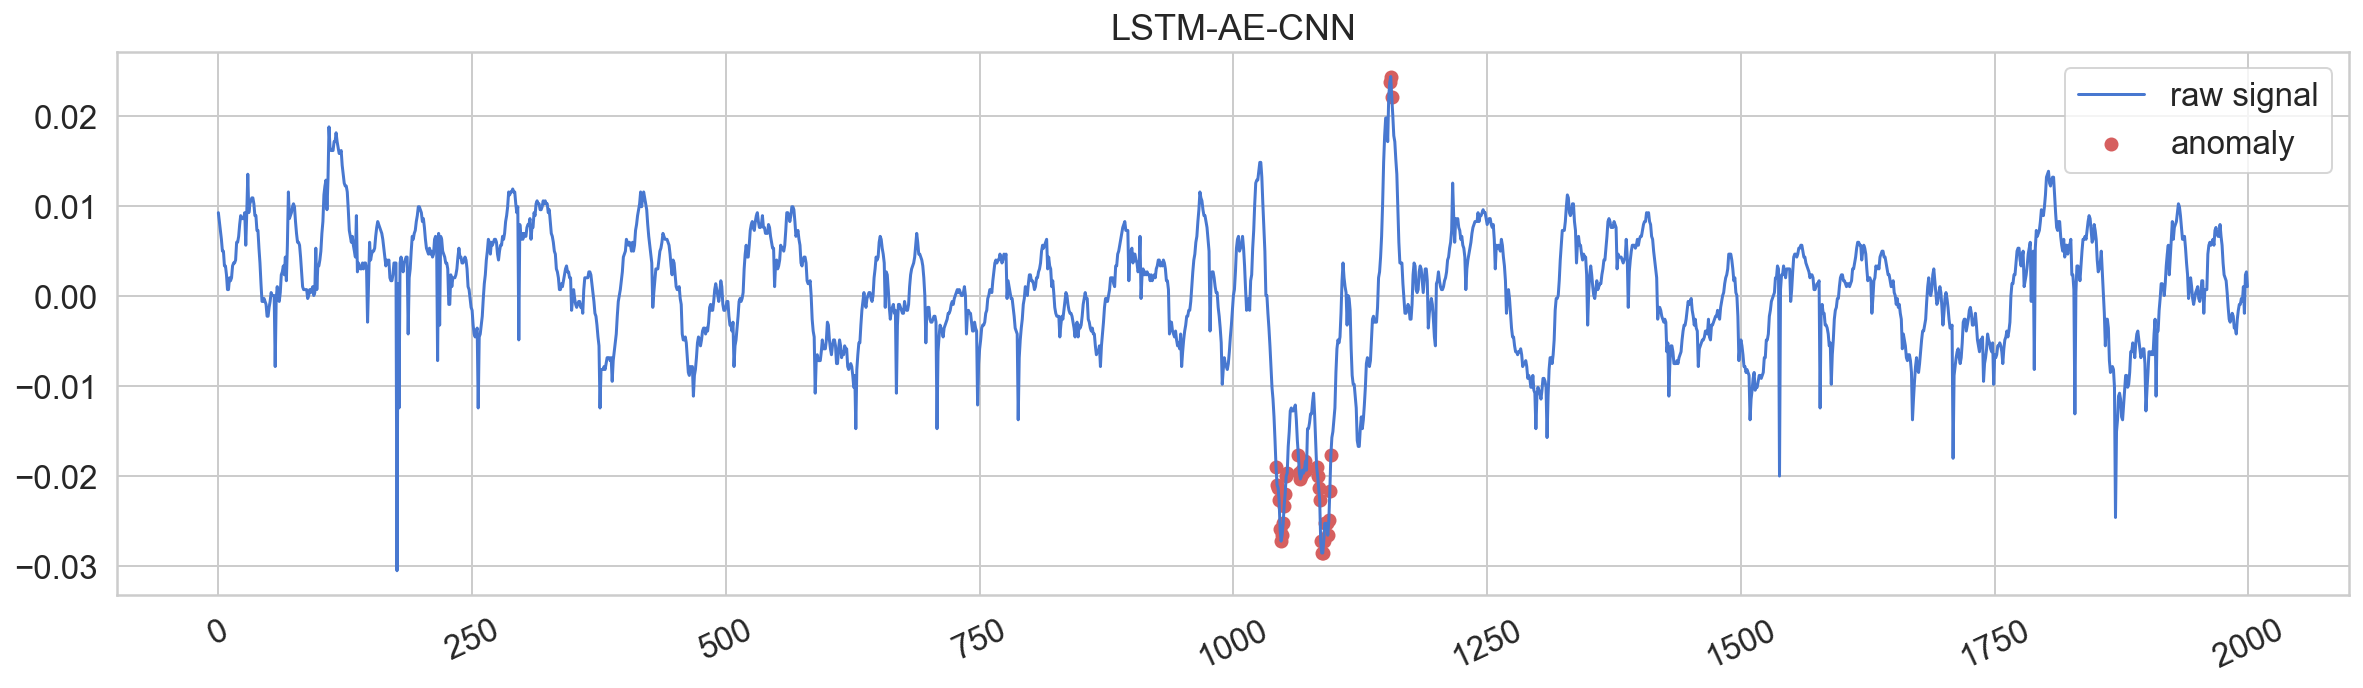

In [47]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies.index,
  np.array(anomalies.signal).reshape(len(anomalies.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("LSTM-AE-CNN")
plt.xticks(rotation=25)
plt.legend()

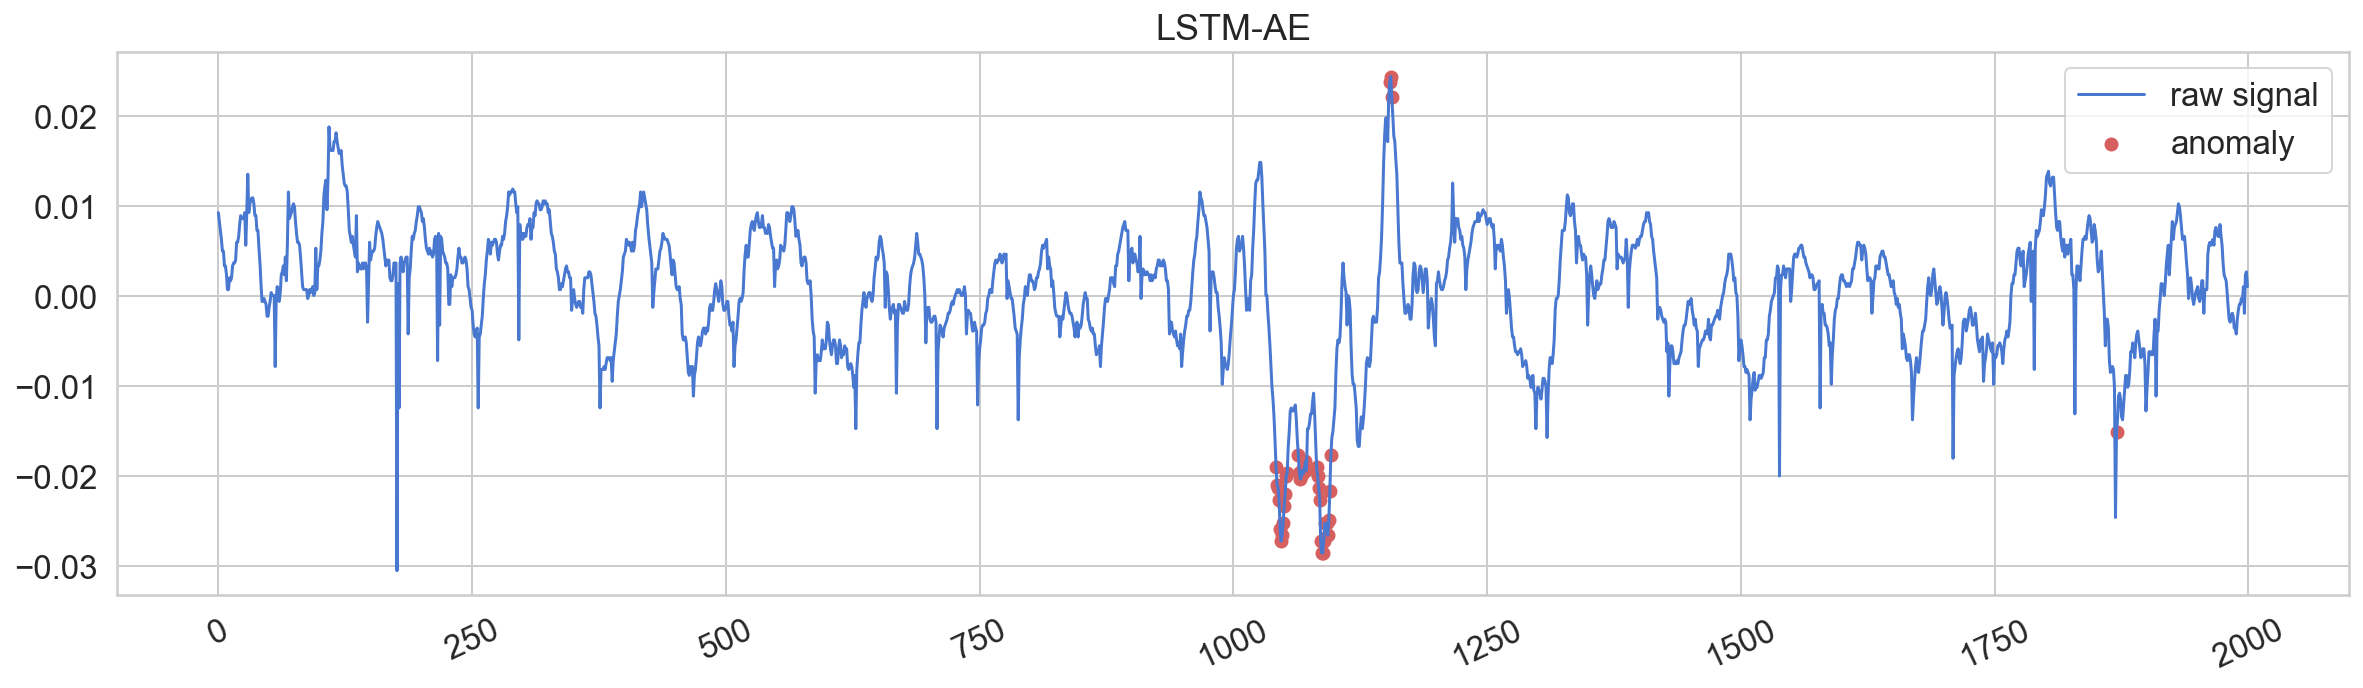

In [48]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies_ae.index,
  np.array(anomalies_ae.signal).reshape(len(anomalies_ae.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("LSTM-AE")
plt.xticks(rotation=25)
plt.legend()

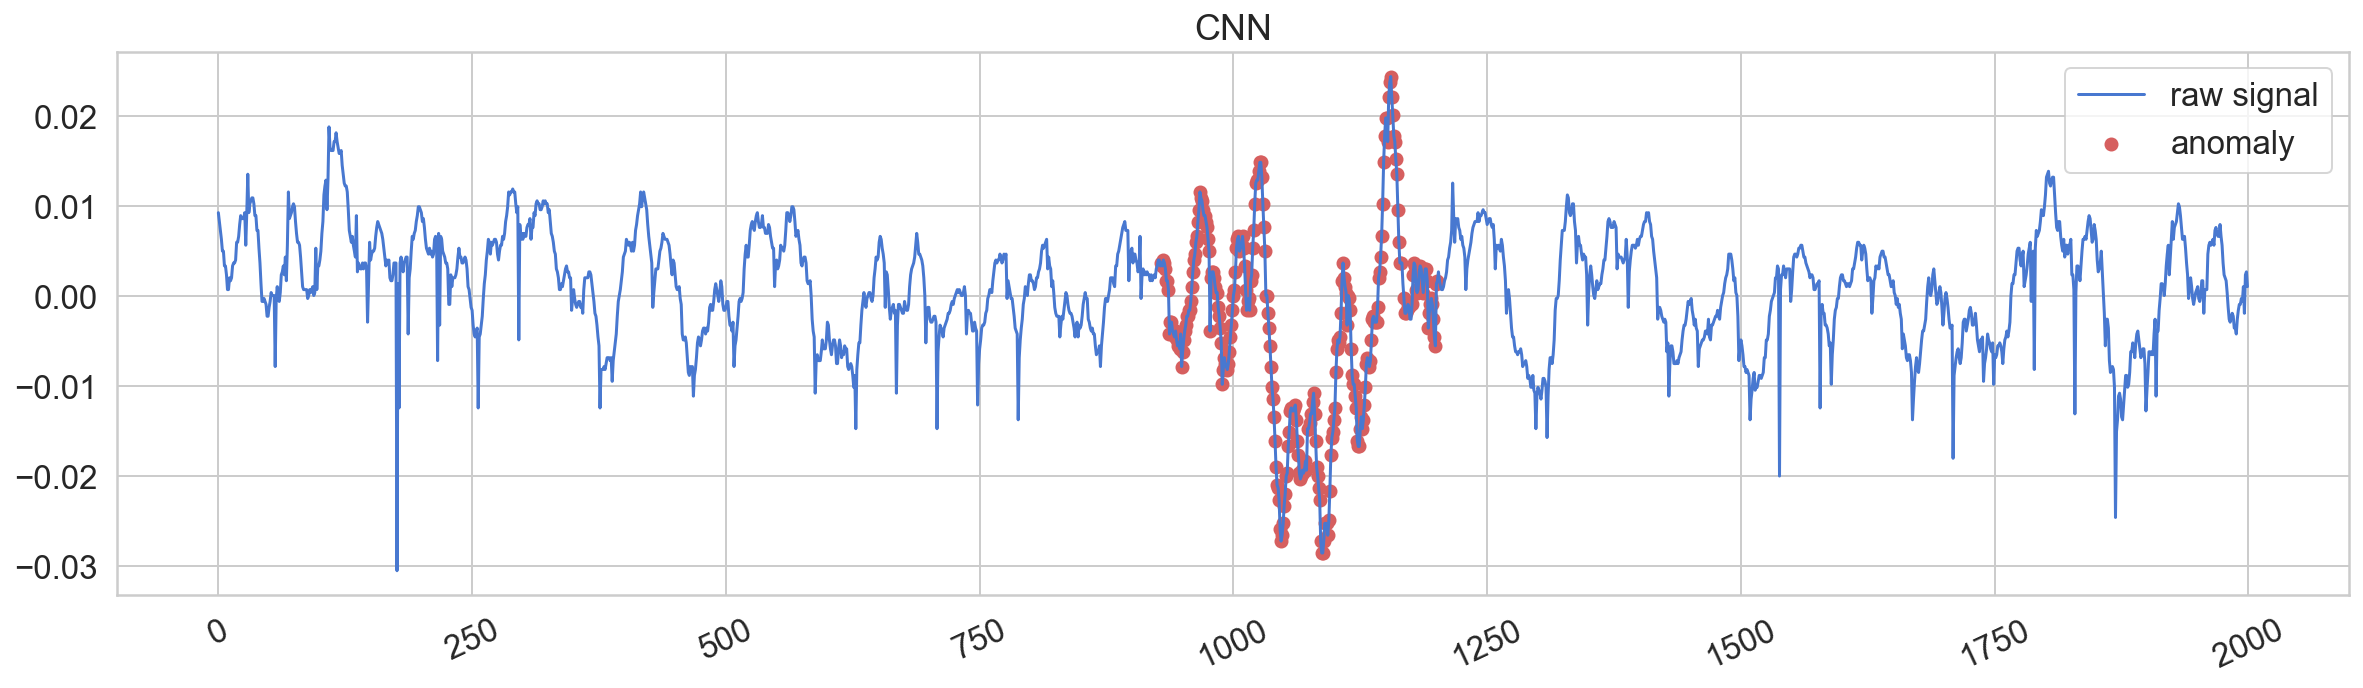

In [49]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies_cnn.index,
  np.array(anomalies_cnn.signal).reshape(len(anomalies_cnn.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("CNN")
plt.xticks(rotation=25)
plt.legend()

### Test 3: Ball fault

In [50]:
kbth = scipy.io.loadmat('Data/ball_fault/B-D-1.mat')

In [51]:
test = data2[7000:9000]
test[1000:1100] = kbth["Channel_1"][2100:2200]

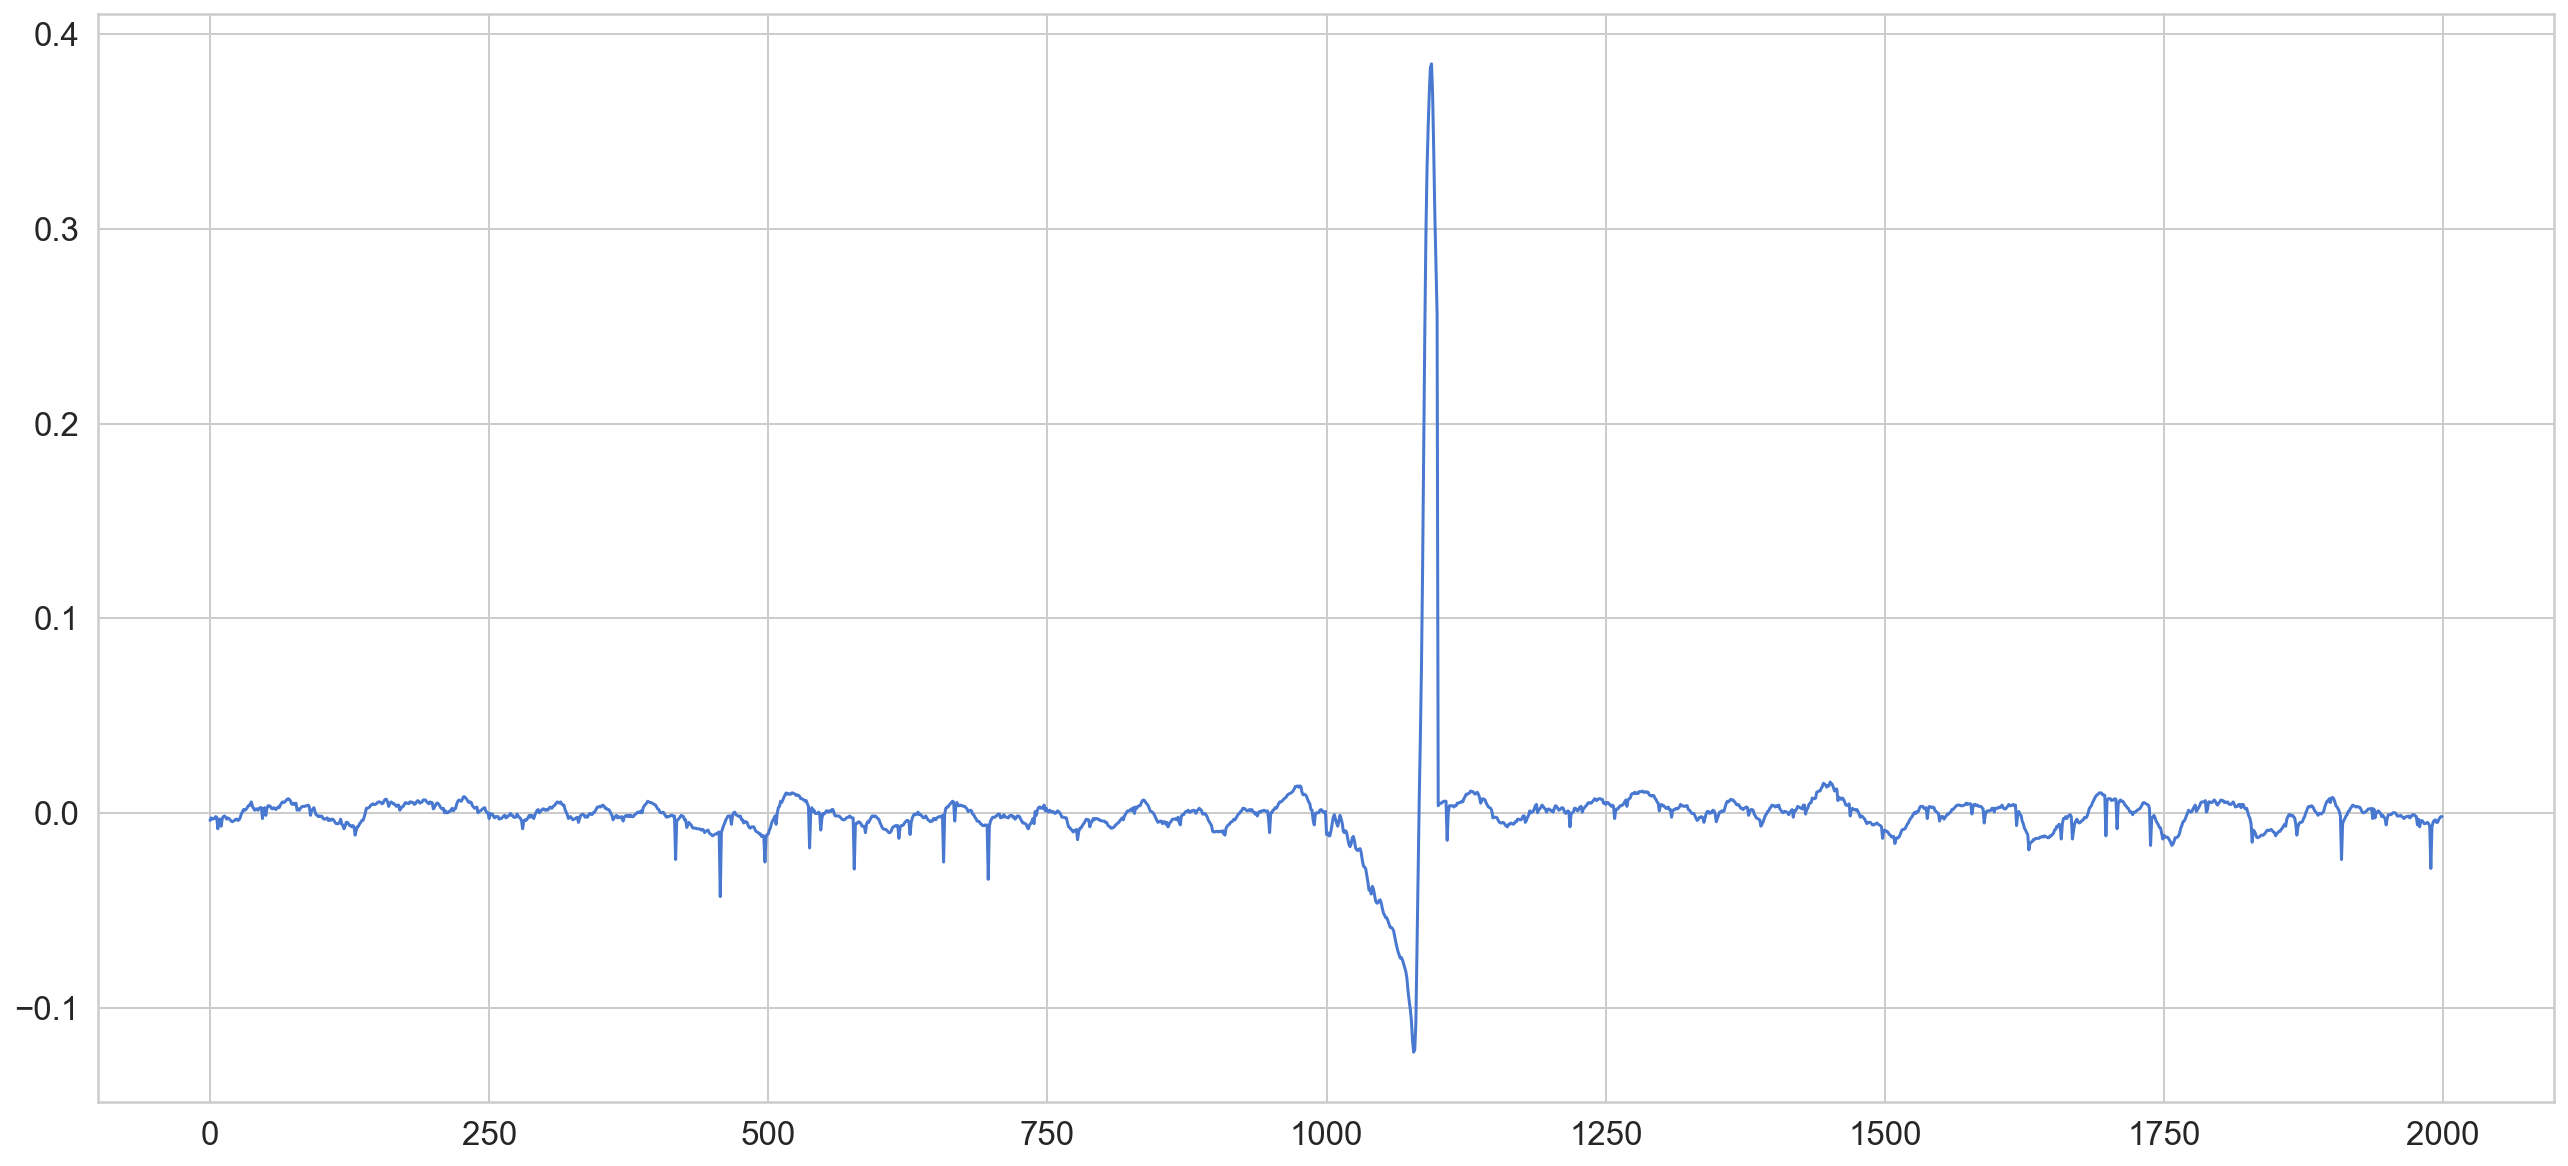

In [52]:
plt.plot(test)

60/60 [==============================] - 0s 6ms/step
(array([ 922,  923,  924,  925,  926,  927,  928,  929,  930,  931,  932,
        933,  934,  935,  936,  937,  938,  939,  940,  941,  942,  943,
        944,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,
        955,  956,  957,  958,  959,  960,  961,  962,  963,  964,  965,
        966,  967,  968,  969,  970,  971,  972,  973,  974,  975,  976,
        977,  978,  979,  980,  981,  982,  983,  984,  985,  986,  987,
        988,  989,  990,  991,  992,  993,  994,  995,  996,  997,  998,
        999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009,
       1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
       1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031,
       1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042,
       1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053,
       1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 106

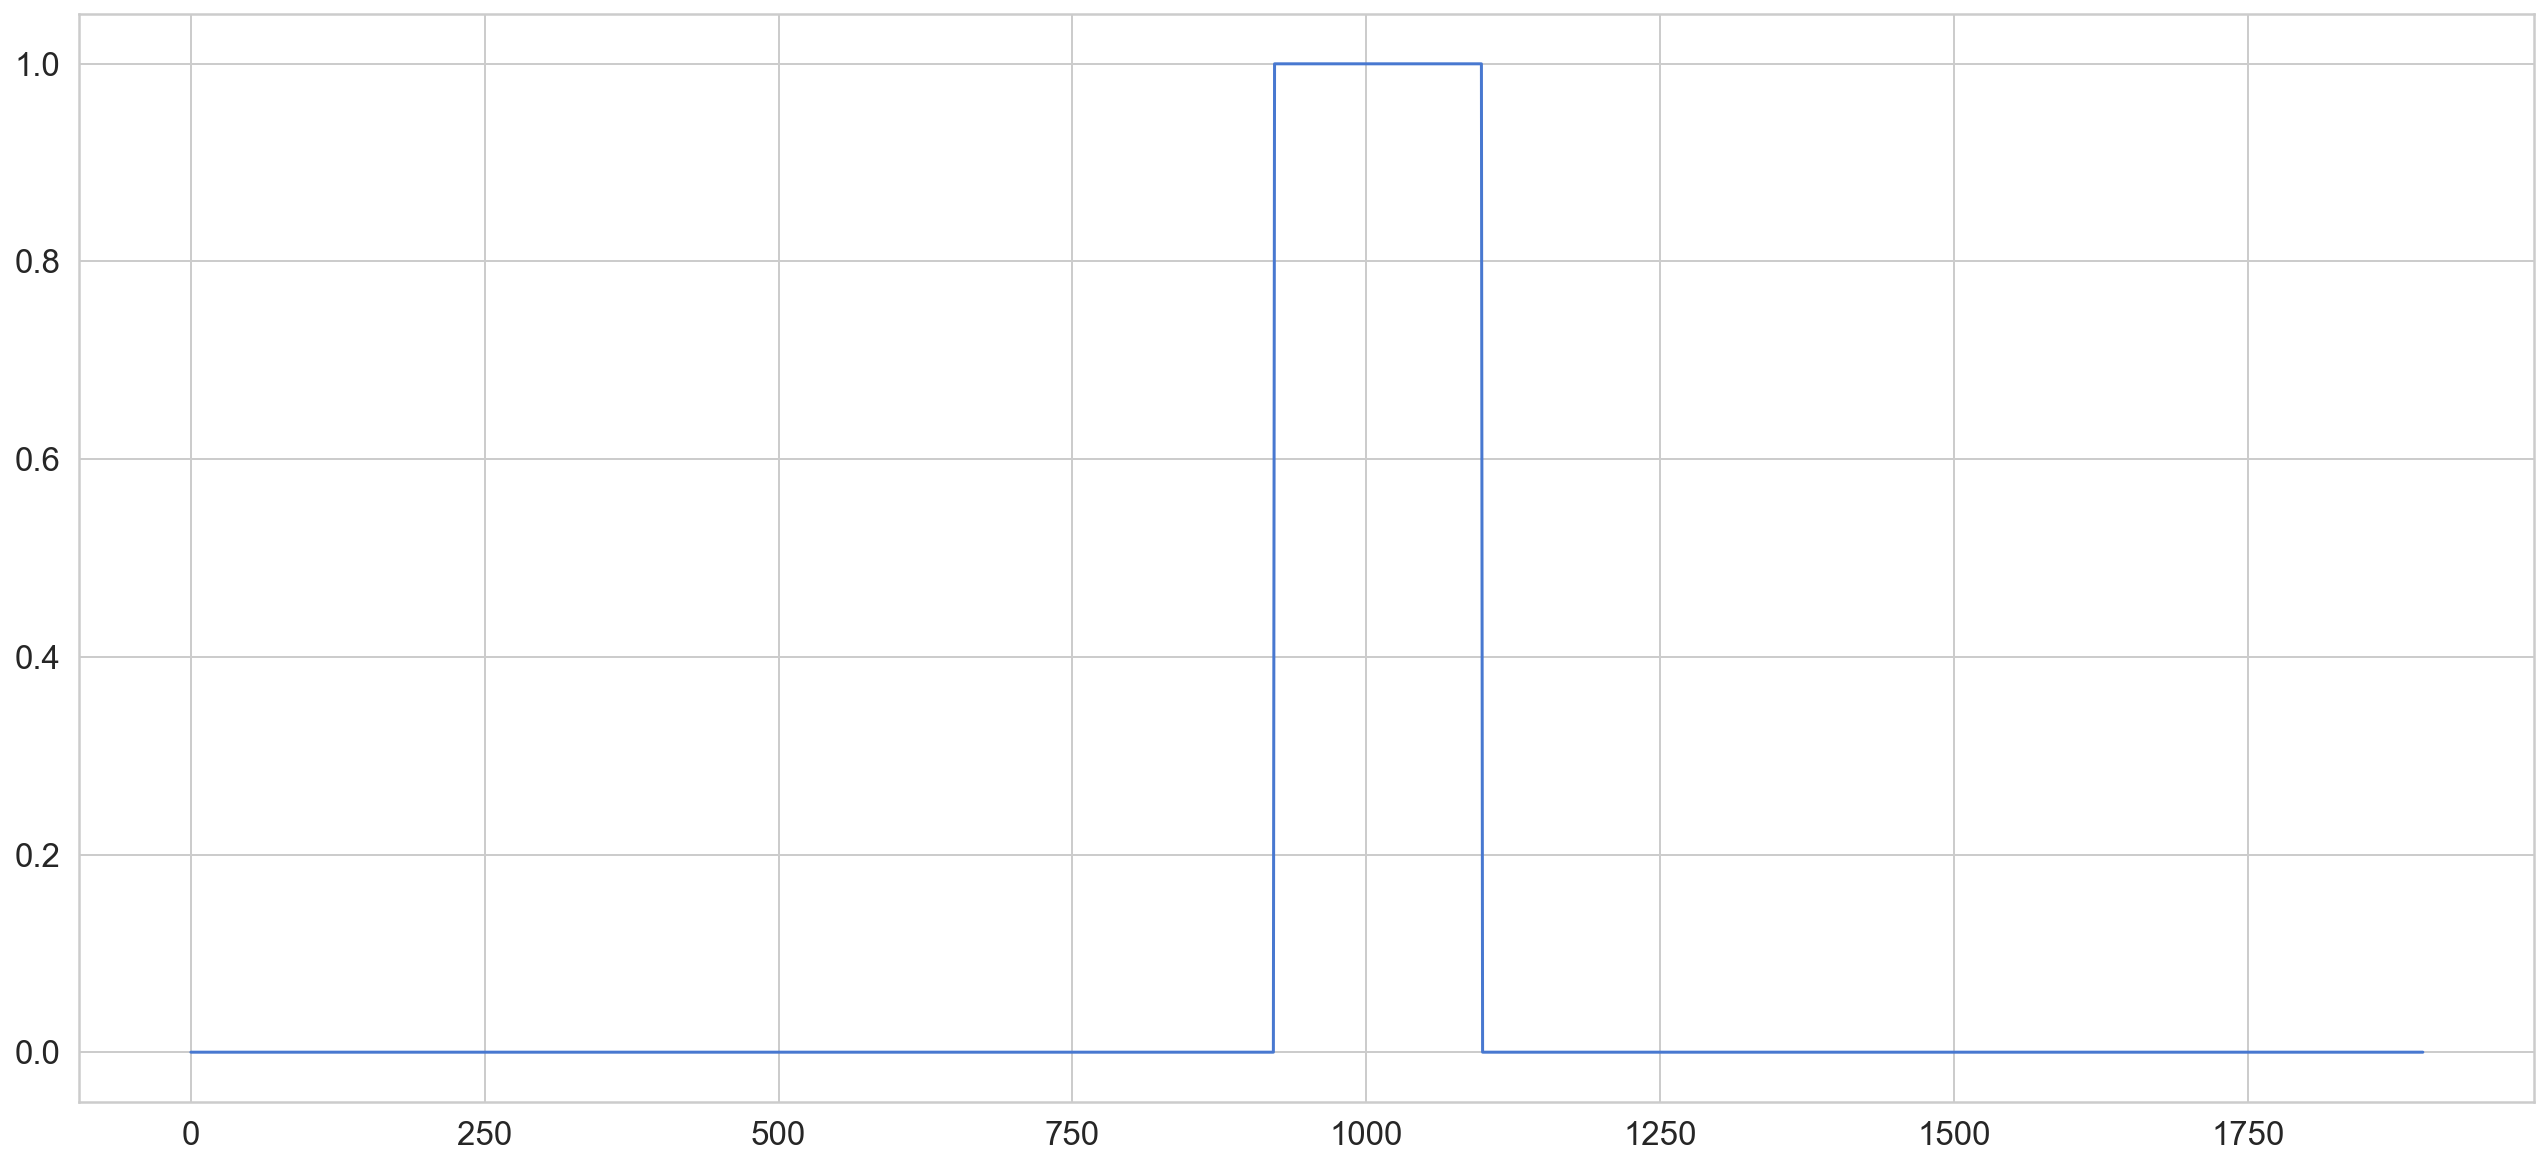

In [53]:
test_cnn = create_dataset_cnn(test,TIME_STEPS)
pre = model_cnn.predict(test_cnn)
re = pre.argmax(axis = 1)
print(np.where(re==1))
plt.plot(re)

In [54]:
test_resample = spline_resampling(test.flatten(),100000)
test_dt = scaler.transform(test_resample.reshape(len(test_resample),1))
X_test, y_test = create_dataset(test_dt, test_dt, TIME_STEPS)
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

3122/3122 [==============================] - 23s 7ms/step


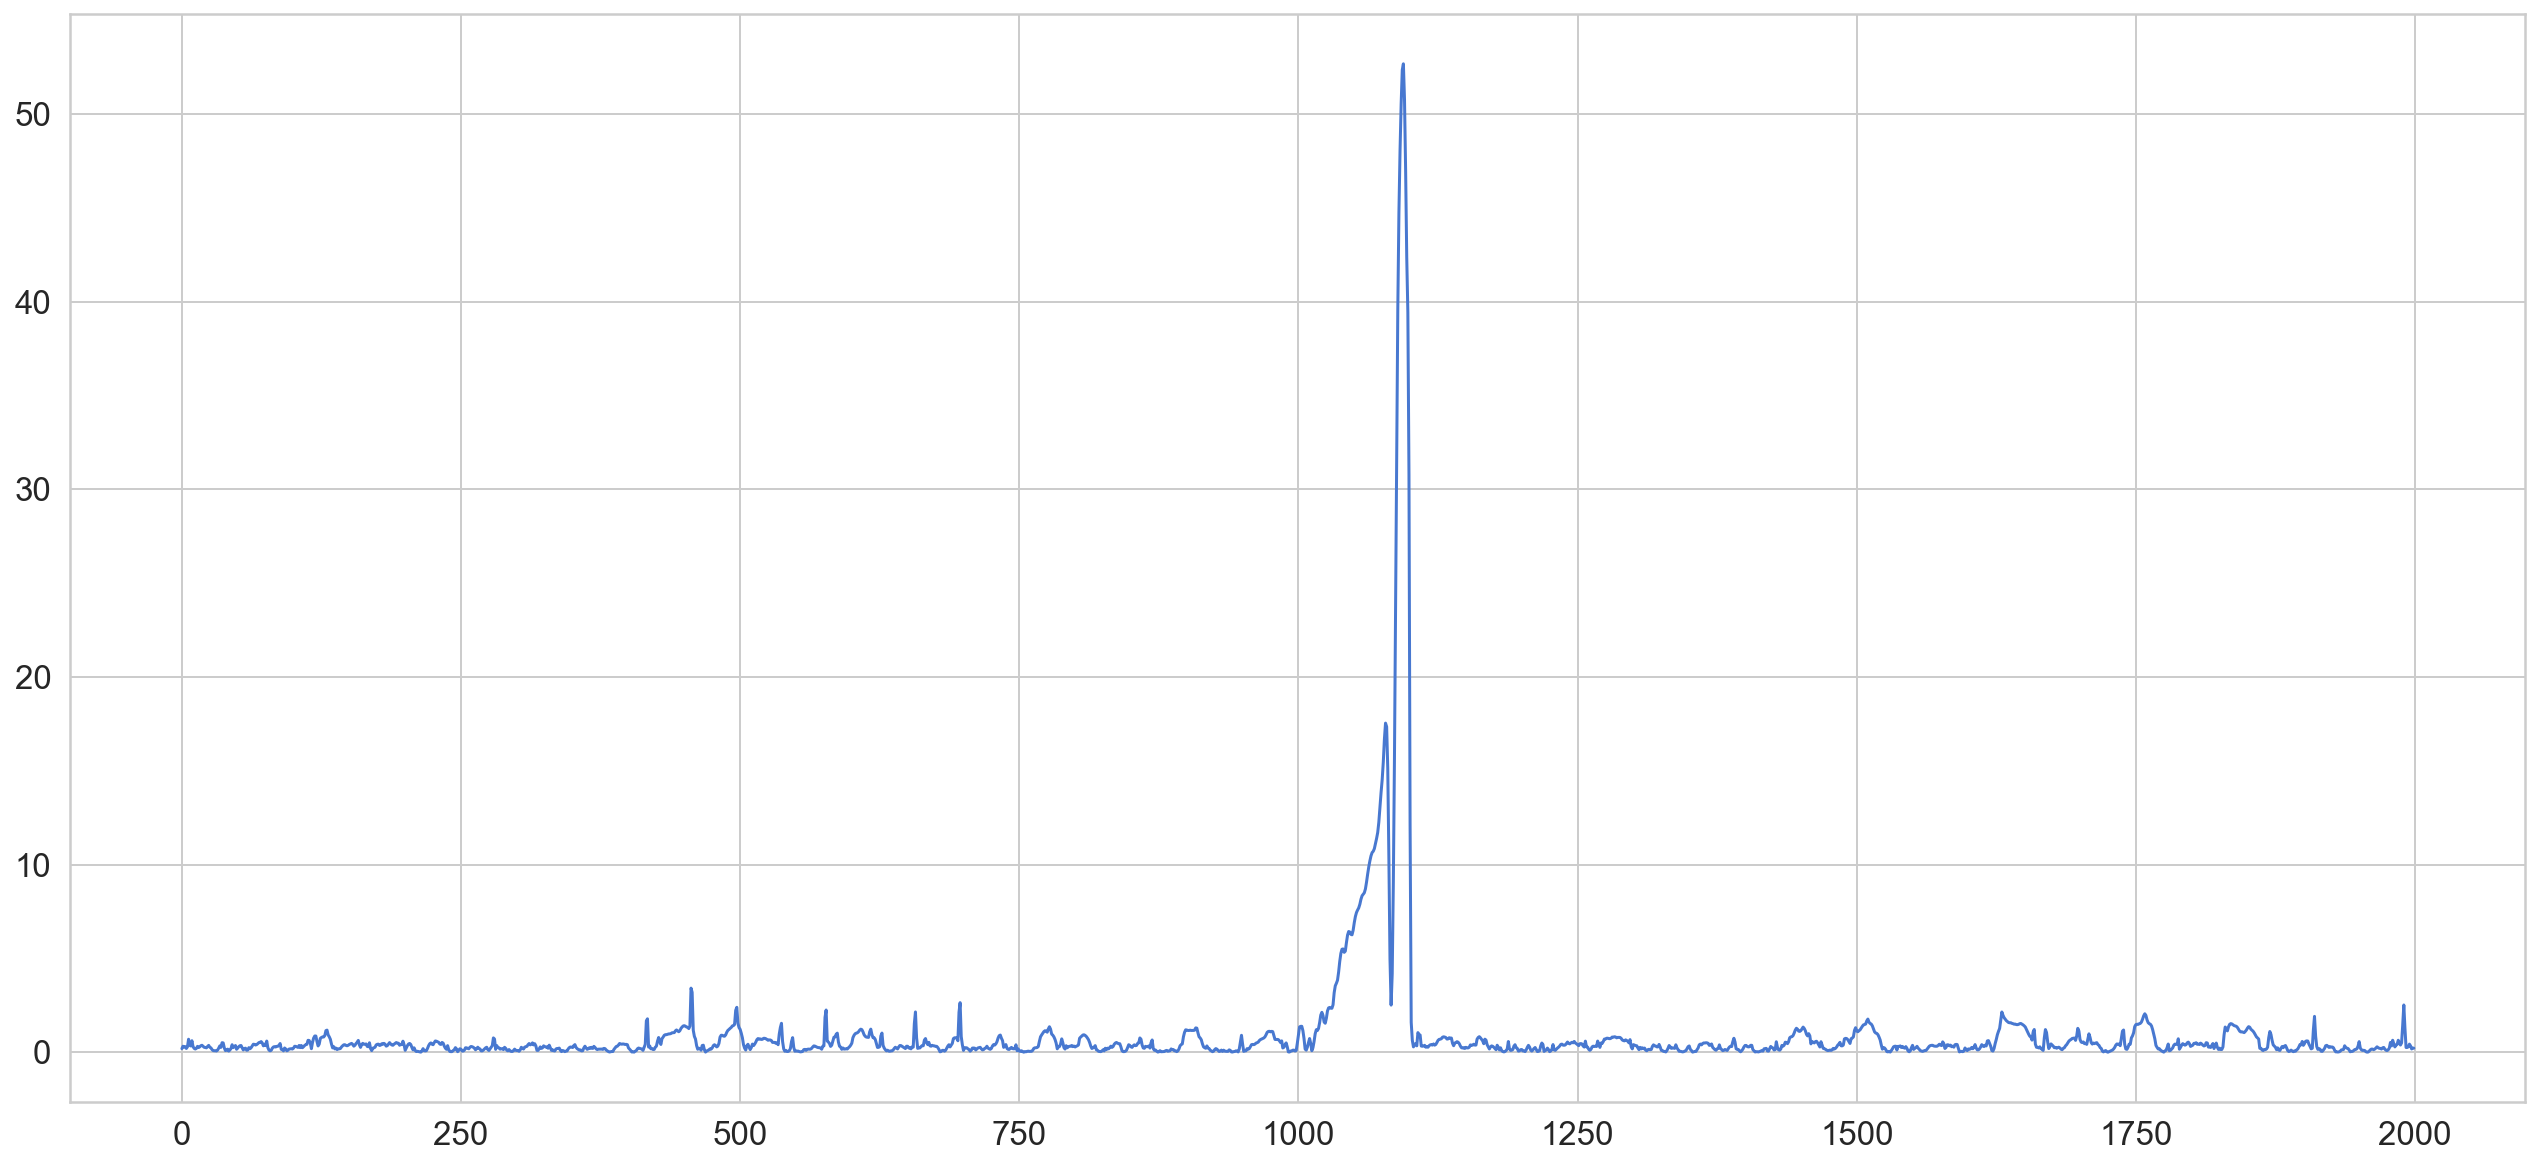

In [55]:
mae_resample = spline_resampling(test_mae_loss.flatten(), 2000)
plt.plot(mae_resample)

In [56]:
test = spline_resampling(test.flatten(),2000)
test_df = pd.DataFrame(index = np.arange(len(mae_resample)-TIME_STEPS))
test_df["loss"] = mae_resample[:len(test)-TIME_STEPS]
test_df["cnn_predict"] = re
test_df["higher_threshold"] = THRESHOLD_HIGH
test_df["anomaly_AE"] = np.where(
    test_df.loss > test_df.higher_threshold,
    True,
    False
)
test_df["cnn"] = np.where(
    test_df.cnn_predict == 1,
    True,
    False
)
test_df["anomaly"] = np.where(
    (test_df.loss > test_df.higher_threshold) & (test_df.cnn_predict == 1),
    True,
    False
)
test_df["signal"] = test[:len(test)-TIME_STEPS]

In [57]:
test_df

loss  cnn_predict  higher_threshold  anomaly_AE    cnn  anomaly  \
0     0.204247            0          2.169728       False  False    False   
1     0.332147            0          2.169728       False  False    False   
2     0.293234            0          2.169728       False  False    False   
3     0.314078            0          2.169728       False  False    False   
4     0.214079            0          2.169728       False  False    False   
...        ...          ...               ...         ...    ...      ...   
1895  0.185442            0          2.169728       False  False    False   
1896  0.294610            0          2.169728       False  False    False   
1897  0.426574            0          2.169728       False  False    False   
1898  0.404918            0          2.169728       False  False    False   
1899  0.586978            0          2.169728       False  False    False   

        signal  
0    -0.003844  
1    -0.002528  
2    -0.003186  
3    -0.002857  
4    -0.002857  
...        ...  
1895  0.004706  
1896  0.006022  
1897  0.006022  
1898  0.007337  
1899  0.005364  

[1900 rows x 7 columns]

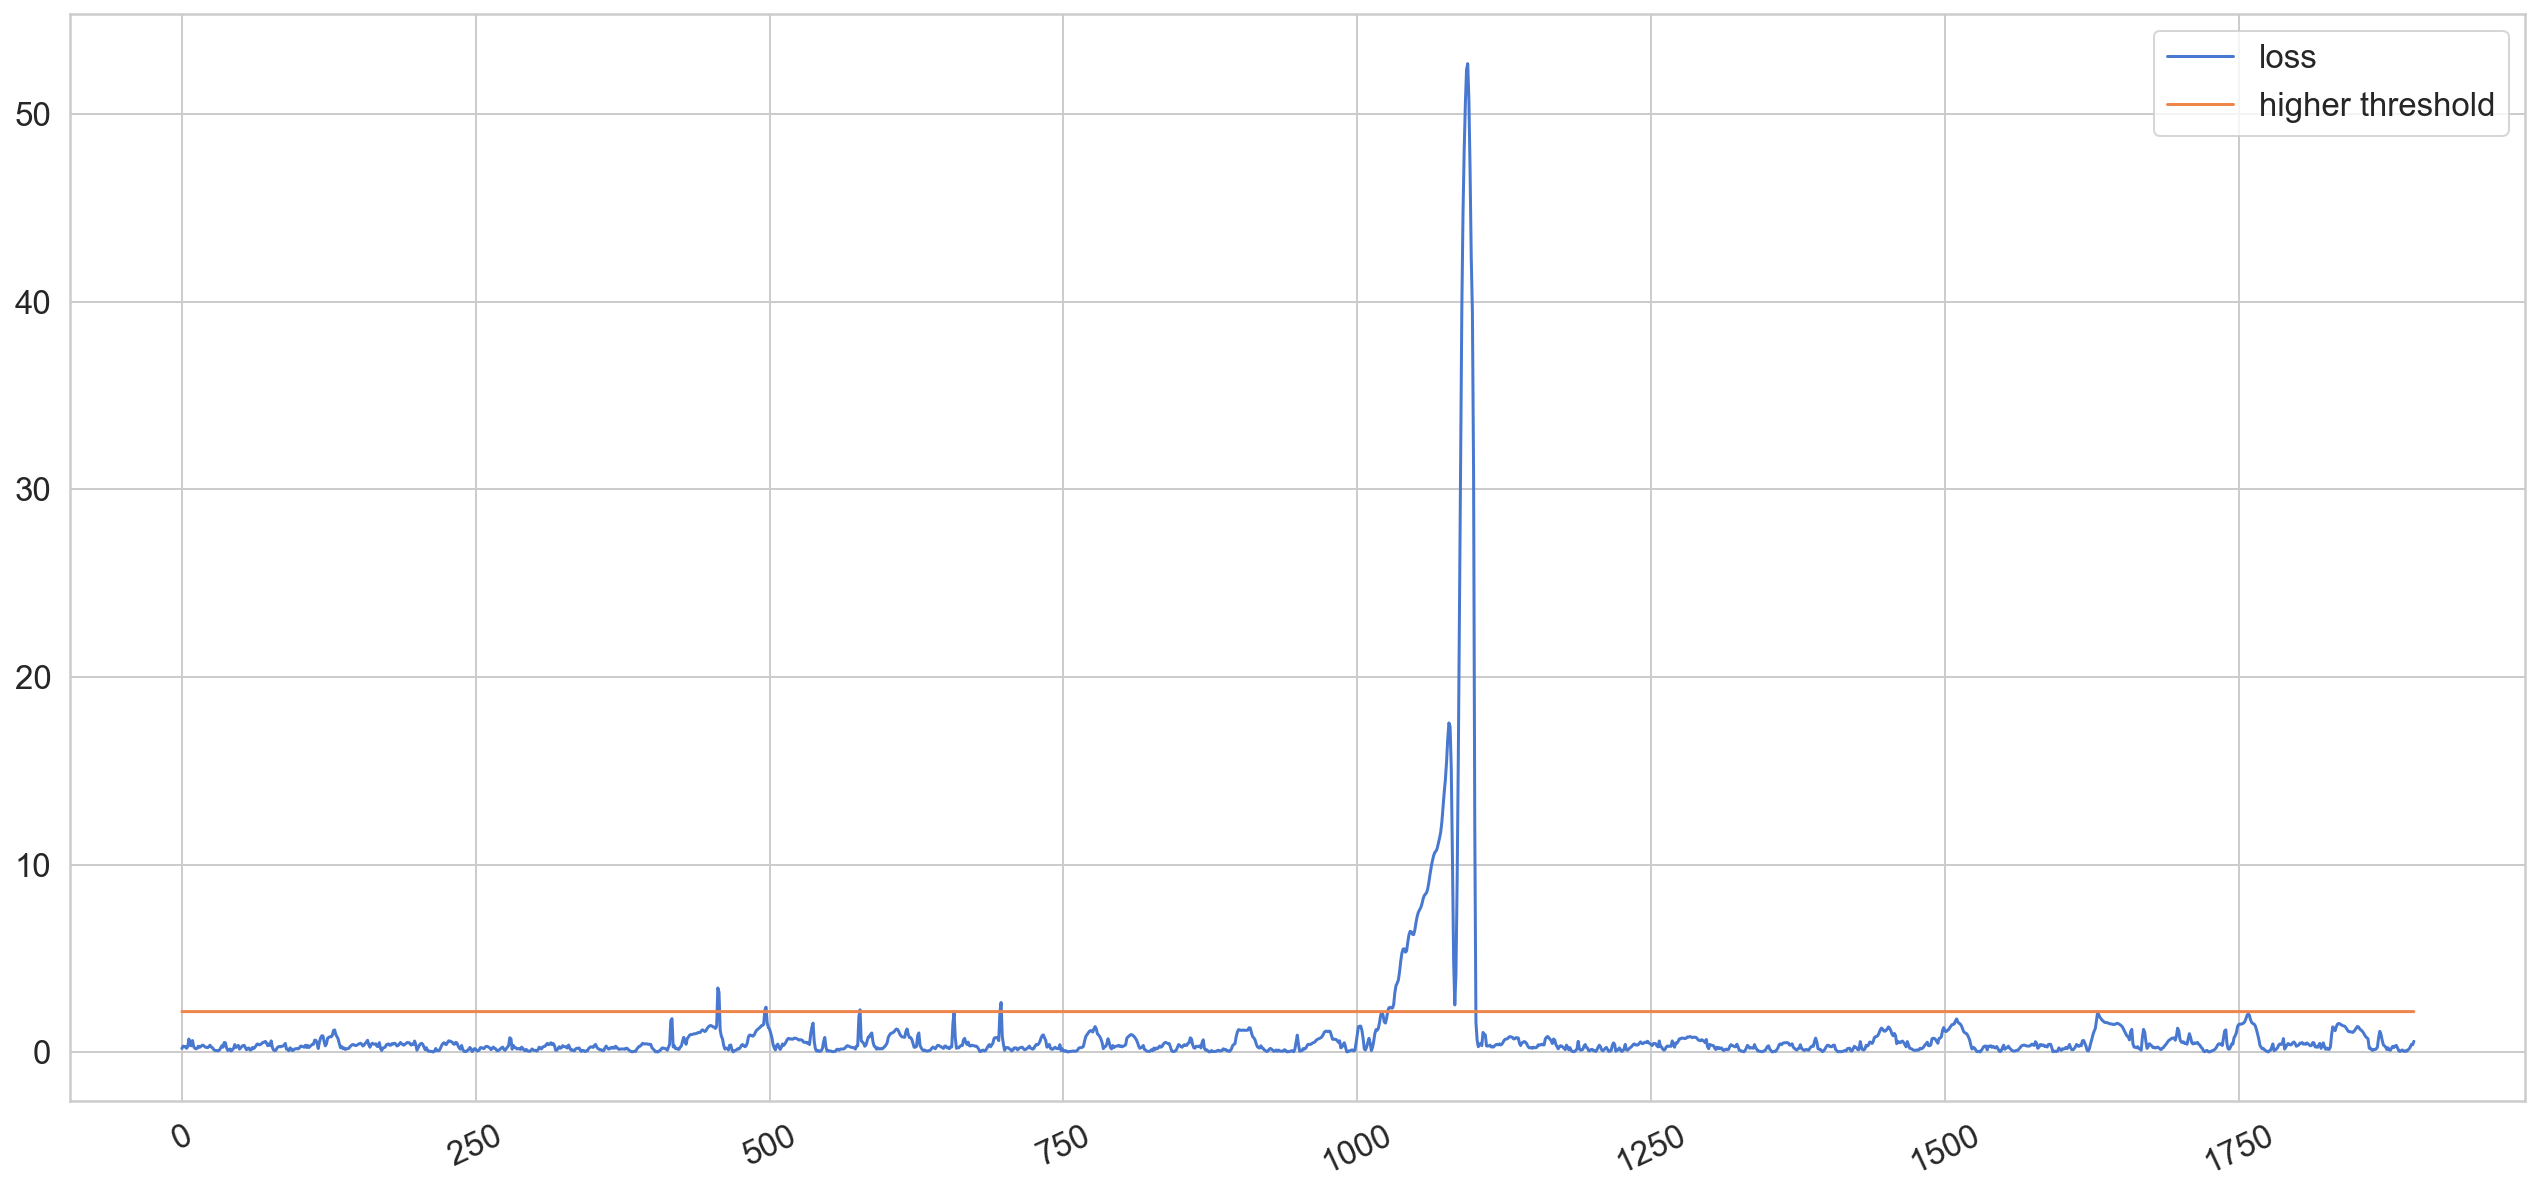

In [58]:
plt.plot(test_df.index, test_df.loss, label='loss')
plt.plot(test_df.index, test_df.higher_threshold, label='higher threshold')
# plt.plot(test_df.index, test_df.lower_threshold, label='lower threshold')
plt.xticks(rotation=25)
plt.legend()

In [59]:
anomalies = test_df[test_df.anomaly == True]
anomalies

loss  cnn_predict  higher_threshold  anomaly_AE   cnn  anomaly  \
1026   2.210100            1          2.169728        True  True     True   
1027   2.374358            1          2.169728        True  True     True   
1028   2.400403            1          2.169728        True  True     True   
1029   2.357211            1          2.169728        True  True     True   
1030   2.356644            1          2.169728        True  True     True   
...         ...          ...               ...         ...   ...      ...   
1094  52.681089            1          2.169728        True  True     True   
1095  50.769476            1          2.169728        True  True     True   
1096  47.030084            1          2.169728        True  True     True   
1097  42.372768            1          2.169728        True  True     True   
1098  39.435422            1          2.169728        True  True     True   

        signal  
1026 -0.017984  
1027 -0.018971  
1028 -0.019299  
1029 -0.018642  
1030 -0.018313  
...        ...  
1094  0.384854  
1095  0.369069  
1096  0.339473  
1097  0.306588  
1098  0.280938  

[73 rows x 7 columns]

In [60]:
anomalies_ae = test_df[test_df.anomaly_AE == True]
anomalies_ae

loss  cnn_predict  higher_threshold  anomaly_AE    cnn  anomaly  \
456    3.428614            0          2.169728        True  False    False   
457    3.203606            0          2.169728        True  False    False   
496    2.244847            0          2.169728        True  False    False   
497    2.406097            0          2.169728        True  False    False   
577    2.262889            0          2.169728        True  False    False   
...         ...          ...               ...         ...    ...      ...   
1096  47.030084            1          2.169728        True   True     True   
1097  42.372768            1          2.169728        True   True     True   
1098  39.435422            1          2.169728        True   True     True   
1099  30.790414            0          2.169728        True  False    False   
1100  12.129471            0          2.169728        True  False    False   

        signal  
456  -0.009763  
457  -0.042976  
496  -0.011736  
497  -0.025219  
577  -0.028836  
...        ...  
1096  0.339473  
1097  0.306588  
1098  0.280938  
1099  0.256274  
1100  0.003720  

[81 rows x 7 columns]

In [61]:
anomalies_cnn = test_df[test_df.cnn == True]
anomalies_cnn

loss  cnn_predict  higher_threshold  anomaly_AE   cnn  anomaly  \
922    0.086616            1          2.169728       False  True    False   
923    0.043397            1          2.169728       False  True    False   
924    0.065853            1          2.169728       False  True    False   
925    0.153102            1          2.169728       False  True    False   
926    0.206341            1          2.169728       False  True    False   
...         ...          ...               ...         ...   ...      ...   
1094  52.681089            1          2.169728        True  True     True   
1095  50.769476            1          2.169728        True  True     True   
1096  47.030084            1          2.169728        True  True     True   
1097  42.372768            1          2.169728        True  True     True   
1098  39.435422            1          2.169728        True  True     True   

        signal  
922  -0.000226  
923   0.000760  
924   0.001089  
925   0.002404  
926   0.002404  
...        ...  
1094  0.384854  
1095  0.369069  
1096  0.339473  
1097  0.306588  
1098  0.280938  

[177 rows x 7 columns]

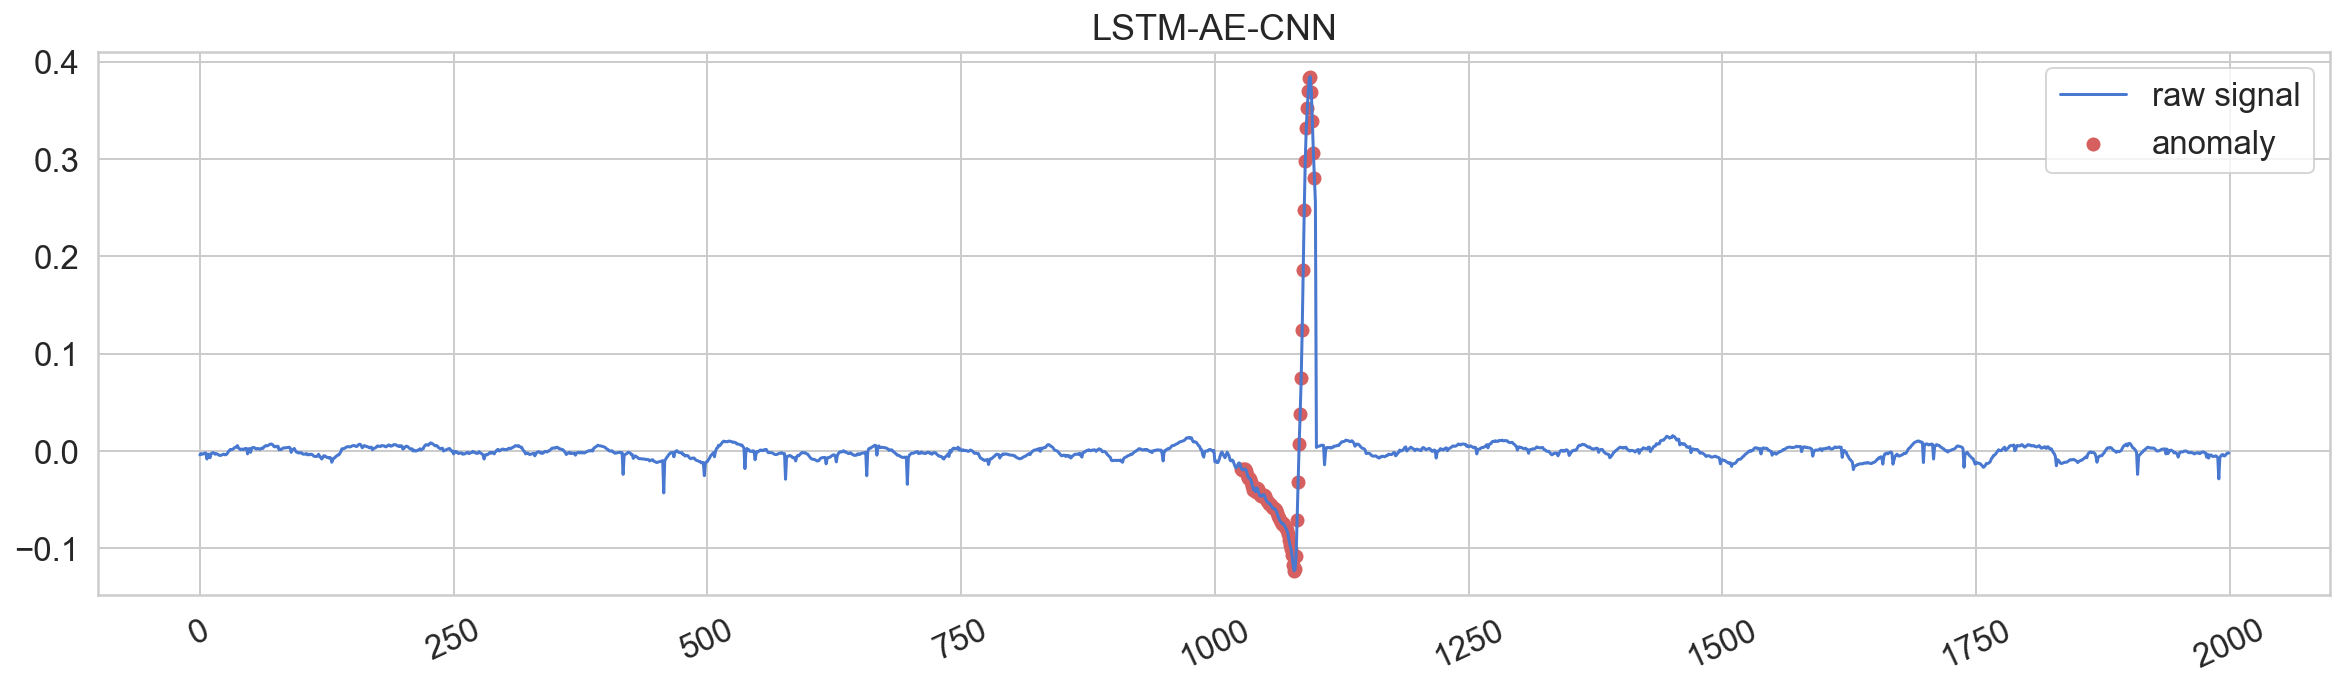

In [62]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies.index,
  np.array(anomalies.signal).reshape(len(anomalies.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("LSTM-AE-CNN")
plt.xticks(rotation=25)
plt.legend()

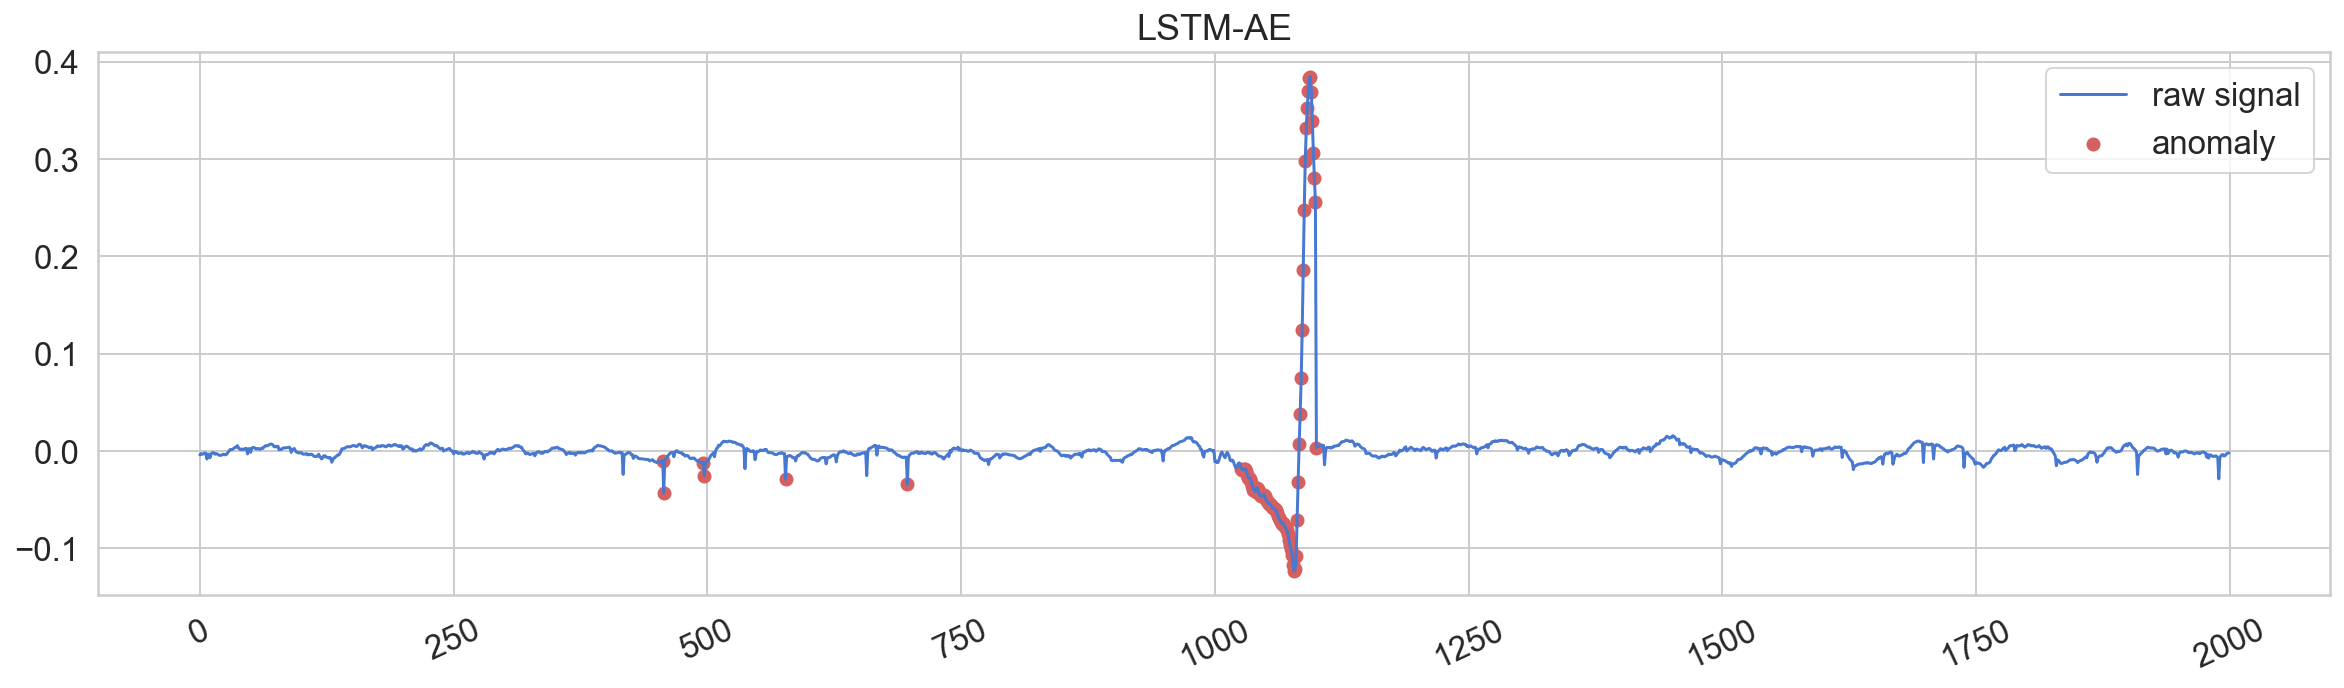

In [63]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies_ae.index,
  np.array(anomalies_ae.signal).reshape(len(anomalies_ae.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("LSTM-AE")
plt.xticks(rotation=25)
plt.legend()

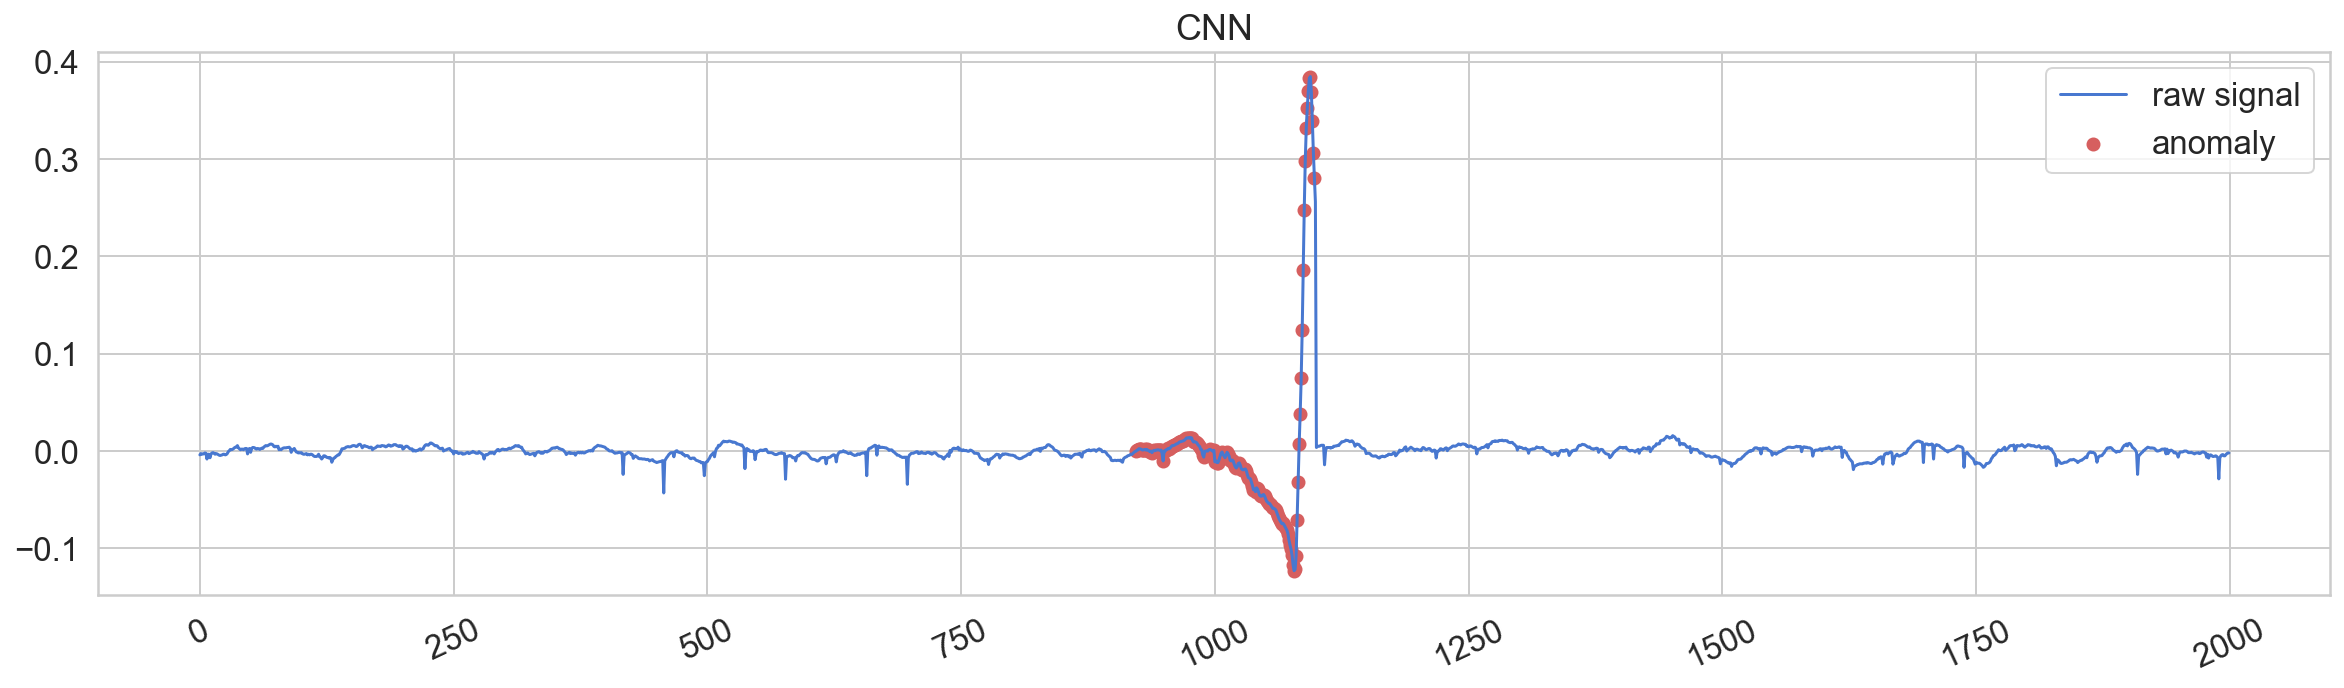

In [64]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies_cnn.index,
  np.array(anomalies_cnn.signal).reshape(len(anomalies_cnn.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("CNN")
plt.xticks(rotation=25)
plt.legend()

### Test 4: Combine fault 

In [65]:
kbth = scipy.io.loadmat('Data/combine_fault/C-B-1.mat')

In [66]:
test = data2[7000:9000]
test[1000:1200] = kbth["Channel_1"][2000:2200]

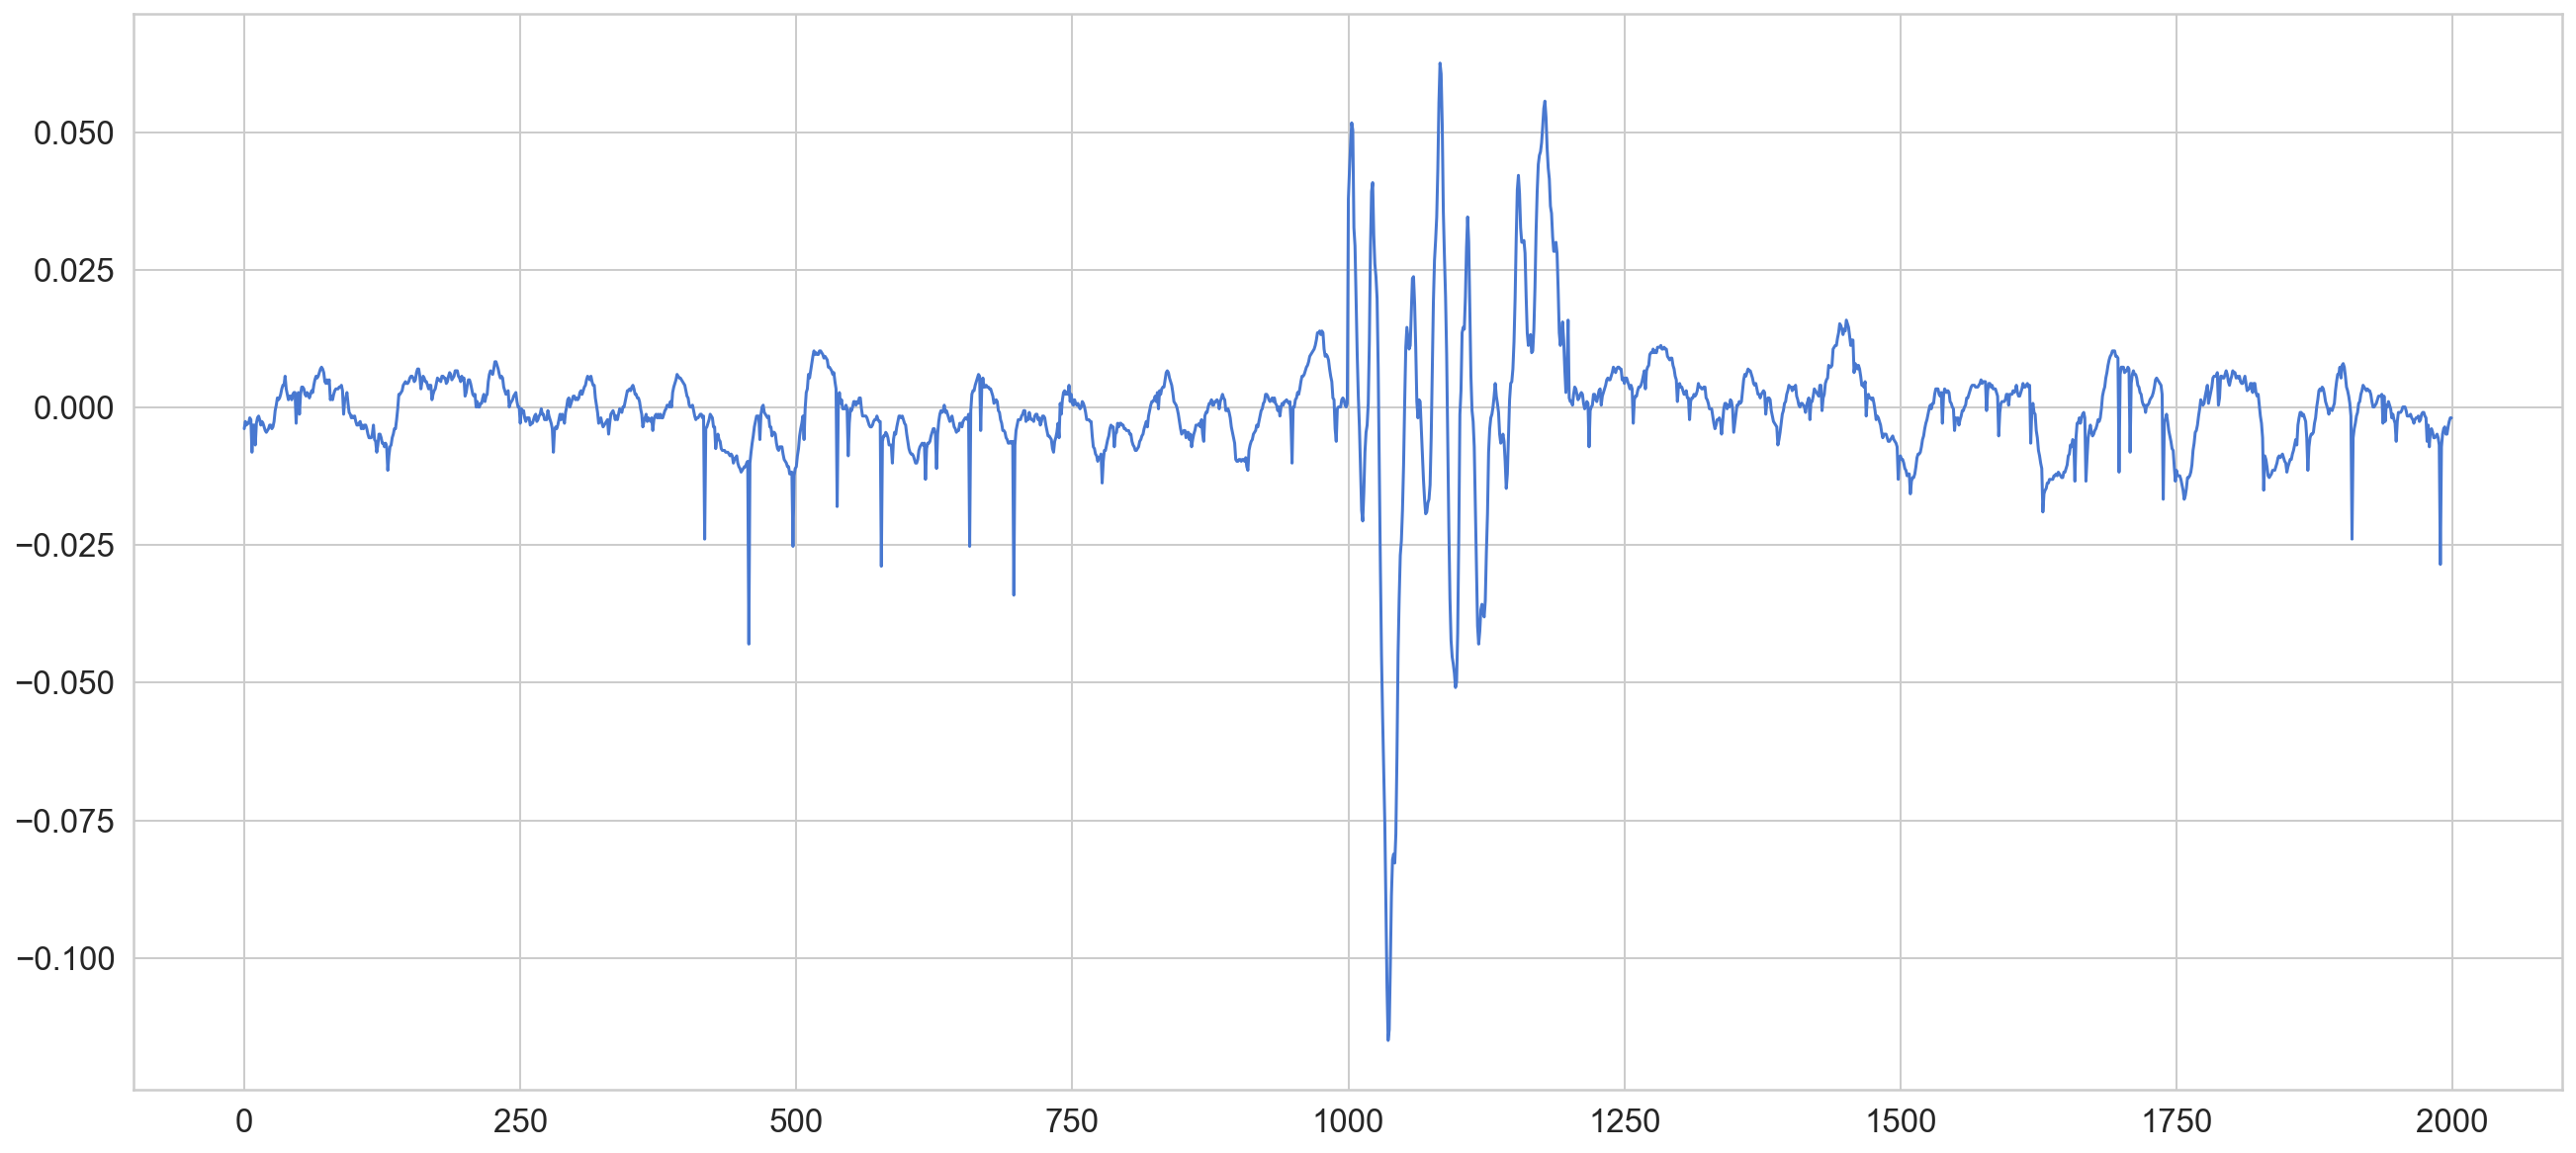

In [67]:
plt.plot(test)

60/60 [==============================] - 0s 5ms/step
(array([ 905,  906,  907,  908,  909,  910,  911,  912,  913,  914,  915,
        916,  917,  918,  919,  920,  921,  922,  923,  924,  925,  926,
        927,  928,  929,  930,  931,  932,  933,  934,  935,  936,  937,
        938,  939,  940,  941,  942,  943,  944,  945,  946,  947,  948,
        949,  950,  951,  952,  953,  954,  955,  956,  957,  958,  959,
        960,  961,  962,  963,  964,  965,  966,  967,  968,  969,  970,
        971,  972,  973,  974,  975,  976,  977,  978,  979,  980,  981,
        982,  983,  984,  985,  986,  987,  988,  989,  990,  991,  992,
        993,  994,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003,
       1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014,
       1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025,
       1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036,
       1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 104

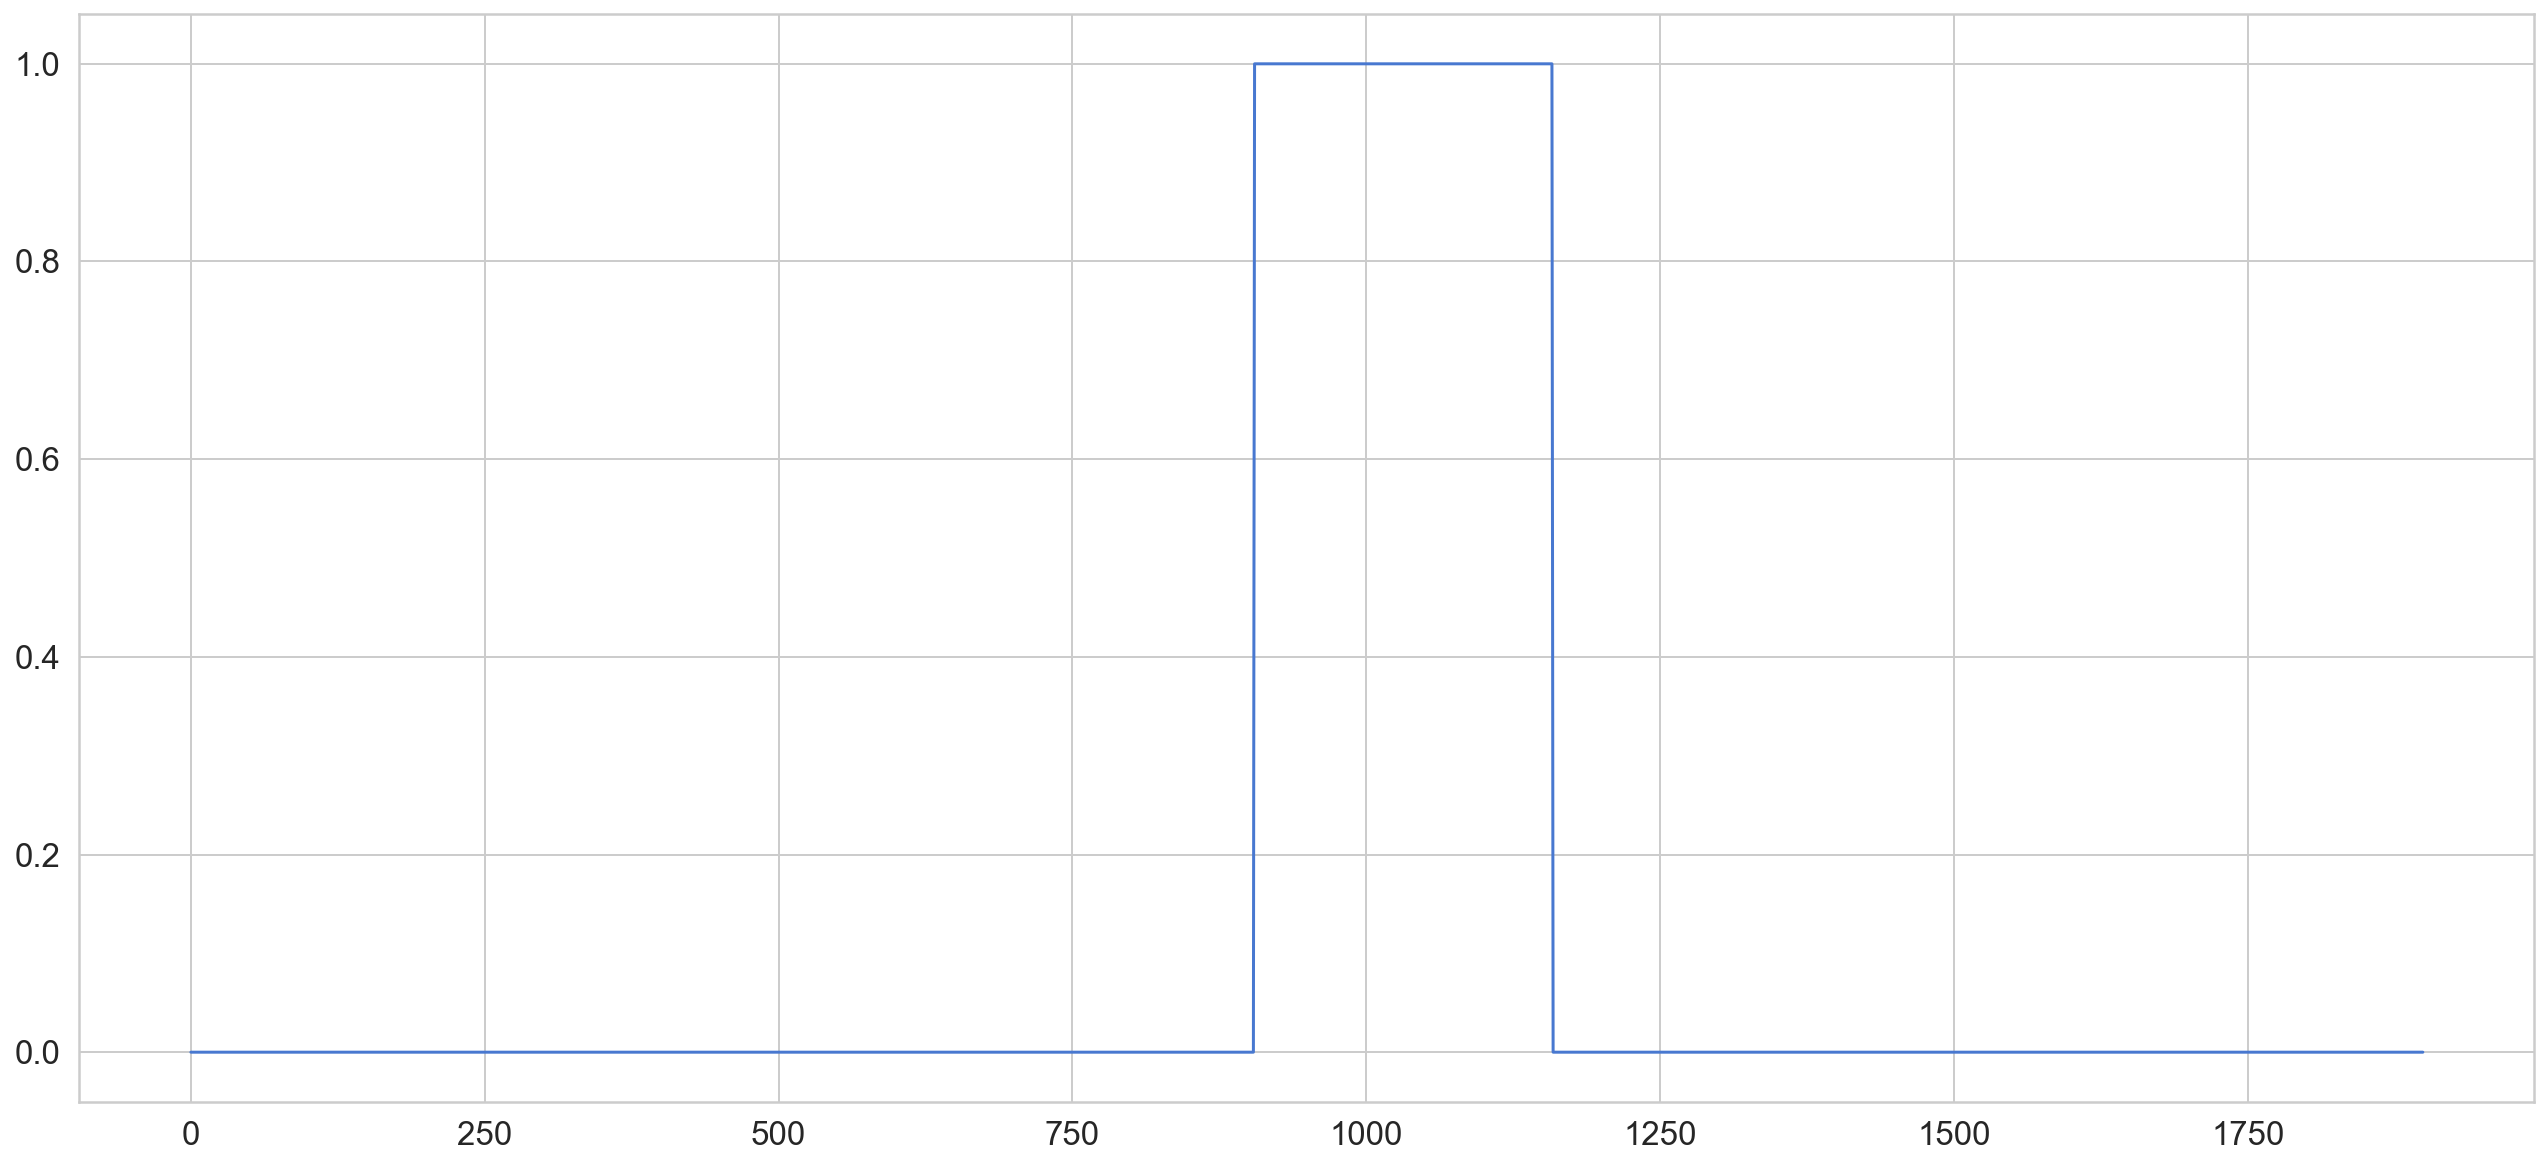

In [68]:
test_cnn = create_dataset_cnn(test,TIME_STEPS)
pre = model_cnn.predict(test_cnn)
re = pre.argmax(axis = 1)
print(np.where(re==1))
plt.plot(re)

In [69]:
test_resample = spline_resampling(test.flatten(),100000)
test_dt = scaler.transform(test_resample.reshape(len(test_resample),1))
X_test, y_test = create_dataset(test_dt, test_dt, TIME_STEPS)
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

3122/3122 [==============================] - 22s 7ms/step


In [70]:
mae_resample = spline_resampling(test_mae_loss.flatten(), 2000)

In [71]:
test = spline_resampling(test.flatten(),2000)
test_df = pd.DataFrame(index = np.arange(len(mae_resample)-TIME_STEPS))
test_df["loss"] = mae_resample[:len(test)-TIME_STEPS]
test_df["cnn_predict"] = re
test_df["higher_threshold"] = THRESHOLD_HIGH
test_df["anomaly_AE"] = np.where(
    test_df.loss > test_df.higher_threshold,
    True,
    False
)
test_df["cnn"] = np.where(
    test_df.cnn_predict == 1,
    True,
    False
)
test_df["anomaly"] = np.where(
    (test_df.loss > test_df.higher_threshold) & (test_df.cnn_predict == 1),
    True,
    False
)
test_df["signal"] = test[:len(test)-TIME_STEPS]

In [72]:
test_df

loss  cnn_predict  higher_threshold  anomaly_AE    cnn  anomaly  \
0     0.204247            0          2.169728       False  False    False   
1     0.332147            0          2.169728       False  False    False   
2     0.293234            0          2.169728       False  False    False   
3     0.314078            0          2.169728       False  False    False   
4     0.214079            0          2.169728       False  False    False   
...        ...          ...               ...         ...    ...      ...   
1895  0.185442            0          2.169728       False  False    False   
1896  0.294610            0          2.169728       False  False    False   
1897  0.426574            0          2.169728       False  False    False   
1898  0.404918            0          2.169728       False  False    False   
1899  0.586978            0          2.169728       False  False    False   

        signal  
0    -0.003844  
1    -0.002528  
2    -0.003186  
3    -0.002857  
4    -0.002857  
...        ...  
1895  0.004706  
1896  0.006022  
1897  0.006022  
1898  0.007337  
1899  0.005364  

[1900 rows x 7 columns]

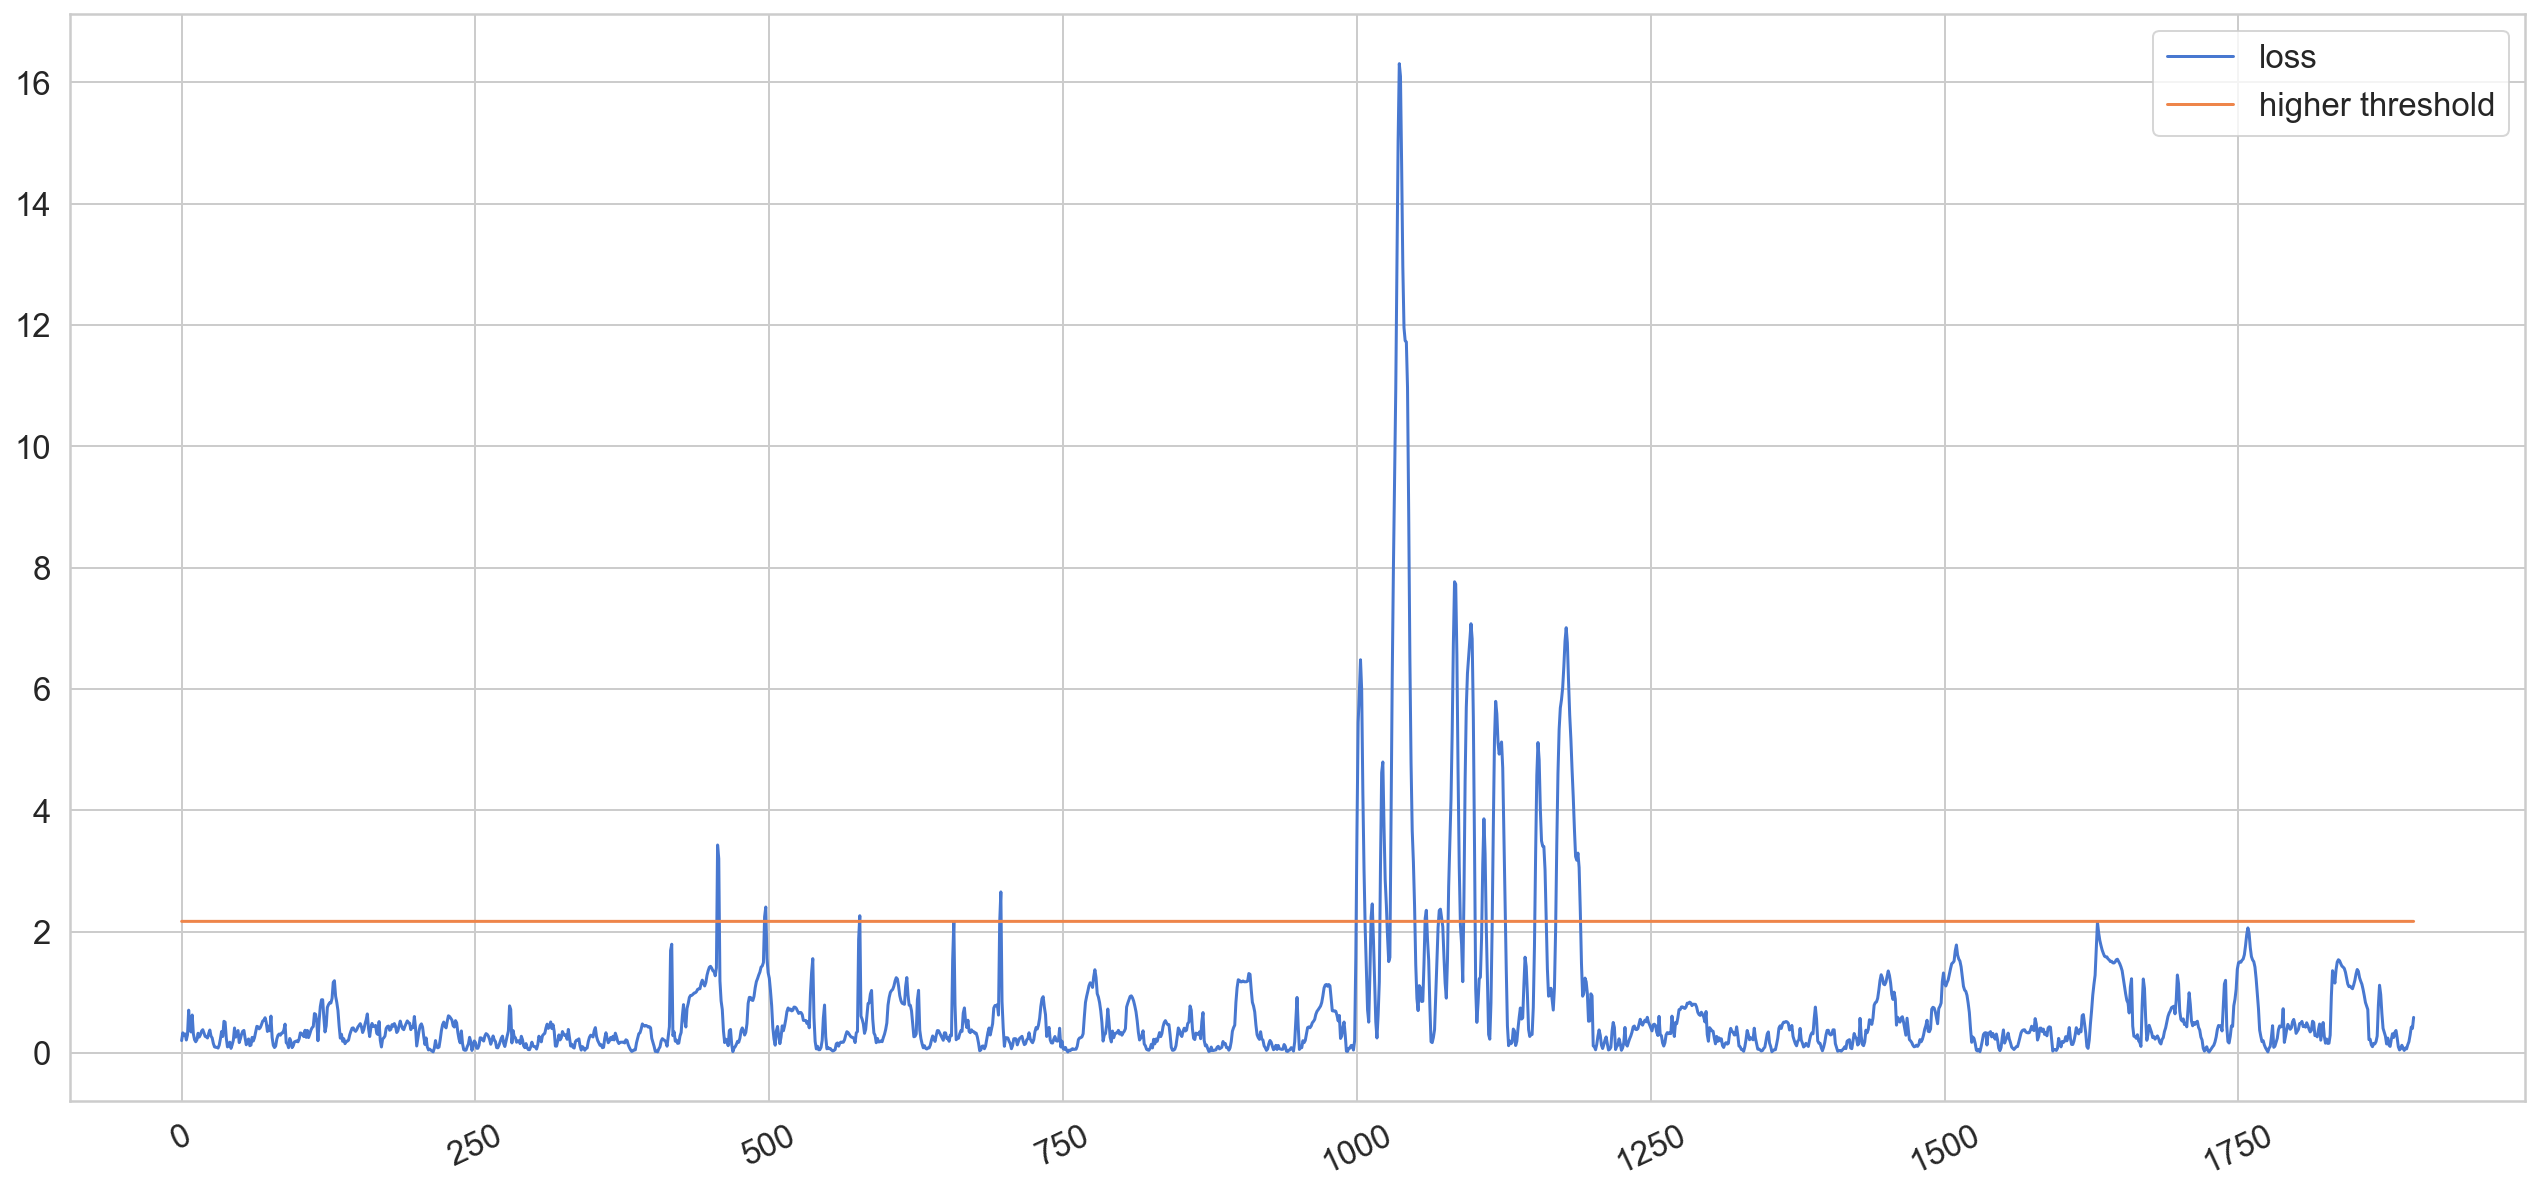

In [73]:
plt.plot(test_df.index, test_df.loss, label='loss')
plt.plot(test_df.index, test_df.higher_threshold, label='higher threshold')
# plt.plot(test_df.index, test_df.lower_threshold, label='lower threshold')
plt.xticks(rotation=25)
plt.legend()

In [74]:
anomalies = test_df[test_df.anomaly == True]
anomalies

loss  cnn_predict  higher_threshold  anomaly_AE   cnn  anomaly  \
1000  3.680576            1          2.169728        True  True     True   
1001  5.447983            1          2.169728        True  True     True   
1002  5.934665            1          2.169728        True  True     True   
1003  6.482405            1          2.169728        True  True     True   
1004  5.983153            1          2.169728        True  True     True   
...        ...          ...               ...         ...   ...      ...   
1154  5.117642            1          2.169728        True  True     True   
1155  4.829557            1          2.169728        True  True     True   
1156  4.021975            1          2.169728        True  True     True   
1157  3.497348            1          2.169728        True  True     True   
1158  3.409179            1          2.169728        True  True     True   

        signal  
1000  0.037920  
1001  0.043181  
1002  0.047785  
1003  0.051731  
1004  0.050416  
...        ...  
1154  0.042195  
1155  0.038906  
1156  0.032658  
1157  0.030028  
1158  0.030028  

[82 rows x 7 columns]

In [75]:
anomalies_ae = test_df[test_df.anomaly_AE == True]
anomalies_ae

loss  cnn_predict  higher_threshold  anomaly_AE    cnn  anomaly  \
456   3.428614            0          2.169728        True  False    False   
457   3.203606            0          2.169728        True  False    False   
496   2.244847            0          2.169728        True  False    False   
497   2.406097            0          2.169728        True  False    False   
577   2.262889            0          2.169728        True  False    False   
...        ...          ...               ...         ...    ...      ...   
1186  3.237938            0          2.169728        True  False    False   
1187  3.177105            0          2.169728        True  False    False   
1188  3.295475            0          2.169728        True  False    False   
1189  3.056768            0          2.169728        True  False    False   
1190  2.343634            0          2.169728        True  False    False   

        signal  
456  -0.009763  
457  -0.042976  
496  -0.011736  
497  -0.025219  
577  -0.028836  
...        ...  
1186  0.028383  
1187  0.028383  
1188  0.030028  
1189  0.028054  
1190  0.021478  

[112 rows x 7 columns]

In [76]:
anomalies_cnn = test_df[test_df.cnn == True]
anomalies_cnn

loss  cnn_predict  higher_threshold  anomaly_AE   cnn  anomaly  \
905   1.173816            1          2.169728       False  True    False   
906   1.174615            1          2.169728       False  True    False   
907   1.186089            1          2.169728       False  True    False   
908   1.309959            1          2.169728       False  True    False   
909   1.296791            1          2.169728       False  True    False   
...        ...          ...               ...         ...   ...      ...   
1154  5.117642            1          2.169728        True  True     True   
1155  4.829557            1          2.169728        True  True     True   
1156  4.021975            1          2.169728        True  True     True   
1157  3.497348            1          2.169728        True  True     True   
1158  3.409179            1          2.169728        True  True     True   

        signal  
905  -0.009434  
906  -0.009763  
907  -0.009105  
908  -0.010749  
909  -0.011407  
...        ...  
1154  0.042195  
1155  0.038906  
1156  0.032658  
1157  0.030028  
1158  0.030028  

[254 rows x 7 columns]

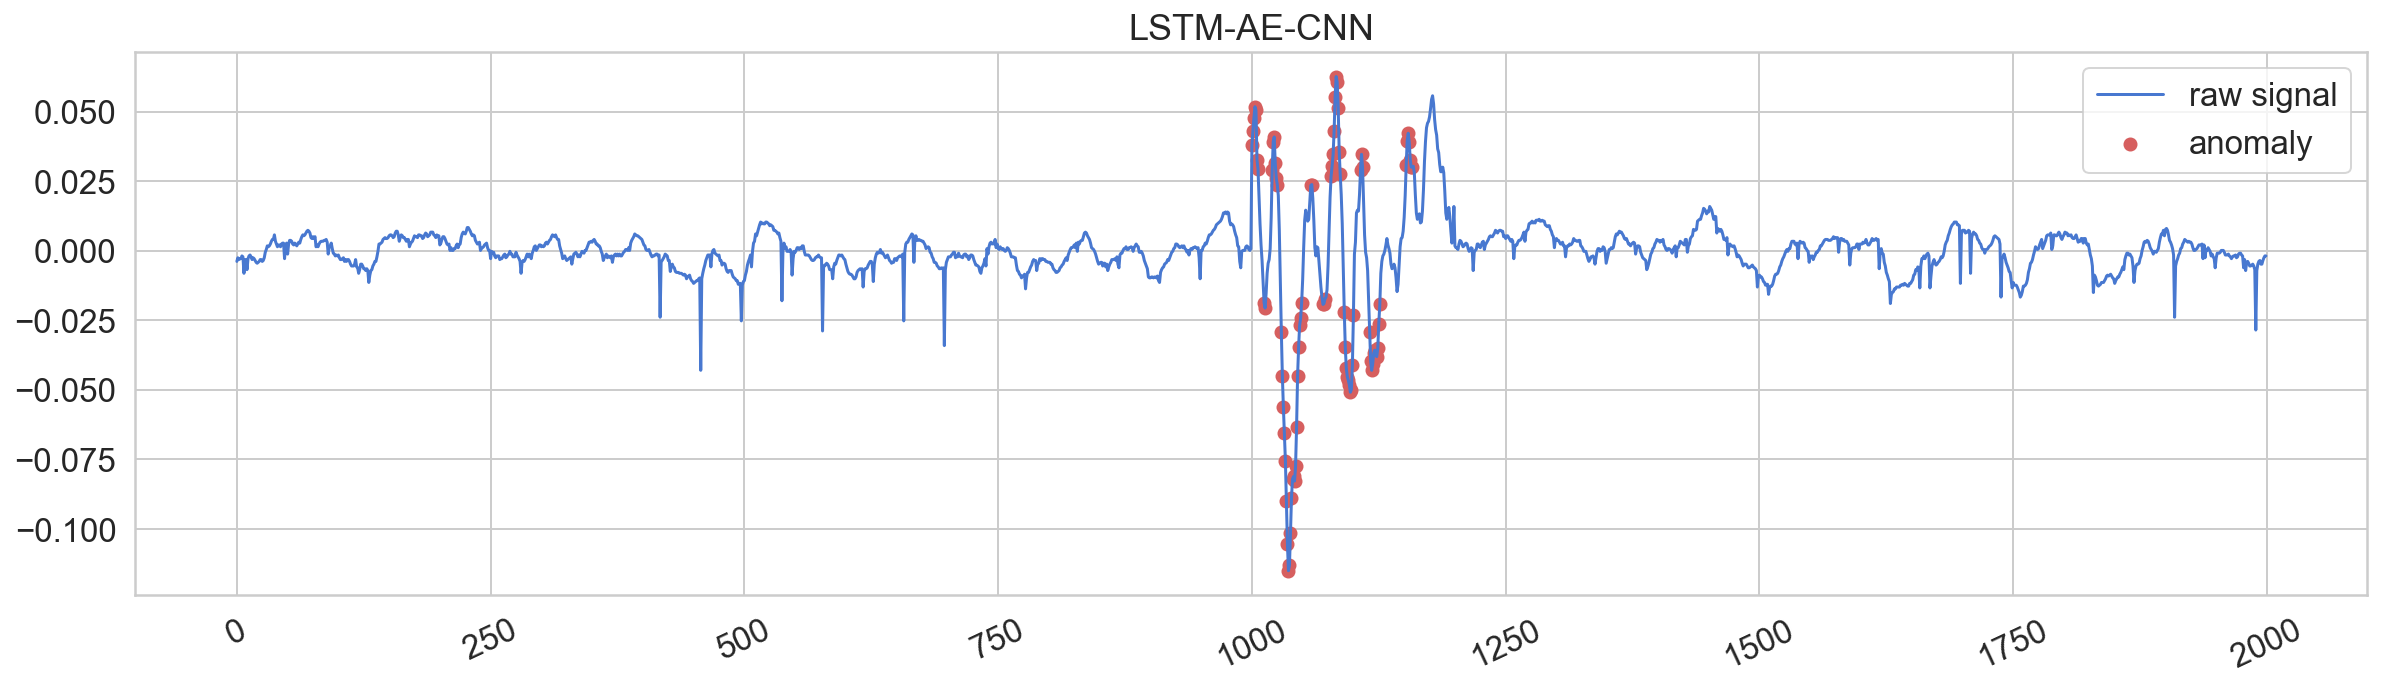

In [77]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies.index,
  np.array(anomalies.signal).reshape(len(anomalies.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("LSTM-AE-CNN")
plt.xticks(rotation=25)
plt.legend()

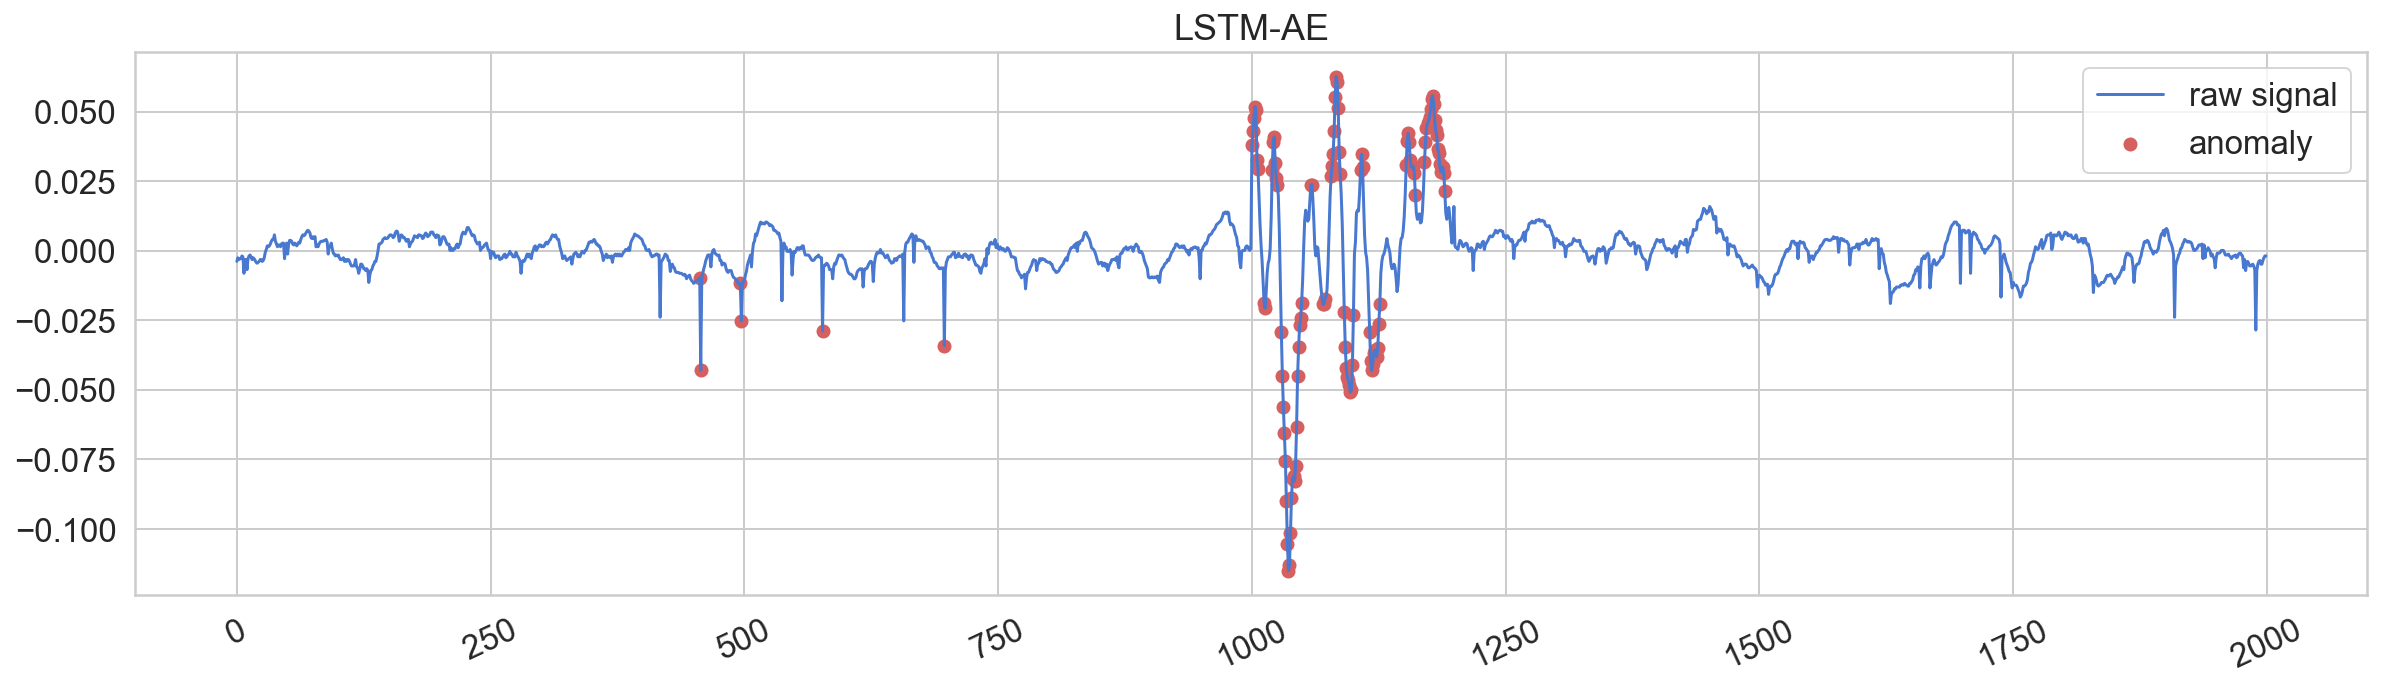

In [78]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies_ae.index,
  np.array(anomalies_ae.signal).reshape(len(anomalies_ae.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("LSTM-AE")
plt.xticks(rotation=25)
plt.legend()

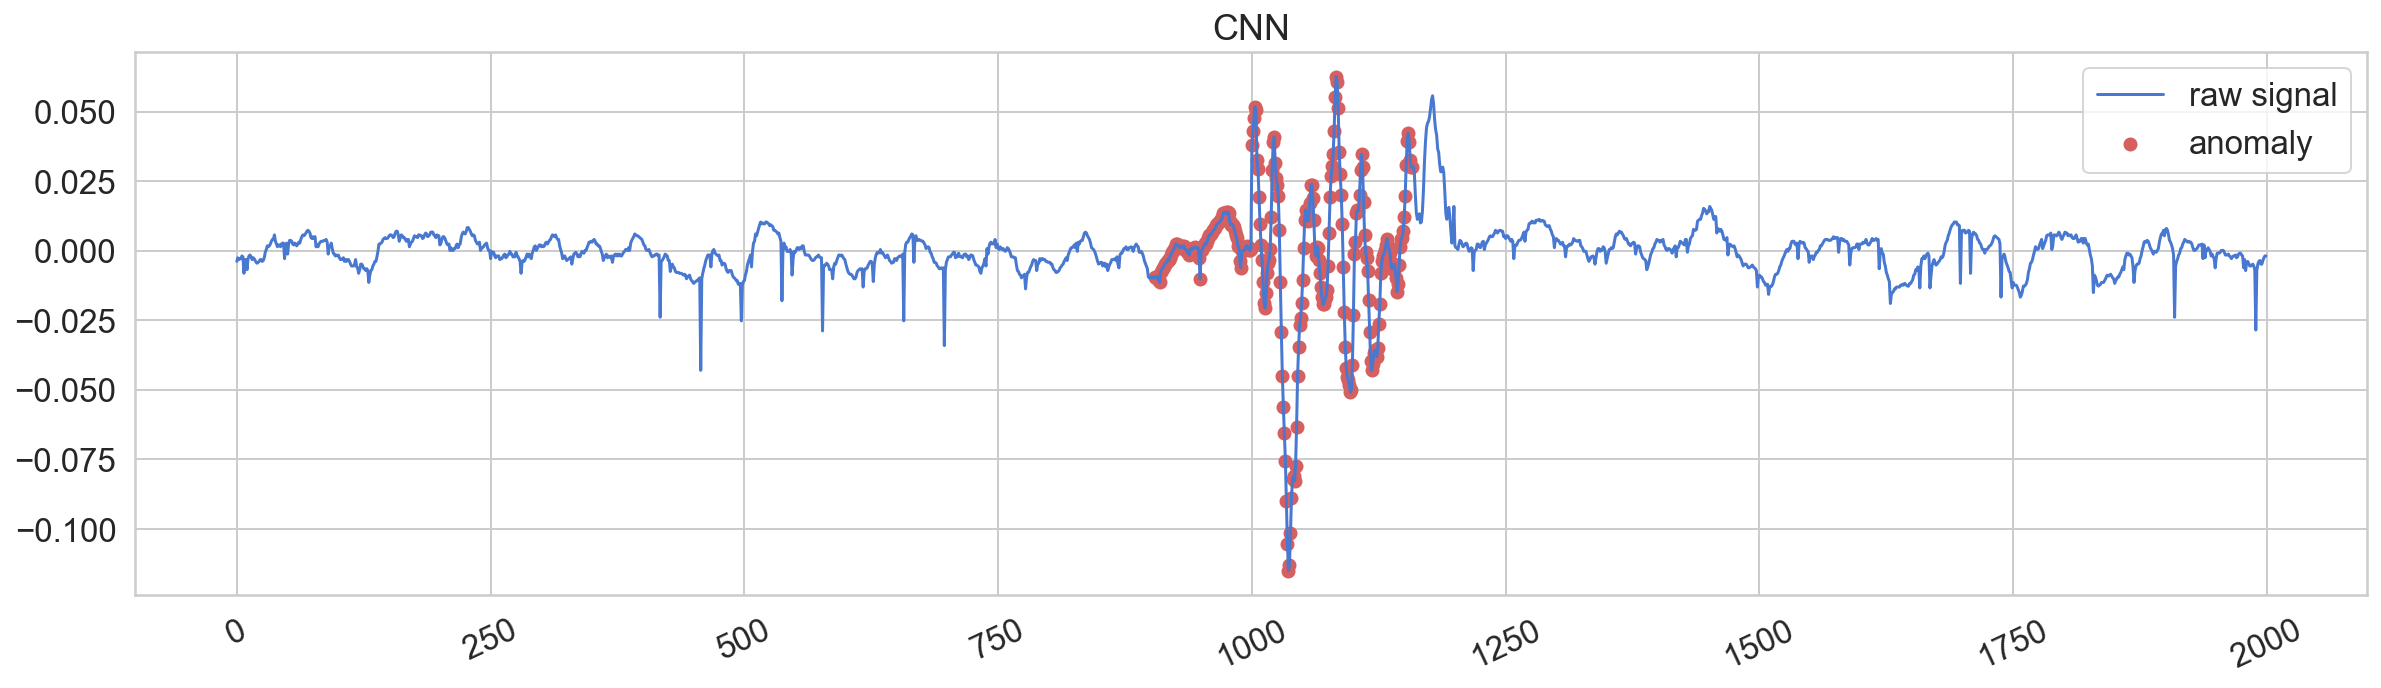

In [79]:
plt.figure(figsize=(20,5))
plt.plot( 
  test, 
  label='raw signal'
)

plt.scatter(
  anomalies_cnn.index,
  np.array(anomalies_cnn.signal).reshape(len(anomalies_cnn.signal),1),
  color=sns.color_palette()[3],
  label='anomaly'
)
plt.title("CNN")
plt.xticks(rotation=25)
plt.legend()

In [84]:
model.save("model_AE_step_100.h5")